### Import Relevant Libraries

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.layers import Bidirectional, GRU, Dense
from tensorflow.keras.models import Sequential
from sklearn.neighbors import KNeighborsClassifier  # For KNN
from sklearn.linear_model import LinearRegression  # For linear regression
from sklearn.metrics import accuracy_score
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from tensorflow.keras.regularizers import L1L2, L1
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

#### Read Dataset

In [2]:
df = pd.read_csv("/kaggle/input/dataset/Dataset _01.csv")

In [3]:
df.head()

,Subjects,Grade,original_firstorder_Skewness_t1c,original_glrlm_HighGrayLevelRunEmphasis_t1c,wavelet-LLH_glszm_GrayLevelNonUniformityNormalized_t1c,wavelet-LHL_glszm_GrayLevelNonUniformityNormalized_t1c,wavelet-HLL_glszm_GrayLevelNonUniformityNormalized_t1c,wavelet-HLH_firstorder_Mean_t1c,wavelet-HLH_glszm_ZoneEntropy_t1c,wavelet-HHL_glszm_HighGrayLevelZoneEmphasis_t1c,...,original_glrlm_ShortRunHighGrayLevelEmphasis_t2f,wavelet-LHH_glszm_GrayLevelVariance_t2f,wavelet-LHH_glszm_SmallAreaEmphasis_t2f,wavelet-HLL_glrlm_LongRunLowGrayLevelEmphasis_t2f,wavelet-HLL_glrlm_LongRunHighGrayLevelEmphasis_t2f,wavelet-LHL_glrlm_LongRunHighGrayLevelEmphasis_t2f,wavelet-HLL_glrlm_RunEntropy_t2f,wavelet-LLH_glrlm_RunEntropy_t2f,wavelet-LHL_glrlm_LongRunLowGrayLevelEmphasis_t2f,wavelet-LLH_gldm_SmallDependenceEmphasis_t2f
0,Meningioma-SEG-CLASS-001,1,-0.202380,1.000000,0.500000,0.781250,0.625000,0.035199,1.584963,3.000000,...,0.183386,0.222222,0.333336,7.258789,15.252757,16.975874,2.819105,3.283991,6.025921,0.009225
1,Meningioma-SEG-CLASS-002,1,0.078198,3.998177,0.644970,0.792388,0.591837,0.002975,2.521641,2.384615,...,0.412566,0.213018,0.655983,12.879417,42.543773,35.485714,3.372202,3.737664,10.480360,0.005394
2,Meningioma-SEG-CLASS-003,0,-1.122465,3.970686,0.749135,0.755102,0.745000,0.005018,1.548795,2.500000,...,0.580900,0.245556,0.600261,9.280669,31.384120,25.073600,3.179709,3.700225,7.322684,0.005692
3,Meningioma-SEG-CLASS-004,0,-0.559125,3.970544,0.537190,0.531250,0.820000,-0.029598,2.324863,2.800000,...,0.163532,0.225922,0.505917,9.889856,29.793151,27.326205,3.308140,3.773040,8.183365,0.005711
4,Meningioma-SEG-CLASS-005,0,-0.854174,1.000000,0.739645,0.501730,0.755102,0.003390,2.128085,3.250000,...,0.505990,0.242215,0.590278,11.860141,36.602601,23.996250,3.482922,3.825040,7.443554,0.004615


In [4]:
df.shape

(94, 50)

In [5]:
len(df.columns)

50

#### Encode Dataset

In [3]:
for col in df.columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].astype('category').cat.codes

#### Correlation Analysis - Pearson

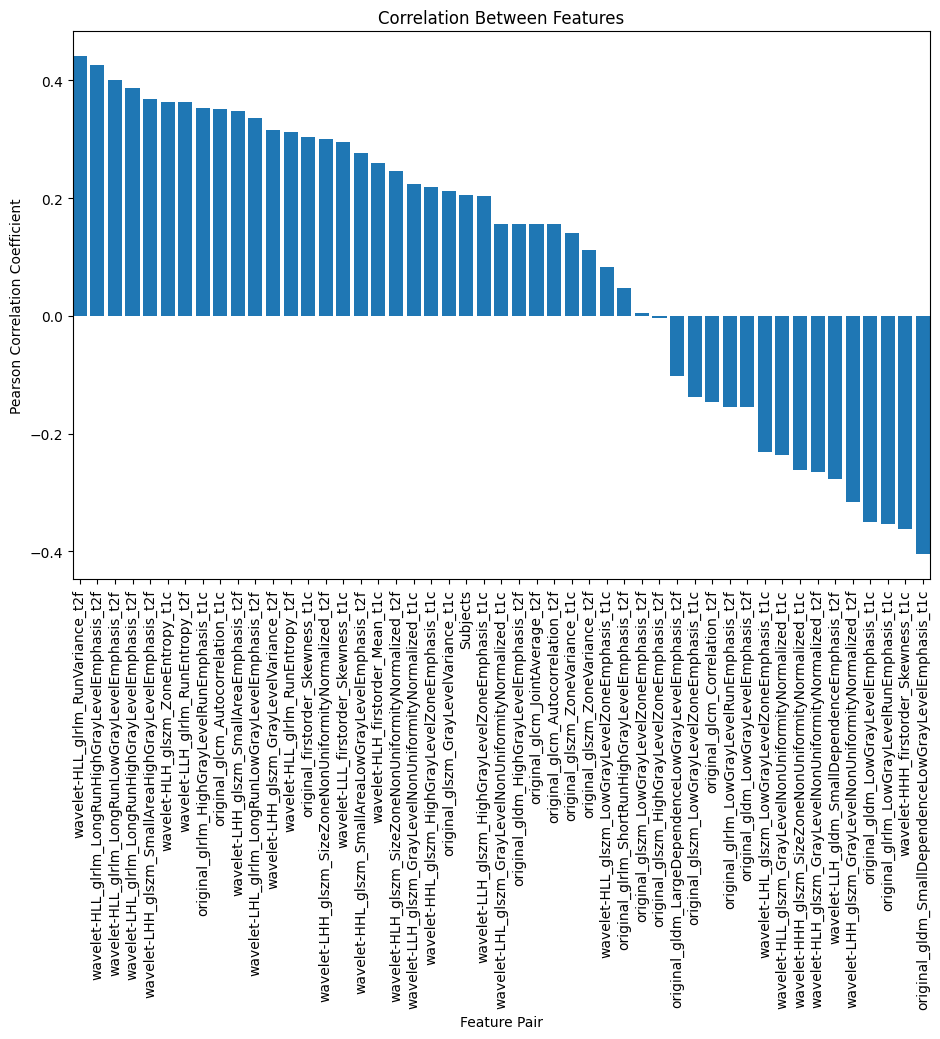

In [12]:
# Calculate correlation coefficients with "Grade" as target
target_column = 'Grade'
correlation_coefficients = df.corr(method='pearson')[target_column].drop(target_column)  # Exclude self-correlation

feature_names = df.drop(["Grade"], axis=1).columns

# Sort features and scores together by descending scores
data_tuples = list(zip(feature_names, correlation_coefficients))
data_tuples.sort(key=lambda x: x[1], reverse=True)
feature_names, correlation_coefficients = zip(*data_tuples)

# display the pearson correlation graph as barchart    
fig, ax = plt.subplots(1, figsize=(9.5,10.5))
plt.bar(feature_names, correlation_coefficients) 
plt.xlabel('Feature Pair')
plt.ylabel('Pearson Correlation Coefficient')
plt.title('Correlation Between Features')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.margins(x=0)
plt.show()

#### Detect Outliers - Z Threshold

In [13]:
import pandas as pd
from scipy import stats

z_threshold = 3  # Common outlier threshold
outlier_df = pd.DataFrame(index=df.index, columns=df.columns)  # Initialize empty DataFrame

for col in df.columns:
    if col != 'Grade': 
        zscores = stats.zscore(df[col])
        potential_outliers = df[np.abs(zscores) > z_threshold]
        if not potential_outliers.empty:  # Check if DataFrame is empty
            outlier_df.loc[potential_outliers.index, col] = potential_outliers[col] 
outlier_df.to_csv("outliers.csv")
print(outlier_df.head())

  Subjects Grade original_firstorder_Skewness_t1c  \
0      NaN   NaN                              NaN   
1      NaN   NaN                              NaN   
2      NaN   NaN                              NaN   
3      NaN   NaN                              NaN   
4      NaN   NaN                              NaN   

  original_glrlm_HighGrayLevelRunEmphasis_t1c  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

  wavelet-LLH_glszm_GrayLevelNonUniformityNormalized_t1c  \
0                                                NaN       
1                                                NaN       
2                                                NaN       
3                                                NaN       
4                                                NaN       

  wavelet-LHL_glszm_GrayL

#### Scale Dataset - RobustScaler

In [4]:
scaler = RobustScaler()
X = df.drop(["Grade"], axis=1)
y = df["Grade"]
scaled_data = scaler.fit_transform(X)
scaled_data[:5, :5]

array([[-1.00000000e+00,  4.36349110e-02, -9.92668708e-01,
        -6.46961346e-01,  1.03973556e+00],
       [-9.78494624e-01,  3.38165269e-01,  8.68420243e-03,
         1.43889030e-01,  1.10481269e+00],
       [-9.56989247e-01, -9.22201598e-01, -4.97450032e-04,
         7.12132981e-01,  8.86951932e-01],
       [-9.35483871e-01, -3.30849683e-01, -5.44679844e-04,
        -4.44080011e-01, -4.21024994e-01],
       [-9.13978495e-01, -6.40570245e-01, -9.92668708e-01,
         6.60362744e-01, -5.93510992e-01]])

#### Filter Method - Fisher Score

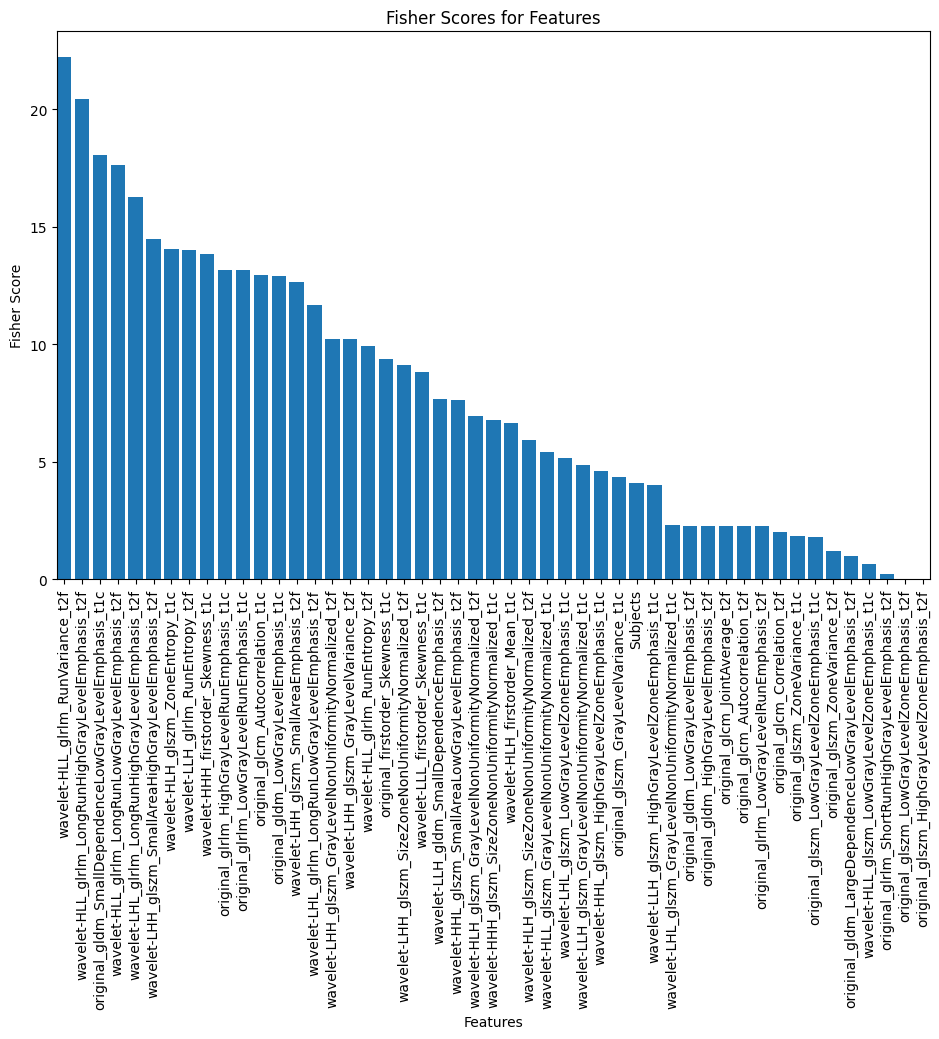

In [10]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

# Sample dataset 
features = df.drop('Grade', axis=1)
target = df['Grade']

# Feature Selection with Fisher Score
selector = SelectKBest(score_func=f_classif, k='all')  # Select all features
selector.fit(features, target)
fisher_scores = selector.scores_
feature_names = features.columns

# Sort features and scores together by descending scores
data_tuples = list(zip(feature_names, fisher_scores))
data_tuples.sort(key=lambda x: x[1], reverse=True)
feature_names, fisher_scores = zip(*data_tuples)

# Create Bar Chart
fig, ax = plt.subplots(1, figsize=(9.5,10.5))
plt.bar(feature_names, fisher_scores)
plt.xlabel('Features')
plt.ylabel('Fisher Score')
plt.title('Fisher Scores for Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.margins(x=0)
plt.show()

#### Wrapper Method - Recursive Feature Elimination (RFE)

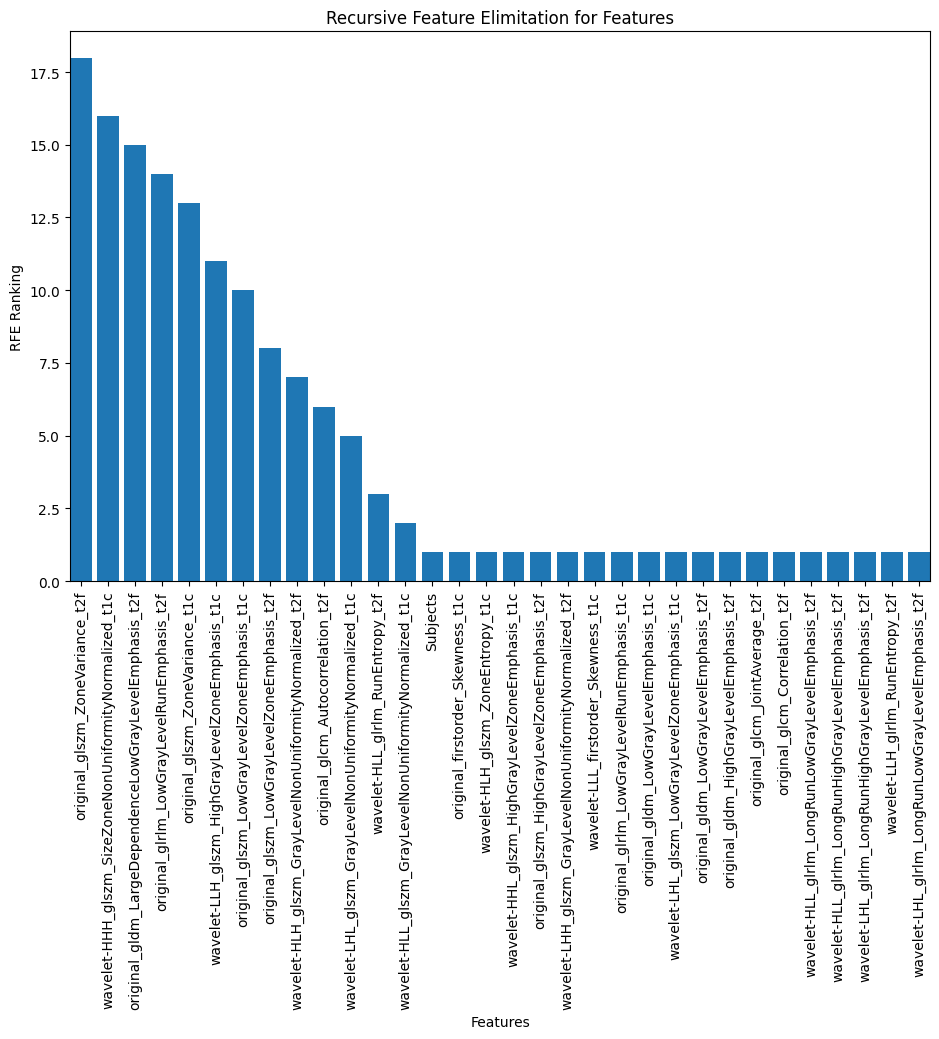

In [5]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression  # Example estimator

# extract features and target
features = df.drop('Grade', axis=1)
target = df['Grade']

# Choose an estimator
estimator = LogisticRegression()  

# Create the RFE object
rfe = RFE(estimator=estimator, n_features_to_select=32)  

# Fit RFE 
rfe.fit(features, target)  

# Access selected features
selected_features = features.columns[rfe.support_]
# print(selected_features)

# Sort features and scores together by descending scores
data_tuples = list(zip(selected_features, rfe.ranking_))
data_tuples.sort(key=lambda x: x[1], reverse=True)
feature_names, ranking = zip(*data_tuples)

# Create Bar Chart
fig, ax = plt.subplots(1, figsize=(9.5,10.5))
plt.bar(feature_names, ranking)
plt.xlabel('Features')
plt.ylabel('RFE Ranking')
plt.title('Recursive Feature Elimitation for Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.margins(x=0)
plt.show()

##### Show Selected RFE Features

In [6]:
rfe_selected_features = []
# Filter and print feature_names with ranking above 2.0
for feature, rank in data_tuples:
    if rank >= 2.0:
        print(f'{feature} - {rank}')
        rfe_selected_features.append(feature)

original_glszm_ZoneVariance_t2f - 18
wavelet-HHH_glszm_SizeZoneNonUniformityNormalized_t1c - 16
original_gldm_LargeDependenceLowGrayLevelEmphasis_t2f - 15
original_glrlm_LowGrayLevelRunEmphasis_t2f - 14
original_glszm_ZoneVariance_t1c - 13
wavelet-LLH_glszm_HighGrayLevelZoneEmphasis_t1c - 11
original_glszm_LowGrayLevelZoneEmphasis_t1c - 10
original_glszm_LowGrayLevelZoneEmphasis_t2f - 8
wavelet-HLH_glszm_GrayLevelNonUniformityNormalized_t2f - 7
original_glcm_Autocorrelation_t2f - 6
wavelet-LHL_glszm_GrayLevelNonUniformityNormalized_t1c - 5
wavelet-HLL_glrlm_RunEntropy_t2f - 3
wavelet-HLL_glszm_GrayLevelNonUniformityNormalized_t1c - 2


#### Split Training & Test Dataset

In [7]:
X = df[rfe_selected_features]
y = df['Grade']
Scaled_X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Scaled_X, y, test_size = .3, stratify = y, random_state=10)

#### Set Seed for Randomness

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

### Train Machine Learning Models

#### Define and Train KNN Model

In [9]:
# Create a KNN classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3)  
# Fit the model
knn.fit(X_train, y_train) 

# Prediction Example 
knn_test_prediction = knn.predict(X_test)
print("KNN Prediction:", knn_test_prediction) 

KNN Prediction: [0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0]


#### Define and Train Linear Regression Model

In [10]:
# Create a linear regression object
linr = LinearRegression() 
# Fit the model
linr.fit(X_train, y_train)  

# Prediction Example
linr_test_predictions = linr.predict(X_test)
linr_test_rounded_predictions = np.where(linr_test_predictions >= 0.5, 1, 0)
print("Linear Regression Prediction:", linr_test_rounded_predictions)

Linear Regression Prediction: [0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0]


#### Define Bidirectional Gated Recurrent Unit (Bi-GRU) Model

In [ ]:
def build_Bi_GRU(num_features, time_steps, num_classes):
    model = Sequential(name="Bi_GRU")
    model.add(Bidirectional(GRU(num_features*5, return_sequences=True, activation='tanh'), input_shape=(time_steps, num_features), name="bi_gru_input"))
    model.add(Bidirectional(GRU(num_features*4, return_sequences=True, activation='relu'), name="bi_gru_l2"))
    model.add(Bidirectional(GRU(num_features*3, activation='softmax'), name="bi_gru_l3"))
    model.add(Dense(num_classes, activation='sigmoid', name="output_layer"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

#### Reshape Input Data

In [12]:
def reshape_X(data):
    if isinstance(data, pd.DataFrame):
        data = data.values
    
    # Reshape the data into a 3D array
    num_samples = data.shape[0] 
    input = np.zeros((num_samples, time_steps, num_features))
    for i in range(num_samples):
        if i+time_steps < num_samples:
            input[i, :, :] = data[i:i+time_steps, :]
            
    return input

#### Reshape Output Data

In [14]:
def encode_y(y):
    output = []
    for n in y:
        output.append(np.where(n == 0, [0, 1], [1, 0]))  # Map 0 to [0, 0] and 1 to [1, 0]
    
    return output

#### Define Parameters for Bi-GRU Model

In [15]:
epoch = 300
num_features = len(rfe_selected_features)

time_steps = 3
X_train_reshaped = reshape_X(X_train)
X_test_reshaped = reshape_X(X_test)
y_train_reshaped = np.array(encode_y(y_train))
y_test_reshaped = np.array(encode_y(y_test))

num_classes = y_test_reshaped.shape[1]

print(f'Feature Count: {num_features} \nNum Classes: {num_classes} \nTime Step: {time_steps}')
print(X_train_reshaped.shape)
print(X_test_reshaped.shape)
print(y_train_reshaped.shape)
print(y_test_reshaped.shape)

Feature Count: 13 
Num Classes: 2 
Time Step: 3
(65, 3, 13)
(29, 3, 13)
(65, 2)
(29, 2)


#### Build Bi-GRU Model

In [16]:
Bi_GRU = build_Bi_GRU(num_features, time_steps, num_classes)
Bi_GRU.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Bi_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bi_gru_input (Bidirectional)    │ (None, 3, 130)         │        31,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_gru_l2 (Bidirectional)       │ (None, 3, 104)         │        57,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_gru_l3 (Bidirectional)       │ (None, 78)             │        33,930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 2)              │           158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,696 (479.28 KB)

 Trainable params: 122,696 (479.28 KB)

 Non-trainable params: 0 (0.00 B)

#### Define Checkpoint Callback to Save Bi-GRU Best

In [17]:
import tensorflow as tf
gru_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'gru_best.weights.h5', monitor='val_accuracy', mode='max', verbose=1, 
    save_best_only=True, save_weights_only=True
)

#### Train Bi-GRU Model

In [18]:
history = Bi_GRU.fit(X_train_reshaped, y_train_reshaped, 
                         epochs = epoch, 
                         validation_data=(X_test_reshaped, y_test_reshaped), 
                         shuffle=True,
                         callbacks=[gru_checkpoint_callback],
                         verbose=1)

Epoch 1/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 22s 11s/step - accuracy: 0.4375 - loss: 0.6958
Epoch 1: val_accuracy improved from -inf to 0.44828, saving model to gru_best.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 648ms/step - accuracy: 0.4302 - loss: 0.6930 - val_accuracy: 0.4483 - val_loss: 0.6947
Epoch 2/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4375 - loss: 0.6951
Epoch 2: val_accuracy did not improve from 0.44828
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4302 - loss: 0.6917 - val_accuracy: 0.4483 - val_loss: 0.6948
Epoch 3/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4375 - loss: 0.6951
Epoch 3: val_accuracy did not improve from 0.44828
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4302 - loss: 0.6908 - val_accuracy: 0.4483 - val_loss: 0.6949
Epoch 4/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4375 - loss: 0.6951
Epoch 4: val_accuracy did not improve from 0.44828
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4302 - loss: 0.6897 - val_

#### Define Bi-GRU Model Evaluation

In [21]:
def evaluate_gru(gru_model, X_train, y_train, X_test, y_test):
    
    gru_perf = []
    gru_train_metric = gru_model.evaluate(X_train, y_train, return_dict=True)
    gru_test_metric = gru_model.evaluate(X_test, y_test, return_dict=True)
    
    training_accuracy = gru_train_metric["accuracy"]*100
    training_loss = gru_train_metric["loss"]*100
    test_accuracy = gru_test_metric["accuracy"]*100
    test_loss = gru_test_metric["loss"]*100
    
    gru_perf.extend([training_accuracy, training_loss, test_accuracy, test_loss])
    
    print(f'Training Accuracy: {round(training_accuracy, 2)}% and loss: {round(training_loss, 4)}')
    print(f'Test Accuracy: {round(test_accuracy, 2)}% and loss: {round(test_loss, 4)}')
    
    return gru_perf

#### Evaluate Trained Models

In [22]:
Bi_GRU.load_weights('gru_best.weights.h5')
gru_perf = evaluate_gru(Bi_GRU, X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6628 - loss: 0.6651 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7241 - loss: 0.6639
Training Accuracy: 66.15% and loss: 67.2883
Test Accuracy: 72.41% and loss: 66.389


#### Save Bi-GRU Model

In [23]:
Bi_GRU.save('BiGRU_model.h5')

ValueError: Unable to synchronously create dataset (name already exists)

#### Bi-GRU Evaluation

In [24]:
gru_y_true = y_test_reshaped.argmin(axis=1)
gru_y_pred = Bi_GRU.predict(X_test_reshaped)
gru_y_pred_ = gru_y_pred.argmin(axis=1)

# Calculate F1-score, recall, precision and AUC
gru_f1 = f1_score(gru_y_true, gru_y_pred_)
gru_recall = recall_score(gru_y_true, gru_y_pred_)
gru_precision = precision_score(gru_y_true, gru_y_pred_)
gru_auc = roc_auc_score(gru_y_true, gru_y_pred_)

gru_perf.extend([gru_f1, gru_recall, gru_precision, gru_auc])

# Print the results
print("GRU F1-score:", gru_f1)
print("GRU Recall:", gru_recall)
print("GRU Precision:", gru_precision)
print("GRU AUC-ROC:", gru_auc)  # Only applicable for binary classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
GRU F1-score: 0.6923076923076923
GRU Recall: 0.6923076923076923
GRU Precision: 0.6923076923076923
GRU AUC-ROC: 0.7211538461538461


#### KNN Model Evaluation

In [25]:
# Create variable to store KNN performance variables
knn_perf = []

# Evaluate the model performance (e.g., accuracy score)
from sklearn.metrics import accuracy_score
knn_train_predictions = knn.predict(X_train)
knn_accuracy = accuracy_score(y_train, knn_train_predictions) * 100
knn_perf.append(knn_accuracy)
print(f"Accuracy: {round(knn_accuracy, 2)}%")

# Evaluate model performance on the test set (using existing split)
from sklearn.metrics import accuracy_score
knn_test_accuracy = accuracy_score(y_test, knn_test_prediction) * 100
knn_perf.append(knn_test_accuracy)
print(f"Validation Accuracy: {round(knn_test_accuracy, 2)}%")

# Perform 5-fold cross-validation on the entire dataset (excluding the test set)
knn_cross_val_accuracy = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy').mean() * 100 
knn_perf.append(knn_cross_val_accuracy)
print(f"Cross-Validation Accuracy: {round(knn_cross_val_accuracy, 2)}%")

# Calculate KNN F1-score, recall, Precision, AUC
knn_f1 = f1_score(y_test, knn_test_prediction)
knn_recall = recall_score(y_test, knn_test_prediction)
knn_precision = precision_score(y_test, knn_test_prediction)
knn_auc = roc_auc_score(y_test, knn_test_prediction)

# Append KNN performance results in array
knn_perf.extend([knn_f1, knn_recall, knn_precision, knn_auc])

# Print the results
print("KNN F1-score:", knn_f1)
print("KNN Recall:", knn_recall)
print("KNN Precision:", knn_precision)
print("KNN AUC-ROC:", knn_auc)

Accuracy: 81.54%
Validation Accuracy: 58.62%
Cross-Validation Accuracy: 64.62%
KNN F1-score: 0.5384615384615384
KNN Recall: 0.5384615384615384
KNN Precision: 0.5384615384615384
KNN AUC-ROC: 0.5817307692307692


#### Linear Regression Model Evaluation

In [26]:
# Create variable to store KNN performance variables
linr_perf = []

# Evaluate the model performance (e.g., accuracy score)
from sklearn.metrics import accuracy_score
linr_train_predictions = linr.predict(X_train)
linr_train_rounded_predictions = np.where(linr_train_predictions >= 0.5, 1, 0)
linr_accuracy = accuracy_score(y_train, linr_train_rounded_predictions) * 100
linr_perf.append(linr_accuracy)
print(f"Accuracy: {round(linr_accuracy, 2)}%")

# Evaluate model performance on the test set (using existing split)
from sklearn.metrics import accuracy_score
linr_test_accuracy = accuracy_score(y_test, linr_test_rounded_predictions) * 100
linr_perf.append(linr_test_accuracy)
print(f"Validation Accuracy: {round(linr_test_accuracy, 2)}%")

# Perform 5-fold cross-validation on the entire dataset (excluding the test set)
linr_cross_val_accuracy = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy').mean() * 100 
linr_perf.append(linr_cross_val_accuracy)
print(f"Cross-Validation Accuracy: {round(linr_cross_val_accuracy, 2)}%")

# Calculate KNN F1-score, recall, Precision, AUC
linr_f1 = f1_score(y_test, linr_test_rounded_predictions)
linr_recall = recall_score(y_test, linr_test_rounded_predictions)
linr_precision = precision_score(y_test, linr_test_rounded_predictions)
linr_auc = roc_auc_score(y_test, linr_test_rounded_predictions)

# Append Linear Regression performance results in array
linr_perf.extend([linr_f1, linr_recall, linr_precision, linr_auc])

# Print the results
print("Linear Regression F1-score:", linr_f1)
print("Linear Regression Recall:", linr_recall)
print("Linear Regression Precision:", linr_precision)
print("Linear Regression AUC-ROC:", linr_auc)

Accuracy: 75.38%
Validation Accuracy: 72.41%
Cross-Validation Accuracy: 64.62%
Linear Regression F1-score: 0.6666666666666667
Linear Regression Recall: 0.6153846153846154
Linear Regression Precision: 0.7272727272727273
Linear Regression AUC-ROC: 0.7139423076923077


## Hyperparameter Tuning

In [95]:
!pip install optuna
!pip install optuna-integration
!pip install optuna-dashboard

### Bidirectional GRU Optimization Using Optuna

In [140]:
def create_gru_model(trial):
    bi_gru_layers = trial.suggest_int("bi_gru_layers", 1, 4)
    bi_gru_hidden_layers = []
    
    # Initialize Optimized Bidirectional GRU Model
    bi_gru_model_opt = Sequential(name='Bi_GRU_Optimzed')
    
    # Define a list/grid of L1 and L2 regularization values
    l1_values = [0.001, 0.01, 0.1]
    l2_values = [0.001, 0.01, 0.1]
    
    for i in range(bi_gru_layers):
        bi_gru_dropout = trial.suggest_float("bi_gru_dropout{}".format(i), 0.001, 0.3)
        bi_gru_units = trial.suggest_categorical("bi_gru_units{}".format(i), [1, 2, 3, 4, 5])
        bi_gru_activation = trial.suggest_categorical("bi_gru_activation_{}".format(i), ['tanh', 'sigmoid', 'softmax', 'relu'])
        bi_gru_recurrent_activation = trial.suggest_categorical("bi_gru_recurrent_activation_{}".format(i), ['tanh', 'sigmoid', 'softmax', 'relu'])
        bi_gru_kr_l1 = trial.suggest_categorical("bi_gru_kr_l1_{}".format(i), [0, 0.001, 0.01, 0.1])
        bi_gru_kr_l2 = trial.suggest_categorical("bi_gru_kr_l2_{}".format(i), [0, 0.001, 0.01, 0.1])
        bi_gru_rr_l1 = trial.suggest_categorical("bi_gru_rr_l1_{}".format(i), [0, 0.001, 0.01, 0.1])
        bi_gru_rr_l2 = trial.suggest_categorical("bi_gru_rr_l2_{}".format(i), [0, 0.001, 0.01, 0.1])
        bi_gru_br_l1 = trial.suggest_categorical("bi_gru_br_l1_{}".format(i), [0, 0.001, 0.01, 0.1])
        bi_gru_br_l2 = trial.suggest_categorical("bi_gru_br_l2_{}".format(i), [0, 0.001, 0.01, 0.1])
        bi_gru_recurrent_dropout = trial.suggest_float("bi_gru_recurrent_dropout_{}".format(i), 0.001, 0.1)
        
        
        if i == (bi_gru_layers-1):
            return_sequences = False
        else:
            return_sequences = True
            
        bi_gru_model_opt.add(
            GRU(
                units=num_features * bi_gru_units, 
                return_sequences=return_sequences, 
                input_shape=(time_steps, num_features), 
                activation=bi_gru_activation, 
                dropout=bi_gru_dropout,
                kernel_regularizer= L1L2(l1=bi_gru_kr_l1, l2=bi_gru_kr_l2),
                recurrent_regularizer= L1L2(l1=bi_gru_rr_l1, l2=bi_gru_rr_l2),
                bias_regularizer=L1L2(l1=bi_gru_br_l1, l2=bi_gru_br_l2),
                recurrent_dropout= bi_gru_recurrent_dropout
            )
        )
    
    bi_gru_model_activation = trial.suggest_categorical("bi_gru_model_activation", ['tanh', 'sigmoid', 'softmax', 'relu'])
    bi_gru_model_opt.add(Dense(num_classes, activation=bi_gru_model_activation))
    
    bi_gru_model_optimizer = trial.suggest_categorical("bi_gru_model_optimizer", ['adam', 'nadam'])
    bi_gru_model_loss = trial.suggest_categorical("bi_gru_model_loss", ["categorical_crossentropy", "binary_crossentropy"])
    bi_gru_model_opt.compile(loss=bi_gru_model_loss, optimizer=bi_gru_model_optimizer, metrics=['accuracy'])
        
    return bi_gru_model_opt

In [143]:
def objective(trial):
    # Clear clutter from previous TensorFlow graphs.
    tf.keras.backend.clear_session()

    # Metrics to be monitored by Optuna.
    if tf.__version__ >= "2":
        acc_monitor = "val_accuracy"
    else:
        acc_monitor = "val_acc"
        
    # Create tf.keras model instance.
    gru_model_opt = create_gru_model(trial)

#     # Create callbacks for early stopping and pruning.
    optuna_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3),
        TFKerasPruningCallback(trial, acc_monitor)
    ]
    
    # Train model.
    gru_opt_history = gru_model_opt.fit(X_train_reshaped, y_train_reshaped, 
                          epochs = 20, 
                          validation_data=(X_test_reshaped, y_test_reshaped), 
                          shuffle=True, 
                          callbacks=optuna_callbacks,             
                          verbose=1)

    return gru_opt_history.history[acc_monitor][-1]

In [137]:
def gru_opt_show_result(study):
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("BiGRU Study statistics: ")
    print("\tNumber of finished trials: ", len(study.trials))
    print("\tNumber of pruned trials: ", len(pruned_trials))
    print("\tNumber of complete trials: ", len(complete_trials))

    print("Best trials:")
    trial= study.best_trial

    print("\tValue: ", trial.values)

    print("\tParams: ")
    for key, value in trial.params.items():
        print("\t{}: {}".format(key, value))

In [141]:
def main_bi_gru_opt():
    
    study_bi_gru = optuna.create_study(
        direction= "maximize", 
        pruner=optuna.pruners.MedianPruner(n_startup_trials=3), 
        storage="sqlite:///db.sqlite",  # Specify the storage URL here.
        study_name="bi_gru_optimization",
        load_if_exists=True
    )

    study_bi_gru.optimize(objective, n_trials=1000)

    gru_opt_show_result(study_bi_gru)

In [145]:
if __name__ == "__main__":
    main_bi_gru_opt()

[I 2024-04-15 13:14:42,379] A new study created in RDB with name: bi_gru_optimization


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 513ms/step - accuracy: 0.4264 - loss: 88.3335 - val_accuracy: 0.4483 - val_loss: 84.6968
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5272 - loss: 83.7922 - val_accuracy: 0.4483 - val_loss: 80.2684
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4844 - loss: 79.3124 - val_accuracy: 0.4483 - val_loss: 76.0315
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5581 - loss: 75.1400 - val_accuracy: 0.4483 - val_loss: 71.9683
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4612 - loss: 71.1508 - val_accuracy: 0.4483 - val_loss: 68.0715
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4418 - loss: 67.2535 - val_accuracy: 0.4483 - val_loss: 64.3216
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3798 - loss: 63.5465 - val_accuracy: 0.4483 - val_loss: 60.7414
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4496 - loss: 60.0421 - val_accuracy: 0.4483 - v

[I 2024-04-15 13:14:54,480] Trial 0 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 3, 'bi_gru_dropout0': 0.15135194073590158, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.01, 'bi_gru_rr_l1_0': 0.1, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.033105558825227005, 'bi_gru_dropout1': 0.06680724510127063, 'bi_gru_units1': 5, 'bi_gru_activation_1': 'relu', 'bi_gru_recurrent_activation_1': 'tanh', 'bi_gru_kr_l1_1': 0.001, 'bi_gru_kr_l2_1': 0.001, 'bi_gru_rr_l1_1': 0.01, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.001, 'bi_gru_br_l2_1': 0.01, 'bi_gru_recurrent_dropout_1': 0.05266586675426839, 'bi_gru_dropout2': 0.08911452367397359, 'bi_gru_units2': 4, 'bi_gru_activation_2': 'sigmoid', 'bi_gru_recurrent_activation_2': 'relu', 'bi_gru_kr_l1_2': 0.001, 'bi_gru_kr_l2_2': 0.001, 'bi_gru_rr_l1_2': 0, 'bi_gru_rr_l2_2': 0.001, 'bi

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 637ms/step - accuracy: 0.4844 - loss: 42.3999 - val_accuracy: 0.4483 - val_loss: 39.2504
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4380 - loss: 42.1824 - val_accuracy: 0.4483 - val_loss: 37.8363
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4186 - loss: 38.4509 - val_accuracy: 0.4483 - val_loss: 36.4797
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4418 - loss: 36.5984 - val_accuracy: 0.4483 - val_loss: 35.2719
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4224 - loss: 35.0975 - val_accuracy: 0.4483 - val_loss: 34.1077
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4459 - loss: 33.8111 - val_accuracy: 0.4483 - val_loss: 32.9815
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5036 - loss: 32.7296 - val_accuracy: 0.4483 - val_loss: 31.8803
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4650 - loss: 31.6378 - val_accuracy: 0.4483 - 

[I 2024-04-15 13:15:09,872] Trial 1 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 4, 'bi_gru_dropout0': 0.12871697989524142, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'sigmoid', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.01, 'bi_gru_rr_l1_0': 0.1, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.01, 'bi_gru_recurrent_dropout_0': 0.022476346384177136, 'bi_gru_dropout1': 0.23026264967314644, 'bi_gru_units1': 1, 'bi_gru_activation_1': 'softmax', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.001, 'bi_gru_kr_l2_1': 0.001, 'bi_gru_rr_l1_1': 0, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.01, 'bi_gru_br_l2_1': 0.01, 'bi_gru_recurrent_dropout_1': 0.014397699996751327, 'bi_gru_dropout2': 0.2907119361774108, 'bi_gru_units2': 2, 'bi_gru_activation_2': 'tanh', 'bi_gru_recurrent_activation_2': 'relu', 'bi_gru_kr_l1_2': 0.001, 'bi_gru_kr_l2_2': 0.01, 'bi_gru_rr_l1_2': 0.1, 'bi_gru_rr_l2_2': 

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 608ms/step - accuracy: 0.4302 - loss: 46.7637 - val_accuracy: 0.4483 - val_loss: 48.1140
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4302 - loss: 46.2008 - val_accuracy: 0.4483 - val_loss: 47.5242
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4302 - loss: 48.4448 - val_accuracy: 0.4483 - val_loss: 46.8724
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4302 - loss: 44.5783 - val_accuracy: 0.4483 - val_loss: 46.1979
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4302 - loss: 45.9938 - val_accuracy: 0.4483 - val_loss: 45.4892
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4302 - loss: 44.4427 - val_accuracy: 0.4483 - val_loss: 44.7645
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4302 - loss: 43.1476 - val_accuracy: 0.4483 - val_loss: 44.0266
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4302 - loss: 41.7791 - val_accuracy: 0.4483 - 

[I 2024-04-15 13:15:24,672] Trial 2 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 4, 'bi_gru_dropout0': 0.1572152716598951, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'softmax', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.1, 'bi_gru_recurrent_dropout_0': 0.09371196635247804, 'bi_gru_dropout1': 0.02487562080366507, 'bi_gru_units1': 2, 'bi_gru_activation_1': 'relu', 'bi_gru_recurrent_activation_1': 'softmax', 'bi_gru_kr_l1_1': 0.01, 'bi_gru_kr_l2_1': 0, 'bi_gru_rr_l1_1': 0, 'bi_gru_rr_l2_1': 0, 'bi_gru_br_l1_1': 0, 'bi_gru_br_l2_1': 0, 'bi_gru_recurrent_dropout_1': 0.07651446195456342, 'bi_gru_dropout2': 0.10463942019736452, 'bi_gru_units2': 1, 'bi_gru_activation_2': 'sigmoid', 'bi_gru_recurrent_activation_2': 'sigmoid', 'bi_gru_kr_l1_2': 0.1, 'bi_gru_kr_l2_2': 0.1, 'bi_gru_rr_l1_2': 0.1, 'bi_gru_rr_l2_2': 0.1, 'bi_gru_br_l

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5698 - loss: 66.1679 - val_accuracy: 0.5517 - val_loss: 62.9580
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5698 - loss: 63.0460 - val_accuracy: 0.5517 - val_loss: 61.2094
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5698 - loss: 61.2975 - val_accuracy: 0.5517 - val_loss: 59.4894
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5698 - loss: 59.5555 - val_accuracy: 0.5517 - val_loss: 57.7027
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5698 - loss: 57.7908 - val_accuracy: 0.5517 - val_loss: 55.8741
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5698 - loss: 55.9221 - val_accuracy: 0.5517 - val_loss: 54.0214
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5698 - loss: 54.1010 - val_accuracy: 0.5517 - val_loss: 52.1657
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5698 - loss: 52.2517 - val_accuracy: 0.5517 - val

[I 2024-04-15 13:15:38,416] Trial 3 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 3, 'bi_gru_dropout0': 0.0782000731827813, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'softmax', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.1, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.039331531301409234, 'bi_gru_dropout1': 0.2626916117157604, 'bi_gru_units1': 1, 'bi_gru_activation_1': 'tanh', 'bi_gru_recurrent_activation_1': 'tanh', 'bi_gru_kr_l1_1': 0.01, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.01, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.001, 'bi_gru_recurrent_dropout_1': 0.004150918297520579, 'bi_gru_dropout2': 0.16062931839720607, 'bi_gru_units2': 5, 'bi_gru_activation_2': 'softmax', 'bi_gru_recurrent_activation_2': 'sigmoid', 'bi_gru_kr_l1_2': 0.1, 'bi_gru_kr_l2_2': 0.01, 'bi_gru_rr_l1_2': 0, 'bi_gru_rr_l2_2': 0, 'bi_gru_

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 625ms/step - accuracy: 0.5738 - loss: 36.7454 - val_accuracy: 0.5517 - val_loss: 35.5679
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5620 - loss: 35.2540 - val_accuracy: 0.5517 - val_loss: 31.6932
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5971 - loss: 31.8439 - val_accuracy: 0.5517 - val_loss: 30.6337
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5893 - loss: 30.3500 - val_accuracy: 0.5517 - val_loss: 29.6822
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4418 - loss: 29.6808 - val_accuracy: 0.4483 - val_loss: 28.7754
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5078 - loss: 28.6248 - val_accuracy: 0.4483 - val_loss: 27.8957
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5002 - loss: 27.7354 - val_accuracy: 0.4483 - val_loss: 27.0358
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5427 - loss: 26.7995 - val_accuracy: 0.4483 - 

[I 2024-04-15 13:15:52,816] Trial 4 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 4, 'bi_gru_dropout0': 0.0852886254930293, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.05673763775912881, 'bi_gru_dropout1': 0.15847233465542032, 'bi_gru_units1': 3, 'bi_gru_activation_1': 'softmax', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0, 'bi_gru_kr_l2_1': 0, 'bi_gru_rr_l1_1': 0, 'bi_gru_rr_l2_1': 0, 'bi_gru_br_l1_1': 0, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.050625059166346284, 'bi_gru_dropout2': 0.24363596529101336, 'bi_gru_units2': 1, 'bi_gru_activation_2': 'sigmoid', 'bi_gru_recurrent_activation_2': 'tanh', 'bi_gru_kr_l1_2': 0, 'bi_gru_kr_l2_2': 0.01, 'bi_gru_rr_l1_2': 0.1, 'bi_gru_rr_l2_2': 0.01, 'bi_gru_br_l1_2': 0

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5698 - loss: 74.3842 - val_accuracy: 0.5517 - val_loss: 71.9298
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5698 - loss: 71.3830 - val_accuracy: 0.5517 - val_loss: 69.2801
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5698 - loss: 68.7137 - val_accuracy: 0.5517 - val_loss: 66.5202
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5698 - loss: 65.9287 - val_accuracy: 0.5517 - val_loss: 63.6516
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5698 - loss: 63.0461 - val_accuracy: 0.5517 - val_loss: 60.7280
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5698 - loss: 60.1152 - val_accuracy: 0.5517 - val_loss: 57.7838
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5582 - loss: 57.1743 - val_accuracy: 0.5517 - val_loss: 54.8587
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5582 - loss: 54.2579 - val_accuracy: 0.5517 - v

[I 2024-04-15 13:15:59,049] Trial 5 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16905853791335654, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'softmax', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.1, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07005601224082318, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 3 with value: 0.5517241358757019.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.4375 - loss: 36.1679

[I 2024-04-15 13:16:10,696] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.4375 - loss: 65.9938

[I 2024-04-15 13:16:19,608] Trial 7 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.4375 - loss: nan

[I 2024-04-15 13:16:28,108] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.4375 - loss: 41.5037

[I 2024-04-15 13:16:37,419] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.4649 - loss: 10.2477 - val_accuracy: 0.6207 - val_loss: 9.9192
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4649 - loss: 9.9075 - val_accuracy: 0.6207 - val_loss: 9.6281
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4727 - loss: 9.6078 - val_accuracy: 0.6207 - val_loss: 9.3265
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4959 - loss: 9.2965 - val_accuracy: 0.6552 - val_loss: 9.0138
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5115 - loss: 8.9751 - val_accuracy: 0.6552 - val_loss: 8.6952
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4921 - loss: 8.6488 - val_accuracy: 0.6207 - val_loss: 8.3747
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4921 - loss: 8.3218 - val_accuracy: 0.5862 - val_loss: 8.0569
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5424 - loss: 7.9983 - val_accuracy: 0.6207 - val_loss: 7.744

[I 2024-04-15 13:16:46,404] Trial 10 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.001037906778245265, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0.1, 'bi_gru_recurrent_dropout_0': 0.0021673401068702178, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 3 with value: 0.5517241358757019.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 10.3151

[I 2024-04-15 13:16:50,436] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5938 - loss: 21.5414

[I 2024-04-15 13:16:57,345] Trial 12 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.3750 - loss: 18.6032

[I 2024-04-15 13:17:04,971] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 369ms/step - accuracy: 0.5738 - loss: 103.8783 - val_accuracy: 0.5517 - val_loss: 101.2678
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5659 - loss: 100.6625 - val_accuracy: 0.4483 - val_loss: 98.4483
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5853 - loss: 97.8288 - val_accuracy: 0.3793 - val_loss: 95.4874
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4804 - loss: 94.8471 - val_accuracy: 0.4138 - val_loss: 92.3842
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5153 - loss: 91.7196 - val_accuracy: 0.4483 - val_loss: 89.1836
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4766 - loss: 88.5029 - val_accuracy: 0.4483 - val_loss: 85.9346
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4728 - loss: 85.2449 - val_accuracy: 0.4483 - val_loss: 82.6710
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4769 - loss: 81.9802 - val_accuracy: 0.4483 

[I 2024-04-15 13:17:15,314] Trial 14 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.044546315524599735, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.1, 'bi_gru_rr_l2_0': 0.01, 'bi_gru_br_l1_0': 0, 'bi_gru_br_l2_0': 0.1, 'bi_gru_recurrent_dropout_0': 0.01882327669358452, 'bi_gru_dropout1': 0.2917886915279506, 'bi_gru_units1': 4, 'bi_gru_activation_1': 'sigmoid', 'bi_gru_recurrent_activation_1': 'tanh', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.1, 'bi_gru_rr_l1_1': 0.01, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.001, 'bi_gru_br_l2_1': 0.001, 'bi_gru_recurrent_dropout_1': 0.02989313509599998, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 3 with value: 0.5517241358757019.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.6435 - loss: 13.3237 - val_accuracy: 0.6552 - val_loss: 12.9267
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5931 - loss: 12.8101 - val_accuracy: 0.6207 - val_loss: 12.4806
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5659 - loss: 12.3528 - val_accuracy: 0.6207 - val_loss: 12.0203
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5659 - loss: 11.8769 - val_accuracy: 0.5862 - val_loss: 11.5456
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5969 - loss: 11.4057 - val_accuracy: 0.6207 - val_loss: 11.0641
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5465 - loss: 10.9162 - val_accuracy: 0.5862 - val_loss: 10.5823
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5192 - loss: 10.4323 - val_accuracy: 0.5862 - val_loss: 10.1065
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5076 - loss: 9.9487 - val_accuracy: 0.5862 - va

[I 2024-04-15 13:17:21,395] Trial 15 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.044673825519348315, 'bi_gru_units0': 4, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.03956485279995564, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 15 with value: 0.5862069129943848.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4688 - loss: 69.2549

[I 2024-04-15 13:17:28,010] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 22.2565

[I 2024-04-15 13:17:31,850] Trial 17 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5938 - loss: 24.5939

[I 2024-04-15 13:17:38,304] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 20s 10s/step - accuracy: 0.4375 - loss: 139.7581

[I 2024-04-15 13:17:50,315] Trial 19 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 22.6931

[I 2024-04-15 13:17:54,288] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 10.2968

[I 2024-04-15 13:17:58,181] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 10.2301

[I 2024-04-15 13:18:02,113] Trial 22 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step - accuracy: 0.5272 - loss: 26.4542 - val_accuracy: 0.6552 - val_loss: 25.6840
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6048 - loss: 25.5341 - val_accuracy: 0.6552 - val_loss: 24.8770
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5738 - loss: 24.7258 - val_accuracy: 0.6552 - val_loss: 24.0409
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6165 - loss: 23.8605 - val_accuracy: 0.6552 - val_loss: 23.1729
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5234 - loss: 23.0108 - val_accuracy: 0.6207 - val_loss: 22.2905
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6203 - loss: 22.0881 - val_accuracy: 0.5862 - val_loss: 21.4042
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5038 - loss: 21.2047 - val_accuracy: 0.5517 - val_loss: 20.5255
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5273 - loss: 20.3438 - val_accuracy: 0.5517 - v

[I 2024-04-15 13:18:10,981] Trial 23 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.07345701994368885, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08798238259185162, 'bi_gru_dropout1': 0.18281723573948744, 'bi_gru_units1': 4, 'bi_gru_activation_1': 'tanh', 'bi_gru_recurrent_activation_1': 'tanh', 'bi_gru_kr_l1_1': 0.01, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.01, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.001, 'bi_gru_br_l2_1': 0.001, 'bi_gru_recurrent_dropout_1': 0.0638501341090782, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 15 with value: 0.5862069129943848.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 4.6951

[I 2024-04-15 13:18:14,817] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4375 - loss: 33.8598

[I 2024-04-15 13:18:21,478] Trial 25 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 473ms/step - accuracy: 0.5504 - loss: 75.1518 - val_accuracy: 0.5517 - val_loss: 72.5491
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5698 - loss: 72.3385 - val_accuracy: 0.5517 - val_loss: 69.4360
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5698 - loss: 69.5039 - val_accuracy: 0.5517 - val_loss: 66.2124
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5698 - loss: 66.3469 - val_accuracy: 0.5517 - val_loss: 62.2330
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5582 - loss: 63.1133 - val_accuracy: 0.5862 - val_loss: 59.7338
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5309 - loss: 59.2763 - val_accuracy: 0.4828 - val_loss: 57.3938
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5269 - loss: 56.9026 - val_accuracy: 0.4483 - val_loss: 55.1456
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5194 - loss: 54.6150 - val_accuracy: 0.4483 - v

[I 2024-04-15 13:18:32,509] Trial 26 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 3, 'bi_gru_dropout0': 0.0036812716233670453, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.03723797739288256, 'bi_gru_dropout1': 0.06531434590557686, 'bi_gru_units1': 2, 'bi_gru_activation_1': 'relu', 'bi_gru_recurrent_activation_1': 'relu', 'bi_gru_kr_l1_1': 0.001, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.1, 'bi_gru_rr_l2_1': 0.01, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0, 'bi_gru_recurrent_dropout_1': 0.02462564356797723, 'bi_gru_dropout2': 0.1465293116897789, 'bi_gru_units2': 5, 'bi_gru_activation_2': 'relu', 'bi_gru_recurrent_activation_2': 'sigmoid', 'bi_gru_kr_l1_2': 0.1, 'bi_gru_kr_l2_2': 0, 'bi_gru_rr_l1_2': 0.001, 'bi_gru_rr_l2_2': 0.1, 'bi_gru_br_l1_2': 0

Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 18.2846

[I 2024-04-15 13:18:36,281] Trial 27 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 363ms/step - accuracy: 0.5698 - loss: 38.8696 - val_accuracy: 0.5517 - val_loss: 37.9919
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5698 - loss: 37.8649 - val_accuracy: 0.5517 - val_loss: 37.0966
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5698 - loss: 36.9802 - val_accuracy: 0.5517 - val_loss: 36.1675
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5698 - loss: 36.0273 - val_accuracy: 0.5517 - val_loss: 35.1943
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5698 - loss: 35.0151 - val_accuracy: 0.5517 - val_loss: 34.1940
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5698 - loss: 34.0251 - val_accuracy: 0.5517 - val_loss: 33.1795
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5698 - loss: 33.0074 - val_accuracy: 0.5517 - val_loss: 32.1660
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5698 - loss: 32.0148 - val_accuracy: 0.5517 - v

[I 2024-04-15 13:18:45,512] Trial 28 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.08947745821322986, 'bi_gru_units0': 4, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0810063535079658, 'bi_gru_dropout1': 0.262734208273779, 'bi_gru_units1': 1, 'bi_gru_activation_1': 'sigmoid', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0.001, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.03749980229079271, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 15 with value: 0.5862069129943848.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.4688 - loss: 87.6186

[I 2024-04-15 13:18:56,905] Trial 29 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 24.3765

[I 2024-04-15 13:19:00,914] Trial 30 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 366ms/step - accuracy: 0.5814 - loss: 40.2332 - val_accuracy: 0.5517 - val_loss: 39.3851
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5504 - loss: 39.2477 - val_accuracy: 0.5517 - val_loss: 38.4856
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5775 - loss: 38.3030 - val_accuracy: 0.5517 - val_loss: 37.5518
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5698 - loss: 37.3934 - val_accuracy: 0.5517 - val_loss: 36.5726
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5698 - loss: 36.3887 - val_accuracy: 0.5517 - val_loss: 35.5655
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5698 - loss: 35.3607 - val_accuracy: 0.5517 - val_loss: 34.5407
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5930 - loss: 34.3326 - val_accuracy: 0.5517 - val_loss: 33.5133
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5892 - loss: 33.3218 - val_accuracy: 0.5517 - v

[I 2024-04-15 13:19:10,429] Trial 31 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.09935926256566677, 'bi_gru_units0': 4, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07956173177106518, 'bi_gru_dropout1': 0.2595385937464899, 'bi_gru_units1': 1, 'bi_gru_activation_1': 'sigmoid', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0.001, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.03886456215913114, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 15 with value: 0.5862069129943848.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 13.3736

[I 2024-04-15 13:19:14,265] Trial 32 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.5660 - loss: 39.6667 - val_accuracy: 0.5517 - val_loss: 38.8065
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4999 - loss: 38.7012 - val_accuracy: 0.5517 - val_loss: 37.9144
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4805 - loss: 37.7690 - val_accuracy: 0.5517 - val_loss: 36.9846
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5698 - loss: 36.8078 - val_accuracy: 0.5517 - val_loss: 36.0109
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5698 - loss: 35.8242 - val_accuracy: 0.5517 - val_loss: 35.0092
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5156 - loss: 34.8451 - val_accuracy: 0.5517 - val_loss: 33.9934
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6008 - loss: 33.8319 - val_accuracy: 0.5517 - val_loss: 32.9760
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5466 - loss: 32.7948 - val_accuracy: 0.5517 - v

[I 2024-04-15 13:19:23,681] Trial 33 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.077699532639602, 'bi_gru_units0': 4, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09428554615840547, 'bi_gru_dropout1': 0.23979614430108473, 'bi_gru_units1': 1, 'bi_gru_activation_1': 'sigmoid', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0.001, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.056127795791265755, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 15 with value: 0.5862069129943848.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4688 - loss: 13.5833

[I 2024-04-15 13:19:27,069] Trial 34 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 593ms/step - accuracy: 0.5504 - loss: 72.7680 - val_accuracy: 0.5517 - val_loss: 70.1025
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5814 - loss: 69.7689 - val_accuracy: 0.5517 - val_loss: 68.0916
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5698 - loss: 67.5303 - val_accuracy: 0.5517 - val_loss: 65.8495
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5698 - loss: 65.1201 - val_accuracy: 0.5517 - val_loss: 60.9880
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6318 - loss: 60.6179 - val_accuracy: 0.5517 - val_loss: 58.5792
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5544 - loss: 58.1876 - val_accuracy: 0.5517 - val_loss: 56.2919
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5309 - loss: 55.8662 - val_accuracy: 0.4483 - val_loss: 54.0455
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5078 - loss: 53.5824 - val_accuracy: 0.4483 - 

[I 2024-04-15 13:19:41,333] Trial 35 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 4, 'bi_gru_dropout0': 0.05428270537085774, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.01, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09942849709452078, 'bi_gru_dropout1': 0.27728762757062253, 'bi_gru_units1': 1, 'bi_gru_activation_1': 'sigmoid', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0.001, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.010565052100185456, 'bi_gru_dropout2': 0.10521658196971817, 'bi_gru_units2': 3, 'bi_gru_activation_2': 'relu', 'bi_gru_recurrent_activation_2': 'softmax', 'bi_gru_kr_l1_2': 0, 'bi_gru_kr_l2_2': 0, 'bi_gru_rr_l1_2': 0, 'bi_gru_rr_l2_2': 0, 'bi_gru_b

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - accuracy: 0.5698 - loss: 121.9315 - val_accuracy: 0.5517 - val_loss: 118.3845
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5698 - loss: 117.5901 - val_accuracy: 0.5517 - val_loss: 114.5452
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5698 - loss: 113.7220 - val_accuracy: 0.5517 - val_loss: 110.5422
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5698 - loss: 109.6827 - val_accuracy: 0.5517 - val_loss: 106.3782
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5698 - loss: 105.4950 - val_accuracy: 0.5517 - val_loss: 102.1196
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5698 - loss: 101.2248 - val_accuracy: 0.5517 - val_loss: 97.8230
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5814 - loss: 96.9322 - val_accuracy: 0.5517 - val_loss: 93.5535
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5466 - loss: 92.6715 - val_accuracy:

[I 2024-04-15 13:19:52,926] Trial 36 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 3, 'bi_gru_dropout0': 0.14660080592897257, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'sigmoid', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.1, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0.01, 'bi_gru_recurrent_dropout_0': 0.08521180088061125, 'bi_gru_dropout1': 0.18821623883006838, 'bi_gru_units1': 1, 'bi_gru_activation_1': 'sigmoid', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0.001, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.04314215211937608, 'bi_gru_dropout2': 0.17075241954512577, 'bi_gru_units2': 5, 'bi_gru_activation_2': 'softmax', 'bi_gru_recurrent_activation_2': 'tanh', 'bi_gru_kr_l1_2': 0.01, 'bi_gru_kr_l2_2': 0.1, 'bi_gru_rr_l1_2': 0.01, 'bi_gru_rr_l2_2':

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 658ms/step - accuracy: 0.5698 - loss: 37.4866 - val_accuracy: 0.5517 - val_loss: 36.3685
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.5698 - loss: 36.1249 - val_accuracy: 0.5517 - val_loss: 35.1693
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5698 - loss: 34.9153 - val_accuracy: 0.5517 - val_loss: 33.9210
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5698 - loss: 33.6578 - val_accuracy: 0.5517 - val_loss: 32.6257
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5698 - loss: 32.3560 - val_accuracy: 0.5517 - val_loss: 31.3043
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5698 - loss: 31.0321 - val_accuracy: 0.5517 - val_loss: 29.9767
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5698 - loss: 29.7046 - val_accuracy: 0.5517 - val_loss: 28.6575
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5698 - loss: 28.3889 - val_accuracy: 0.5517 - 

[I 2024-04-15 13:20:12,172] Trial 37 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 4, 'bi_gru_dropout0': 0.09108623377457967, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'softmax', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.05399210968007082, 'bi_gru_dropout1': 0.22139977177584133, 'bi_gru_units1': 5, 'bi_gru_activation_1': 'sigmoid', 'bi_gru_recurrent_activation_1': 'tanh', 'bi_gru_kr_l1_1': 0.01, 'bi_gru_kr_l2_1': 0.1, 'bi_gru_rr_l1_1': 0.01, 'bi_gru_rr_l2_1': 0.001, 'bi_gru_br_l1_1': 0.001, 'bi_gru_br_l2_1': 0.001, 'bi_gru_recurrent_dropout_1': 0.01956570977445822, 'bi_gru_dropout2': 0.0633855567761503, 'bi_gru_units2': 5, 'bi_gru_activation_2': 'softmax', 'bi_gru_recurrent_activation_2': 'relu', 'bi_gru_kr_l1_2': 0.001, 'bi_gru_kr_l2_2': 0.001, 'bi_gru_rr_l1_2': 0.001, 'bi_gru_rr_l2_2': 0

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - accuracy: 0.5231 - loss: 34.5055 - val_accuracy: 0.5517 - val_loss: 34.0137
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4457 - loss: 34.9515 - val_accuracy: 0.5517 - val_loss: 33.3494
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4846 - loss: 33.9596 - val_accuracy: 0.5517 - val_loss: 32.4828
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4341 - loss: 31.3856 - val_accuracy: 0.5517 - val_loss: 31.8317
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6202 - loss: 30.3997 - val_accuracy: 0.5517 - val_loss: 31.2018
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4456 - loss: 29.8737 - val_accuracy: 0.6207 - val_loss: 29.9371
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4844 - loss: 29.1437 - val_accuracy: 0.5517 - val_loss: 29.0595
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3876 - loss: 29.8494 - val_accuracy: 0.5517 - v

[I 2024-04-15 13:20:21,453] Trial 38 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.01875884204075516, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.06466467273087285, 'bi_gru_dropout1': 0.27274942182411355, 'bi_gru_units1': 2, 'bi_gru_activation_1': 'tanh', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.027410787961359893, 'bi_gru_model_activation': 'relu', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.4062 - loss: nan

[I 2024-04-15 13:20:30,624] Trial 39 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 5.4214

[I 2024-04-15 13:20:34,328] Trial 40 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5000 - loss: 35.9940

[I 2024-04-15 13:20:40,619] Trial 41 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.5777 - loss: 35.2601 - val_accuracy: 0.6552 - val_loss: 32.5037
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5272 - loss: 33.4814 - val_accuracy: 0.5862 - val_loss: 31.2388
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5737 - loss: 32.5705 - val_accuracy: 0.5517 - val_loss: 30.6050
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5969 - loss: 32.1754 - val_accuracy: 0.4828 - val_loss: 29.6522
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6473 - loss: 29.7497 - val_accuracy: 0.4828 - val_loss: 28.8501
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6396 - loss: 30.5563 - val_accuracy: 0.5517 - val_loss: 28.2886
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6160 - loss: 28.7565 - val_accuracy: 0.5862 - val_loss: 27.7478
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6357 - loss: 29.4151 - val_accuracy: 0.5517 - v

[I 2024-04-15 13:20:49,077] Trial 42 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.058614986317485206, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07399829532584726, 'bi_gru_dropout1': 0.27578564498775465, 'bi_gru_units1': 2, 'bi_gru_activation_1': 'tanh', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.02285410892375265, 'bi_gru_model_activation': 'relu', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.4922 - loss: 10.2445 - val_accuracy: 0.5517 - val_loss: 8.8013
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4032 - loss: 10.1304 - val_accuracy: 0.5517 - val_loss: 8.2191
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4496 - loss: 8.6559 - val_accuracy: 0.5172 - val_loss: 7.9378
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5117 - loss: 8.1956 - val_accuracy: 0.5172 - val_loss: 7.2678
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5041 - loss: 7.5670 - val_accuracy: 0.5517 - val_loss: 7.0272
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4340 - loss: 7.2812 - val_accuracy: 0.5517 - val_loss: 6.8213
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5233 - loss: 6.9238 - val_accuracy: 0.5517 - val_loss: 6.6321
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4846 - loss: 6.7963 - val_accuracy: 0.5517 - val_loss: 6.45

[I 2024-04-15 13:20:57,703] Trial 43 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.034266058941195894, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07279608804441799, 'bi_gru_dropout1': 0.29591753077760824, 'bi_gru_units1': 2, 'bi_gru_activation_1': 'tanh', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.001, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.01, 'bi_gru_recurrent_dropout_1': 0.020800572234328955, 'bi_gru_model_activation': 'relu', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.4688 - loss: 58.0784

[I 2024-04-15 13:21:06,379] Trial 44 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.5312 - loss: nan

[I 2024-04-15 13:21:15,371] Trial 45 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6562 - loss: 6.1348

[I 2024-04-15 13:21:19,079] Trial 46 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step - accuracy: 0.4375 - loss: 110.3015

[I 2024-04-15 13:21:30,890] Trial 47 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - accuracy: 0.5618 - loss: 10.1951 - val_accuracy: 0.5517 - val_loss: 8.2581
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5854 - loss: 9.0048 - val_accuracy: 0.5517 - val_loss: 7.3481
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5075 - loss: 8.7626 - val_accuracy: 0.5517 - val_loss: 6.4581
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4999 - loss: 7.6689 - val_accuracy: 0.5517 - val_loss: 6.1840
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4921 - loss: 6.7279 - val_accuracy: 0.5517 - val_loss: 5.9571
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5738 - loss: 6.3298 - val_accuracy: 0.5517 - val_loss: 5.7668
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5698 - loss: 5.9806 - val_accuracy: 0.5517 - val_loss: 5.6002
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5892 - loss: 5.7446 - val_accuracy: 0.5862 - val_loss: 5.449

[I 2024-04-15 13:21:39,916] Trial 48 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.29660102076350425, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'softmax', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.01, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07335422857356928, 'bi_gru_dropout1': 0.2450467370484748, 'bi_gru_units1': 2, 'bi_gru_activation_1': 'relu', 'bi_gru_recurrent_activation_1': 'softmax', 'bi_gru_kr_l1_1': 0.01, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0, 'bi_gru_recurrent_dropout_1': 0.04520787402296809, 'bi_gru_model_activation': 'relu', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.5000 - loss: 200.7386

[I 2024-04-15 13:21:48,738] Trial 49 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4688 - loss: 4.0933

[I 2024-04-15 13:21:52,131] Trial 50 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5938 - loss: 39.4714

[I 2024-04-15 13:21:58,601] Trial 51 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5312 - loss: 64.0065

[I 2024-04-15 13:22:05,231] Trial 52 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5625 - loss: 91.6285

[I 2024-04-15 13:22:14,682] Trial 53 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 513ms/step - accuracy: 0.5504 - loss: 84.6584 - val_accuracy: 0.5517 - val_loss: 82.6524
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5776 - loss: 82.1883 - val_accuracy: 0.5517 - val_loss: 80.4309
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5582 - loss: 79.9599 - val_accuracy: 0.5517 - val_loss: 78.1350
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5466 - loss: 77.6418 - val_accuracy: 0.5517 - val_loss: 75.7375
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6124 - loss: 75.2264 - val_accuracy: 0.5862 - val_loss: 73.2720
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5115 - loss: 72.7533 - val_accuracy: 0.4483 - val_loss: 70.7795
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5891 - loss: 70.2567 - val_accuracy: 0.4483 - val_loss: 68.2834
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4382 - loss: 67.7691 - val_accuracy: 0.4483 - v

[I 2024-04-15 13:22:27,121] Trial 54 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 3, 'bi_gru_dropout0': 0.03003683104422558, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.1, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.008370608400658772, 'bi_gru_dropout1': 0.2654917124835213, 'bi_gru_units1': 2, 'bi_gru_activation_1': 'softmax', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.03326608335751417, 'bi_gru_dropout2': 0.13088343777029005, 'bi_gru_units2': 5, 'bi_gru_activation_2': 'tanh', 'bi_gru_recurrent_activation_2': 'tanh', 'bi_gru_kr_l1_2': 0, 'bi_gru_kr_l2_2': 0.001, 'bi_gru_rr_l1_2': 0.001, 'bi_gru_rr_l2_2': 0.1, 'bi_gru_br_

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.5194 - loss: 80.9052 - val_accuracy: 0.6552 - val_loss: 77.9389
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5620 - loss: 78.3849 - val_accuracy: 0.6207 - val_loss: 75.0865
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5853 - loss: 73.9432 - val_accuracy: 0.6552 - val_loss: 72.4121
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5231 - loss: 72.1270 - val_accuracy: 0.6552 - val_loss: 70.0133
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6355 - loss: 69.1945 - val_accuracy: 0.6552 - val_loss: 68.0553
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5892 - loss: 67.7401 - val_accuracy: 0.5862 - val_loss: 65.8464
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6434 - loss: 65.0638 - val_accuracy: 0.6552 - val_loss: 63.6124
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5502 - loss: 62.6844 - val_accuracy: 0.6207 - v

[I 2024-04-15 13:22:36,851] Trial 55 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.26609991181372716, 'bi_gru_units0': 4, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0.01, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0.1, 'bi_gru_recurrent_dropout_0': 0.054633115922929916, 'bi_gru_dropout1': 0.14312368234131984, 'bi_gru_units1': 4, 'bi_gru_activation_1': 'tanh', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.001, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0, 'bi_gru_br_l1_1': 0, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.023356163416750807, 'bi_gru_model_activation': 'tanh', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 477ms/step - accuracy: 0.5698 - loss: 21.0629 - val_accuracy: 0.5517 - val_loss: 20.6886
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5698 - loss: 20.6299 - val_accuracy: 0.5517 - val_loss: 20.3019
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5698 - loss: 20.2407 - val_accuracy: 0.5517 - val_loss: 19.8994
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5698 - loss: 19.8220 - val_accuracy: 0.5517 - val_loss: 19.4754
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5698 - loss: 19.3965 - val_accuracy: 0.5517 - val_loss: 19.0367
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5698 - loss: 18.9557 - val_accuracy: 0.5517 - val_loss: 18.5879
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5698 - loss: 18.5082 - val_accuracy: 0.5517 - val_loss: 18.1344
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5698 - loss: 18.0470 - val_accuracy: 0.5517 - v

[I 2024-04-15 13:22:48,882] Trial 56 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 3, 'bi_gru_dropout0': 0.04758426493424536, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'softmax', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.016304890051608612, 'bi_gru_dropout1': 0.2375300794164247, 'bi_gru_units1': 1, 'bi_gru_activation_1': 'sigmoid', 'bi_gru_recurrent_activation_1': 'softmax', 'bi_gru_kr_l1_1': 0, 'bi_gru_kr_l2_1': 0, 'bi_gru_rr_l1_1': 0.01, 'bi_gru_rr_l2_1': 0.01, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.001, 'bi_gru_recurrent_dropout_1': 0.06029043532086904, 'bi_gru_dropout2': 0.046243878146398146, 'bi_gru_units2': 2, 'bi_gru_activation_2': 'relu', 'bi_gru_recurrent_activation_2': 'sigmoid', 'bi_gru_kr_l1_2': 0.1, 'bi_gru_kr_l2_2': 0.01, 'bi_gru_rr_l1_2': 0, 'bi_gru_rr_l2_2': 0, 'bi_gru_

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5427 - loss: 1.0485 - val_accuracy: 0.5517 - val_loss: 1.0743
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5388 - loss: 1.0654 - val_accuracy: 0.5517 - val_loss: 1.0642
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5427 - loss: 1.0420 - val_accuracy: 0.5862 - val_loss: 1.0551
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4885 - loss: 1.0394 - val_accuracy: 0.5862 - val_loss: 1.0455
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4963 - loss: 1.0145 - val_accuracy: 0.5862 - val_loss: 1.0359
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5427 - loss: 1.0047 - val_accuracy: 0.5862 - val_loss: 1.0263
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5427 - loss: 0.9763 - val_accuracy: 0.5862 - val_loss: 1.0170
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5233 - loss: 0.9602 - val_accuracy: 0.5862 - val_loss: 1.0081

[I 2024-04-15 13:22:55,173] Trial 57 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.07290669090828727, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09137438554527891, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 4.7308

[I 2024-04-15 13:22:58,883] Trial 58 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4688 - loss: 1.0521

[I 2024-04-15 13:23:02,378] Trial 59 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.4612 - loss: 17.4918 - val_accuracy: 0.5862 - val_loss: 17.1905
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4885 - loss: 17.1223 - val_accuracy: 0.4828 - val_loss: 16.8601
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4653 - loss: 16.7879 - val_accuracy: 0.4483 - val_loss: 16.5088
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4380 - loss: 16.4323 - val_accuracy: 0.4483 - val_loss: 16.1393
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4302 - loss: 16.0593 - val_accuracy: 0.4483 - val_loss: 15.7546
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4302 - loss: 15.6727 - val_accuracy: 0.4483 - val_loss: 15.3613
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4302 - loss: 15.2774 - val_accuracy: 0.4483 - val_loss: 14.9606
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4302 - loss: 14.8756 - val_accuracy: 0.4483 - v

[I 2024-04-15 13:23:08,786] Trial 60 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0162039100216469, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'softmax', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.1, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0995997207064953, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 1.0797

[I 2024-04-15 13:23:12,491] Trial 61 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.4375 - loss: 11.7072

[I 2024-04-15 13:23:19,268] Trial 62 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 57.7345

[I 2024-04-15 13:23:22,981] Trial 63 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.5698 - loss: 10.9544 - val_accuracy: 0.5517 - val_loss: 10.7845
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5698 - loss: 10.7835 - val_accuracy: 0.5517 - val_loss: 10.6178
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5698 - loss: 10.6119 - val_accuracy: 0.5517 - val_loss: 10.4424
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5698 - loss: 10.4276 - val_accuracy: 0.5862 - val_loss: 10.2569
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5582 - loss: 10.2394 - val_accuracy: 0.5862 - val_loss: 10.0636
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5582 - loss: 10.0561 - val_accuracy: 0.5862 - val_loss: 9.8650
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5582 - loss: 9.8403 - val_accuracy: 0.5862 - val_loss: 9.6637
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5582 - loss: 9.6294 - val_accuracy: 0.5862 - val_l

[I 2024-04-15 13:23:34,597] Trial 64 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.06113566899519074, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07736376521260988, 'bi_gru_dropout1': 0.18294223865453943, 'bi_gru_units1': 1, 'bi_gru_activation_1': 'relu', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.01, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.1, 'bi_gru_rr_l2_1': 0.001, 'bi_gru_br_l1_1': 0, 'bi_gru_br_l2_1': 0.001, 'bi_gru_recurrent_dropout_1': 0.005988331716110995, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.4886 - loss: 4.9315 - val_accuracy: 0.6552 - val_loss: 4.7386
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4730 - loss: 4.7381 - val_accuracy: 0.6207 - val_loss: 4.5913
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4770 - loss: 4.6004 - val_accuracy: 0.5862 - val_loss: 4.4403
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5118 - loss: 4.4446 - val_accuracy: 0.5862 - val_loss: 4.2841
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5312 - loss: 4.2814 - val_accuracy: 0.6207 - val_loss: 4.1264
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5622 - loss: 4.1225 - val_accuracy: 0.6207 - val_loss: 3.9690
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5971 - loss: 3.9309 - val_accuracy: 0.6552 - val_loss: 3.8138
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5699 - loss: 3.7873 - val_accuracy: 0.6552 - val_loss: 3.6624

[I 2024-04-15 13:23:40,743] Trial 65 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.09698299459479776, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09454627581617431, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5698 - loss: 1.1089 - val_accuracy: 0.5517 - val_loss: 1.0728
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5814 - loss: 1.0849 - val_accuracy: 0.5517 - val_loss: 1.0489
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5930 - loss: 1.0659 - val_accuracy: 0.5517 - val_loss: 1.0383
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5892 - loss: 1.0389 - val_accuracy: 0.5517 - val_loss: 1.0240
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5698 - loss: 1.0279 - val_accuracy: 0.5862 - val_loss: 1.0123
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5891 - loss: 1.0139 - val_accuracy: 0.5862 - val_loss: 0.9990
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5660 - loss: 1.0423 - val_accuracy: 0.5862 - val_loss: 0.9869
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5775 - loss: 0.9713 - val_accuracy: 0.5862 - val_loss: 0.9739

[I 2024-04-15 13:23:47,275] Trial 66 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.030618328287038227, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09612458248910684, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.4692 - loss: 1.0918 - val_accuracy: 0.5862 - val_loss: 1.0829
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4380 - loss: 1.0765 - val_accuracy: 0.5862 - val_loss: 1.0588
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5467 - loss: 1.0598 - val_accuracy: 0.6207 - val_loss: 1.0472
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4847 - loss: 1.0386 - val_accuracy: 0.5517 - val_loss: 1.0342
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5583 - loss: 1.0025 - val_accuracy: 0.5517 - val_loss: 1.0223
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4963 - loss: 0.9916 - val_accuracy: 0.5172 - val_loss: 1.0096
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5583 - loss: 0.9693 - val_accuracy: 0.5517 - val_loss: 0.9974
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6087 - loss: 0.9559 - val_accuracy: 0.6207 - val_loss: 0.9856

[I 2024-04-15 13:23:53,482] Trial 67 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.07382203584950256, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09703801197784757, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0973

[I 2024-04-15 13:23:57,236] Trial 68 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.1055

[I 2024-04-15 13:24:01,136] Trial 69 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.5505 - loss: 1.0721 - val_accuracy: 0.5517 - val_loss: 1.0929
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4766 - loss: 1.0774 - val_accuracy: 0.5172 - val_loss: 1.0685
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4922 - loss: 1.0392 - val_accuracy: 0.5517 - val_loss: 1.0577
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4728 - loss: 1.0218 - val_accuracy: 0.5517 - val_loss: 1.0440
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5079 - loss: 1.0130 - val_accuracy: 0.5862 - val_loss: 1.0318
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5465 - loss: 0.9807 - val_accuracy: 0.5862 - val_loss: 1.0185
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5505 - loss: 0.9701 - val_accuracy: 0.5517 - val_loss: 1.0064
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4846 - loss: 1.0045 - val_accuracy: 0.5517 - val_loss: 0.9941

[I 2024-04-15 13:24:07,769] Trial 70 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.09881031302273495, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08873235959474494, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.4691 - loss: 1.0620 - val_accuracy: 0.6207 - val_loss: 1.0743
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4922 - loss: 1.0742 - val_accuracy: 0.6207 - val_loss: 1.0501
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4924 - loss: 1.1065 - val_accuracy: 0.6207 - val_loss: 1.0398
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4575 - loss: 1.0265 - val_accuracy: 0.5862 - val_loss: 1.0277
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5117 - loss: 1.0146 - val_accuracy: 0.6207 - val_loss: 1.0160
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4960 - loss: 0.9799 - val_accuracy: 0.5862 - val_loss: 1.0040
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5659 - loss: 0.9781 - val_accuracy: 0.6207 - val_loss: 0.9921
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4922 - loss: 0.9683 - val_accuracy: 0.6207 - val_loss: 0.9809

[I 2024-04-15 13:24:14,133] Trial 71 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.09721534768066828, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08859072797796488, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0977

[I 2024-04-15 13:24:17,874] Trial 72 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.1193

[I 2024-04-15 13:24:21,614] Trial 73 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5270 - loss: 1.0484 - val_accuracy: 0.5517 - val_loss: 1.1022
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4960 - loss: 1.0473 - val_accuracy: 0.5517 - val_loss: 1.0799
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5386 - loss: 1.0539 - val_accuracy: 0.5517 - val_loss: 1.0701
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5737 - loss: 1.0338 - val_accuracy: 0.5517 - val_loss: 1.0599
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4960 - loss: 1.0011 - val_accuracy: 0.5517 - val_loss: 1.0492
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5349 - loss: 0.9858 - val_accuracy: 0.5517 - val_loss: 1.0389
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5618 - loss: 0.9909 - val_accuracy: 0.5517 - val_loss: 1.0279
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5505 - loss: 0.9497 - val_accuracy: 0.5517 - val_loss: 1.0174

[I 2024-04-15 13:24:27,707] Trial 74 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1693943065977371, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08703010261663802, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.6589 - loss: 1.0516 - val_accuracy: 0.5517 - val_loss: 1.0800
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6125 - loss: 1.0654 - val_accuracy: 0.5862 - val_loss: 1.0578
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5427 - loss: 1.0461 - val_accuracy: 0.5862 - val_loss: 1.0501
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5581 - loss: 1.0323 - val_accuracy: 0.6207 - val_loss: 1.0389
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5737 - loss: 1.0077 - val_accuracy: 0.5862 - val_loss: 1.0287
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6280 - loss: 1.0148 - val_accuracy: 0.6207 - val_loss: 1.0187
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5621 - loss: 0.9621 - val_accuracy: 0.6897 - val_loss: 1.0080
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6395 - loss: 0.9513 - val_accuracy: 0.6897 - val_loss: 0.9985

[I 2024-04-15 13:24:33,968] Trial 75 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.17419647958625198, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08892120886090368, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5309 - loss: 1.1245 - val_accuracy: 0.5517 - val_loss: 1.0798
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5194 - loss: 1.1184 - val_accuracy: 0.5517 - val_loss: 1.0574
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5463 - loss: 1.1573 - val_accuracy: 0.5517 - val_loss: 1.0466
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4573 - loss: 1.0881 - val_accuracy: 0.5172 - val_loss: 1.0347
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5114 - loss: 1.0373 - val_accuracy: 0.5517 - val_loss: 1.0249
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5076 - loss: 1.0323 - val_accuracy: 0.5517 - val_loss: 1.0155
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4883 - loss: 1.0424 - val_accuracy: 0.5862 - val_loss: 1.0059
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5117 - loss: 0.9812 - val_accuracy: 0.5862 - val_loss: 0.9975

[I 2024-04-15 13:24:40,134] Trial 76 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.19004830690871102, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09728520123995787, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4375 - loss: 1.0655

[I 2024-04-15 13:24:46,349] Trial 77 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 1.0654

[I 2024-04-15 13:24:50,365] Trial 78 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.5699 - loss: 1.0182 - val_accuracy: 0.6207 - val_loss: 1.0713
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5386 - loss: 1.0044 - val_accuracy: 0.6552 - val_loss: 1.0482
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6125 - loss: 0.9552 - val_accuracy: 0.6552 - val_loss: 1.0394
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5853 - loss: 0.9675 - val_accuracy: 0.6552 - val_loss: 1.0275
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5154 - loss: 0.9602 - val_accuracy: 0.6897 - val_loss: 1.0175
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5465 - loss: 0.9424 - val_accuracy: 0.6897 - val_loss: 1.0058
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5853 - loss: 0.9291 - val_accuracy: 0.6897 - val_loss: 0.9950
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5815 - loss: 0.9120 - val_accuracy: 0.6897 - val_loss: 0.9844

[I 2024-04-15 13:24:56,618] Trial 79 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.10707711046558985, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08745869186287386, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5076 - loss: 1.0786 - val_accuracy: 0.5517 - val_loss: 1.0822
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5154 - loss: 1.0719 - val_accuracy: 0.5517 - val_loss: 1.0610
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5969 - loss: 1.0250 - val_accuracy: 0.5862 - val_loss: 1.0525
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5853 - loss: 1.0089 - val_accuracy: 0.5862 - val_loss: 1.0429
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6279 - loss: 1.0082 - val_accuracy: 0.5862 - val_loss: 1.0331
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5386 - loss: 0.9863 - val_accuracy: 0.6207 - val_loss: 1.0241
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5076 - loss: 0.9742 - val_accuracy: 0.6897 - val_loss: 1.0140
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5618 - loss: 0.9644 - val_accuracy: 0.6552 - val_loss: 1.0056

[I 2024-04-15 13:25:03,111] Trial 80 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15514310902971434, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.01, 'bi_gru_recurrent_dropout_0': 0.09484379794351512, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0957

[I 2024-04-15 13:25:06,887] Trial 81 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.5312 - loss: 1.1731 - val_accuracy: 0.6207 - val_loss: 1.0763
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4770 - loss: 1.1821 - val_accuracy: 0.6207 - val_loss: 1.0541
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4770 - loss: 1.1189 - val_accuracy: 0.6207 - val_loss: 1.0452
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5350 - loss: 1.1155 - val_accuracy: 0.6207 - val_loss: 1.0340
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4924 - loss: 1.0583 - val_accuracy: 0.6552 - val_loss: 1.0244
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4535 - loss: 1.0910 - val_accuracy: 0.6552 - val_loss: 1.0132
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5194 - loss: 1.0330 - val_accuracy: 0.6552 - val_loss: 1.0028
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5582 - loss: 1.0270 - val_accuracy: 0.6552 - val_loss: 0.9924

[I 2024-04-15 13:25:13,148] Trial 82 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.13638247080644234, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09789354324332215, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.1235

[I 2024-04-15 13:25:16,935] Trial 83 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 1.0596

[I 2024-04-15 13:25:20,740] Trial 84 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.6046 - loss: 1.0884 - val_accuracy: 0.5862 - val_loss: 1.0811
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5737 - loss: 1.0592 - val_accuracy: 0.5517 - val_loss: 1.0570
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6044 - loss: 1.0428 - val_accuracy: 0.5517 - val_loss: 1.0472
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5465 - loss: 1.0246 - val_accuracy: 0.5862 - val_loss: 1.0352
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6433 - loss: 0.9976 - val_accuracy: 0.5517 - val_loss: 1.0242
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5853 - loss: 0.9831 - val_accuracy: 0.5517 - val_loss: 1.0126
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6239 - loss: 0.9736 - val_accuracy: 0.5517 - val_loss: 1.0021
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6201 - loss: 0.9541 - val_accuracy: 0.5517 - val_loss: 0.9915

[I 2024-04-15 13:25:26,988] Trial 85 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1277718058879342, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08667553133992054, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 2.0696

[I 2024-04-15 13:25:30,759] Trial 86 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.5309 - loss: 1.2732 - val_accuracy: 0.5862 - val_loss: 1.0464
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6008 - loss: 1.2248 - val_accuracy: 0.5862 - val_loss: 1.0297
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6202 - loss: 1.0435 - val_accuracy: 0.5862 - val_loss: 1.0238
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6318 - loss: 1.1271 - val_accuracy: 0.6207 - val_loss: 1.0146
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6124 - loss: 1.0383 - val_accuracy: 0.6552 - val_loss: 1.0078
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4688 - loss: 1.0357 - val_accuracy: 0.6552 - val_loss: 0.9992
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6202 - loss: 1.0764 - val_accuracy: 0.6207 - val_loss: 0.9939
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6474 - loss: 1.0252 - val_accuracy: 0.6552 - val_loss: 0.9861

[I 2024-04-15 13:25:37,113] Trial 87 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.12305924365494075, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08625409425253948, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0818

[I 2024-04-15 13:25:40,985] Trial 88 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4960 - loss: 1.0054 - val_accuracy: 0.5517 - val_loss: 1.0538
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4728 - loss: 1.0365 - val_accuracy: 0.5517 - val_loss: 1.0293
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4224 - loss: 1.0221 - val_accuracy: 0.5517 - val_loss: 1.0189
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4922 - loss: 0.9709 - val_accuracy: 0.5172 - val_loss: 1.0068
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5038 - loss: 0.9614 - val_accuracy: 0.5517 - val_loss: 0.9948
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5427 - loss: 0.9338 - val_accuracy: 0.6207 - val_loss: 0.9837
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4960 - loss: 0.9828 - val_accuracy: 0.6207 - val_loss: 0.9724
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4766 - loss: 0.9202 - val_accuracy: 0.6207 - val_loss: 0.9618

[I 2024-04-15 13:25:47,374] Trial 89 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.10924527967651163, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09144857420576814, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.0671

[I 2024-04-15 13:25:51,061] Trial 90 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.5504 - loss: 1.0613 - val_accuracy: 0.5517 - val_loss: 1.0538
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5504 - loss: 1.0547 - val_accuracy: 0.5517 - val_loss: 1.0292
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5152 - loss: 1.0392 - val_accuracy: 0.5172 - val_loss: 1.0189
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6123 - loss: 1.0130 - val_accuracy: 0.6207 - val_loss: 1.0055
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4767 - loss: 1.0217 - val_accuracy: 0.5862 - val_loss: 0.9956
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4456 - loss: 0.9855 - val_accuracy: 0.5862 - val_loss: 0.9831
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4650 - loss: 0.9805 - val_accuracy: 0.5517 - val_loss: 0.9735
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5891 - loss: 0.9493 - val_accuracy: 0.5517 - val_loss: 0.9619

[I 2024-04-15 13:25:59,960] Trial 91 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.12618695878506636, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09791510839346826, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4062 - loss: 1.0668

[I 2024-04-15 13:26:03,986] Trial 92 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.6977 - loss: 1.0067 - val_accuracy: 0.5517 - val_loss: 1.0476
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5308 - loss: 1.0145 - val_accuracy: 0.5517 - val_loss: 1.0257
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6007 - loss: 0.9993 - val_accuracy: 0.5862 - val_loss: 1.0157
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5427 - loss: 0.9652 - val_accuracy: 0.5862 - val_loss: 1.0059
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 0.9692 - val_accuracy: 0.5517 - val_loss: 0.9955
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6085 - loss: 0.9480 - val_accuracy: 0.5862 - val_loss: 0.9858
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5659 - loss: 0.9369 - val_accuracy: 0.5862 - val_loss: 0.9755
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5618 - loss: 0.9498 - val_accuracy: 0.5517 - val_loss: 0.9661

[I 2024-04-15 13:26:10,376] Trial 93 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.13180720006105717, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07777822595661561, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5855 - loss: 1.0508 - val_accuracy: 0.5862 - val_loss: 1.0525
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5002 - loss: 1.0900 - val_accuracy: 0.5862 - val_loss: 1.0296
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5777 - loss: 1.0206 - val_accuracy: 0.6552 - val_loss: 1.0192
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5855 - loss: 0.9953 - val_accuracy: 0.6552 - val_loss: 1.0075
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6359 - loss: 0.9864 - val_accuracy: 0.6207 - val_loss: 0.9973
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5621 - loss: 0.9784 - val_accuracy: 0.6207 - val_loss: 0.9860
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5195 - loss: 0.9585 - val_accuracy: 0.6552 - val_loss: 0.9741
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5931 - loss: 0.9562 - val_accuracy: 0.6552 - val_loss: 0.9634

[I 2024-04-15 13:26:16,726] Trial 94 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16298847617011675, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09271053405739155, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 17.4824

[I 2024-04-15 13:26:20,749] Trial 95 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4378 - loss: 0.7729 - val_accuracy: 0.5517 - val_loss: 0.7798
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3759 - loss: 0.8275 - val_accuracy: 0.5862 - val_loss: 0.7736
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5350 - loss: 0.8104 - val_accuracy: 0.5862 - val_loss: 0.7721
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3837 - loss: 0.8088 - val_accuracy: 0.5517 - val_loss: 0.7698
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5038 - loss: 0.7473 - val_accuracy: 0.5517 - val_loss: 0.7682
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4069 - loss: 0.7937 - val_accuracy: 0.5172 - val_loss: 0.7662
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4418 - loss: 0.7688 - val_accuracy: 0.5172 - val_loss: 0.7641
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3759 - loss: 0.8181 - val_accuracy: 0.5172 - val_loss: 0.7623

[I 2024-04-15 13:26:27,490] Trial 96 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.18173308591937212, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.0868997031293414, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.4739

[I 2024-04-15 13:26:31,459] Trial 97 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.4602

[I 2024-04-15 13:26:35,424] Trial 98 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0912

[I 2024-04-15 13:26:39,253] Trial 99 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.5272 - loss: 1.2039 - val_accuracy: 0.5862 - val_loss: 1.0918
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5698 - loss: 1.1822 - val_accuracy: 0.5862 - val_loss: 1.0702
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5582 - loss: 1.0603 - val_accuracy: 0.5862 - val_loss: 1.0631
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5736 - loss: 1.1757 - val_accuracy: 0.5862 - val_loss: 1.0505
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5309 - loss: 1.1149 - val_accuracy: 0.5862 - val_loss: 1.0419
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5386 - loss: 1.0372 - val_accuracy: 0.5862 - val_loss: 1.0295
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5930 - loss: 1.0584 - val_accuracy: 0.6207 - val_loss: 1.0210
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5115 - loss: 1.0619 - val_accuracy: 0.6207 - val_loss: 1.0098

[I 2024-04-15 13:26:45,909] Trial 100 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.13756070248347152, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09274310694913833, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0823

[I 2024-04-15 13:26:49,893] Trial 101 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.5234 - loss: 1.1174 - val_accuracy: 0.5517 - val_loss: 1.0761
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4456 - loss: 1.0620 - val_accuracy: 0.5862 - val_loss: 1.0526
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4960 - loss: 1.0247 - val_accuracy: 0.6207 - val_loss: 1.0420
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5115 - loss: 1.0596 - val_accuracy: 0.6207 - val_loss: 1.0318
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5775 - loss: 1.0018 - val_accuracy: 0.5862 - val_loss: 1.0193
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4998 - loss: 0.9922 - val_accuracy: 0.5862 - val_loss: 1.0085
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5346 - loss: 0.9794 - val_accuracy: 0.5862 - val_loss: 0.9971
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4416 - loss: 0.9581 - val_accuracy: 0.5862 - val_loss: 0.9865

[I 2024-04-15 13:26:56,282] Trial 102 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.08218501024715483, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09499939642402587, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.1265

[I 2024-04-15 13:27:00,099] Trial 103 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0956

[I 2024-04-15 13:27:04,036] Trial 104 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6562 - loss: 1.0618

[I 2024-04-15 13:27:07,821] Trial 105 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.6242 - loss: 2.9411 - val_accuracy: 0.5862 - val_loss: 2.9121
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3797 - loss: 2.9871 - val_accuracy: 0.5172 - val_loss: 2.8579
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5309 - loss: 2.8736 - val_accuracy: 0.5517 - val_loss: 2.8132
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5080 - loss: 2.8050 - val_accuracy: 0.5862 - val_loss: 2.7674
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5659 - loss: 2.7567 - val_accuracy: 0.5517 - val_loss: 2.7191
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5154 - loss: 2.6958 - val_accuracy: 0.4828 - val_loss: 2.6725
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5192 - loss: 2.6300 - val_accuracy: 0.4138 - val_loss: 2.6228
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4263 - loss: 2.6374 - val_accuracy: 0.4138 - val_loss: 2.5761

[I 2024-04-15 13:27:17,345] Trial 106 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16211781703508665, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'sigmoid', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0.01, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09572949964148325, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0917

[I 2024-04-15 13:27:21,160] Trial 107 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5312 - loss: 18.5933

[I 2024-04-15 13:27:25,239] Trial 108 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5234 - loss: 1.1227 - val_accuracy: 0.6207 - val_loss: 1.0355
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5234 - loss: 1.1062 - val_accuracy: 0.6207 - val_loss: 1.0258
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4962 - loss: 1.0962 - val_accuracy: 0.5862 - val_loss: 1.0160
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5854 - loss: 1.0613 - val_accuracy: 0.5862 - val_loss: 1.0064
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6706 - loss: 1.0258 - val_accuracy: 0.5862 - val_loss: 0.9964
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6396 - loss: 1.0149 - val_accuracy: 0.6207 - val_loss: 0.9864
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5581 - loss: 0.9980 - val_accuracy: 0.6552 - val_loss: 0.9765
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6279 - loss: 0.9912 - val_accuracy: 0.6897 - val_loss: 0.9671

[I 2024-04-15 13:27:31,663] Trial 109 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.10274037681273207, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07961036569875386, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.8352

[I 2024-04-15 13:27:35,651] Trial 110 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.5892 - loss: 1.0859 - val_accuracy: 0.6207 - val_loss: 1.0630
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6125 - loss: 1.0358 - val_accuracy: 0.6207 - val_loss: 1.0535
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6164 - loss: 1.0613 - val_accuracy: 0.6207 - val_loss: 1.0435
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5853 - loss: 1.0255 - val_accuracy: 0.6207 - val_loss: 1.0331
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5427 - loss: 1.0040 - val_accuracy: 0.6207 - val_loss: 1.0231
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6357 - loss: 0.9670 - val_accuracy: 0.5862 - val_loss: 1.0131
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6203 - loss: 0.9737 - val_accuracy: 0.5862 - val_loss: 1.0032
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5931 - loss: 0.9588 - val_accuracy: 0.5862 - val_loss: 0.9936

[I 2024-04-15 13:27:41,915] Trial 111 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.10286975449463925, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09320745190985605, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 1.1042

[I 2024-04-15 13:27:46,013] Trial 112 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.1192

[I 2024-04-15 13:27:49,917] Trial 113 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0748

[I 2024-04-15 13:27:53,881] Trial 114 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3438 - loss: 0.7474

[I 2024-04-15 13:27:57,719] Trial 115 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3750 - loss: 2.6861

[I 2024-04-15 13:28:01,808] Trial 116 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 5.6554

[I 2024-04-15 13:28:05,567] Trial 117 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.1606

[I 2024-04-15 13:28:09,406] Trial 118 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.5092

[I 2024-04-15 13:28:13,320] Trial 119 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.5659 - loss: 0.8282 - val_accuracy: 0.5517 - val_loss: 0.9176
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4612 - loss: 0.8590 - val_accuracy: 0.5862 - val_loss: 0.8991
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5038 - loss: 0.8362 - val_accuracy: 0.5172 - val_loss: 0.8963
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5349 - loss: 0.8041 - val_accuracy: 0.5862 - val_loss: 0.8911
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5970 - loss: 0.8846 - val_accuracy: 0.5862 - val_loss: 0.8883
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5076 - loss: 0.8074 - val_accuracy: 0.5862 - val_loss: 0.8842
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5853 - loss: 0.7673 - val_accuracy: 0.5862 - val_loss: 0.8794
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5697 - loss: 0.7971 - val_accuracy: 0.5862 - val_loss: 0.8768
E

[I 2024-04-15 13:28:22,055] Trial 120 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1346607919749285, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09338708079295753, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3750 - loss: 1.1088

[I 2024-04-15 13:28:26,424] Trial 121 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.4692 - loss: 1.1015 - val_accuracy: 0.5517 - val_loss: 1.0749
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4498 - loss: 1.0896 - val_accuracy: 0.5862 - val_loss: 1.0507
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5272 - loss: 1.0652 - val_accuracy: 0.6207 - val_loss: 1.0397
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4806 - loss: 1.0459 - val_accuracy: 0.6552 - val_loss: 1.0271
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5038 - loss: 1.0224 - val_accuracy: 0.6552 - val_loss: 1.0150
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4806 - loss: 1.0050 - val_accuracy: 0.6207 - val_loss: 1.0030
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4960 - loss: 1.0147 - val_accuracy: 0.5517 - val_loss: 0.9906
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5659 - loss: 0.9647 - val_accuracy: 0.6207 - val_loss: 0.9797

[I 2024-04-15 13:28:33,278] Trial 122 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.024890951872943594, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08462315037514255, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 1.1235

[I 2024-04-15 13:28:37,423] Trial 123 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.5385 - loss: 1.0889 - val_accuracy: 0.5862 - val_loss: 1.0700
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5853 - loss: 1.0510 - val_accuracy: 0.6207 - val_loss: 1.0466
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5308 - loss: 1.0273 - val_accuracy: 0.6207 - val_loss: 1.0354
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5036 - loss: 1.0197 - val_accuracy: 0.6207 - val_loss: 1.0245
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6007 - loss: 0.9955 - val_accuracy: 0.6207 - val_loss: 1.0112
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5114 - loss: 0.9910 - val_accuracy: 0.5862 - val_loss: 1.0009
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6007 - loss: 0.9612 - val_accuracy: 0.5517 - val_loss: 0.9877
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5697 - loss: 0.9469 - val_accuracy: 0.5862 - val_loss: 0.9779

[I 2024-04-15 13:28:44,427] Trial 124 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.06908183936765099, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09443216030139978, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 38 with value: 0.6896551847457886.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 5.1605

[I 2024-04-15 13:28:48,643] Trial 125 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3750 - loss: 2.8683

[I 2024-04-15 13:28:52,716] Trial 126 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5582 - loss: 1.1201 - val_accuracy: 0.5517 - val_loss: 1.0887
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5582 - loss: 1.0937 - val_accuracy: 0.5517 - val_loss: 1.0671
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5582 - loss: 1.0695 - val_accuracy: 0.5517 - val_loss: 1.0540
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5582 - loss: 1.0623 - val_accuracy: 0.5517 - val_loss: 1.0354
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5659 - loss: 1.0209 - val_accuracy: 0.5172 - val_loss: 1.0196
Epoch 6/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5312 - loss: 1.0208

[I 2024-04-15 13:28:57,074] Trial 127 pruned. Trial was pruned at epoch 5.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.5892 - loss: 35.9417 - val_accuracy: 0.5517 - val_loss: 35.0502
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5698 - loss: 34.8448 - val_accuracy: 0.5517 - val_loss: 34.0644
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5698 - loss: 33.8551 - val_accuracy: 0.5517 - val_loss: 33.0416
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5582 - loss: 32.8201 - val_accuracy: 0.5517 - val_loss: 31.9677
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5660 - loss: 31.7417 - val_accuracy: 0.5517 - val_loss: 30.8612
Epoch 6/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5312 - loss: 30.8601

[I 2024-04-15 13:29:01,840] Trial 128 pruned. Trial was pruned at epoch 5.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5543 - loss: 0.8924 - val_accuracy: 0.6552 - val_loss: 0.9057
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5737 - loss: 0.8898 - val_accuracy: 0.6552 - val_loss: 0.8923
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6087 - loss: 0.8744 - val_accuracy: 0.6552 - val_loss: 0.8873
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5737 - loss: 0.8637 - val_accuracy: 0.6552 - val_loss: 0.8811
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6435 - loss: 0.8574 - val_accuracy: 0.6552 - val_loss: 0.8757
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5931 - loss: 0.8417 - val_accuracy: 0.6552 - val_loss: 0.8701
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6473 - loss: 0.8348 - val_accuracy: 0.6552 - val_loss: 0.8648
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5853 - loss: 0.8322 - val_accuracy: 0.6552 - val_loss: 0.8597

[I 2024-04-15 13:29:08,295] Trial 129 finished with value: 0.7241379022598267 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.03438540616724056, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09770330193029958, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 6.2160

[I 2024-04-15 13:29:12,305] Trial 130 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.8967

[I 2024-04-15 13:29:16,596] Trial 131 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4147 - loss: 0.9591 - val_accuracy: 0.5862 - val_loss: 0.9124
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3565 - loss: 0.9496 - val_accuracy: 0.6207 - val_loss: 0.8984
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3953 - loss: 0.9395 - val_accuracy: 0.6207 - val_loss: 0.8927
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3759 - loss: 0.9277 - val_accuracy: 0.6552 - val_loss: 0.8863
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4107 - loss: 0.9043 - val_accuracy: 0.6552 - val_loss: 0.8799
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4419 - loss: 0.8961 - val_accuracy: 0.6207 - val_loss: 0.8733
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4456 - loss: 0.8820 - val_accuracy: 0.6207 - val_loss: 0.8676
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3952 - loss: 0.8790 - val_accuracy: 0.6207 - val_loss: 0.8609

[I 2024-04-15 13:29:22,924] Trial 132 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.03242986486963779, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08896422360236528, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5425 - loss: 0.9611 - val_accuracy: 0.5517 - val_loss: 0.9152
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5115 - loss: 0.9557 - val_accuracy: 0.5862 - val_loss: 0.9013
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5425 - loss: 0.9338 - val_accuracy: 0.6207 - val_loss: 0.8973
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5504 - loss: 0.9261 - val_accuracy: 0.6207 - val_loss: 0.8908
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5194 - loss: 0.9154 - val_accuracy: 0.6207 - val_loss: 0.8859
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6124 - loss: 0.8935 - val_accuracy: 0.6207 - val_loss: 0.8801
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5425 - loss: 0.8892 - val_accuracy: 0.6552 - val_loss: 0.8747
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5620 - loss: 0.8707 - val_accuracy: 0.6552 - val_loss: 0.8696

[I 2024-04-15 13:29:29,292] Trial 133 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0358677355557231, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09748276151688116, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9177

[I 2024-04-15 13:29:33,127] Trial 134 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.6047 - loss: 0.8779 - val_accuracy: 0.5862 - val_loss: 0.9452
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5737 - loss: 0.8520 - val_accuracy: 0.5862 - val_loss: 0.9310
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5311 - loss: 0.8572 - val_accuracy: 0.5517 - val_loss: 0.9266
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5427 - loss: 0.8533 - val_accuracy: 0.5862 - val_loss: 0.9195
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5349 - loss: 0.8430 - val_accuracy: 0.5862 - val_loss: 0.9143
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5349 - loss: 0.8364 - val_accuracy: 0.5517 - val_loss: 0.9074
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5427 - loss: 0.8125 - val_accuracy: 0.5517 - val_loss: 0.9023
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5853 - loss: 0.8158 - val_accuracy: 0.5862 - val_loss: 0.8957

[I 2024-04-15 13:29:41,967] Trial 135 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.04900493799837984, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0999588695690654, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3438 - loss: 16.5124

[I 2024-04-15 13:29:46,153] Trial 136 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 0.5544 - loss: 0.9252 - val_accuracy: 0.6207 - val_loss: 0.8999
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5466 - loss: 0.9197 - val_accuracy: 0.5862 - val_loss: 0.8871
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5776 - loss: 0.9069 - val_accuracy: 0.5862 - val_loss: 0.8830
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5582 - loss: 0.8957 - val_accuracy: 0.5862 - val_loss: 0.8776
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5465 - loss: 0.8827 - val_accuracy: 0.6207 - val_loss: 0.8728
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5465 - loss: 0.8774 - val_accuracy: 0.6552 - val_loss: 0.8681
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6047 - loss: 0.8612 - val_accuracy: 0.6552 - val_loss: 0.8627
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6047 - loss: 0.8567 - val_accuracy: 0.6552 - val_loss: 0.8581

[I 2024-04-15 13:29:52,738] Trial 137 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.03664487501619939, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09345298001339726, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 0.9215

[I 2024-04-15 13:29:56,768] Trial 138 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.5504 - loss: 0.7963 - val_accuracy: 0.6207 - val_loss: 0.7711
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5504 - loss: 0.7952 - val_accuracy: 0.6552 - val_loss: 0.7671
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5620 - loss: 0.7880 - val_accuracy: 0.6552 - val_loss: 0.7650
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5388 - loss: 0.7837 - val_accuracy: 0.6552 - val_loss: 0.7620
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4962 - loss: 0.7795 - val_accuracy: 0.6552 - val_loss: 0.7592
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5388 - loss: 0.7747 - val_accuracy: 0.6552 - val_loss: 0.7566
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5194 - loss: 0.7707 - val_accuracy: 0.6552 - val_loss: 0.7545
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5270 - loss: 0.7650 - val_accuracy: 0.6552 - val_loss: 0.7524

[I 2024-04-15 13:30:02,686] Trial 139 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.010846839789181599, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.08526160973325562, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 0.5115 - loss: 1.6989 - val_accuracy: 0.6207 - val_loss: 1.6234
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5504 - loss: 1.6769 - val_accuracy: 0.6552 - val_loss: 1.6079
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5115 - loss: 1.6579 - val_accuracy: 0.6552 - val_loss: 1.5935
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5115 - loss: 1.6396 - val_accuracy: 0.6552 - val_loss: 1.5786
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4533 - loss: 1.6208 - val_accuracy: 0.6552 - val_loss: 1.5639
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5347 - loss: 1.6030 - val_accuracy: 0.6552 - val_loss: 1.5494
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5386 - loss: 1.5852 - val_accuracy: 0.6552 - val_loss: 1.5353
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5114 - loss: 1.5659 - val_accuracy: 0.6552 - val_loss: 1.5215

[I 2024-04-15 13:30:08,916] Trial 140 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.007114805339751347, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.0859551293974572, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.8156

[I 2024-04-15 13:30:12,671] Trial 141 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.7894

[I 2024-04-15 13:30:16,457] Trial 142 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.9188

[I 2024-04-15 13:30:20,334] Trial 143 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.8419

[I 2024-04-15 13:30:24,082] Trial 144 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.5660 - loss: 1.0912 - val_accuracy: 0.5517 - val_loss: 1.0952
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4921 - loss: 1.1254 - val_accuracy: 0.5517 - val_loss: 1.0703
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4960 - loss: 1.0752 - val_accuracy: 0.5517 - val_loss: 1.0623
Epoch 4/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4375 - loss: 1.0859

[I 2024-04-15 13:30:28,523] Trial 145 pruned. Trial was pruned at epoch 3.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.4187 - loss: 5.8268 - val_accuracy: 0.6552 - val_loss: 3.2137
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4382 - loss: 5.6421 - val_accuracy: 0.6552 - val_loss: 3.1480
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4498 - loss: 5.5533 - val_accuracy: 0.6552 - val_loss: 2.9297
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4498 - loss: 5.5209 - val_accuracy: 0.6552 - val_loss: 2.8968
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4382 - loss: 5.5159 - val_accuracy: 0.6552 - val_loss: 2.8725
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4382 - loss: 5.5025 - val_accuracy: 0.6552 - val_loss: 2.8530
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4692 - loss: 5.3853 - val_accuracy: 0.6207 - val_loss: 2.8362
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4498 - loss: 5.4791 - val_accuracy: 0.6207 - val_loss: 2.8232

[I 2024-04-15 13:30:34,753] Trial 146 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.001408328090526087, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.01, 'bi_gru_recurrent_dropout_0': 0.09794668239170844, 'bi_gru_model_activation': 'relu', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step - accuracy: 0.4375 - loss: 25.2631

[I 2024-04-15 13:30:46,281] Trial 147 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step - accuracy: 0.5234 - loss: 4.7464 - val_accuracy: 0.6897 - val_loss: 4.5759
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4730 - loss: 4.5933 - val_accuracy: 0.7241 - val_loss: 4.4404
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5698 - loss: 4.4303 - val_accuracy: 0.7241 - val_loss: 4.2998
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4808 - loss: 4.2902 - val_accuracy: 0.6552 - val_loss: 4.1548
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5118 - loss: 4.1442 - val_accuracy: 0.6897 - val_loss: 4.0085
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5117 - loss: 3.9859 - val_accuracy: 0.6897 - val_loss: 3.8626
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5545 - loss: 3.8215 - val_accuracy: 0.6897 - val_loss: 3.7190
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 3.6824 - val_accuracy: 0.6897 - val_loss: 3.5789

[I 2024-04-15 13:30:56,211] Trial 148 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.11484309779804378, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09506541728639217, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 0.9764

[I 2024-04-15 13:31:00,274] Trial 149 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 39.0939

[I 2024-04-15 13:31:04,349] Trial 150 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.1168

[I 2024-04-15 13:31:08,325] Trial 151 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.4804 - loss: 1.0556 - val_accuracy: 0.5517 - val_loss: 1.0856
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4456 - loss: 1.0468 - val_accuracy: 0.5172 - val_loss: 1.0606
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4920 - loss: 1.0169 - val_accuracy: 0.4828 - val_loss: 1.0499
Epoch 4/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4688 - loss: 1.0562

[I 2024-04-15 13:31:12,701] Trial 152 pruned. Trial was pruned at epoch 3.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.4262 - loss: 1.0569 - val_accuracy: 0.5862 - val_loss: 1.0770
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4650 - loss: 1.0475 - val_accuracy: 0.6552 - val_loss: 1.0530
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5001 - loss: 1.0106 - val_accuracy: 0.6207 - val_loss: 1.0412
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4572 - loss: 1.0062 - val_accuracy: 0.6207 - val_loss: 1.0307
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4378 - loss: 0.9905 - val_accuracy: 0.5862 - val_loss: 1.0176
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5308 - loss: 0.9824 - val_accuracy: 0.5517 - val_loss: 1.0073
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5540 - loss: 0.9584 - val_accuracy: 0.5862 - val_loss: 0.9941
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5076 - loss: 0.9378 - val_accuracy: 0.5517 - val_loss: 0.9840

[I 2024-04-15 13:31:19,063] Trial 153 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.09815926832522646, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.06791975862847315, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.4962 - loss: 1.1184 - val_accuracy: 0.5862 - val_loss: 1.0672
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4730 - loss: 1.1016 - val_accuracy: 0.5862 - val_loss: 1.0439
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4651 - loss: 1.0777 - val_accuracy: 0.5862 - val_loss: 1.0337
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4692 - loss: 1.0594 - val_accuracy: 0.5862 - val_loss: 1.0218
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5544 - loss: 1.0476 - val_accuracy: 0.6207 - val_loss: 1.0108
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5543 - loss: 1.0229 - val_accuracy: 0.6552 - val_loss: 0.9991
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 1.0031 - val_accuracy: 0.6552 - val_loss: 0.9882
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6007 - loss: 0.9825 - val_accuracy: 0.6552 - val_loss: 0.9773

[I 2024-04-15 13:31:25,545] Trial 154 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.010873278816797793, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09379495884291655, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.1091

[I 2024-04-15 13:31:29,452] Trial 155 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.4769 - loss: 1.0351 - val_accuracy: 0.5862 - val_loss: 1.0408
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4887 - loss: 1.0366 - val_accuracy: 0.5517 - val_loss: 1.0194
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4614 - loss: 1.0264 - val_accuracy: 0.5517 - val_loss: 1.0100
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4847 - loss: 1.0054 - val_accuracy: 0.4828 - val_loss: 1.0017
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4728 - loss: 1.0010 - val_accuracy: 0.4828 - val_loss: 0.9906
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5195 - loss: 0.9836 - val_accuracy: 0.4483 - val_loss: 0.9833
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3992 - loss: 0.9754 - val_accuracy: 0.4138 - val_loss: 0.9717
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5038 - loss: 0.9529 - val_accuracy: 0.4138 - val_loss: 0.9644

[I 2024-04-15 13:31:35,496] Trial 156 finished with value: 0.4482758641242981 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.12797732228900494, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'sigmoid', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09658009709996308, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.5156 - loss: 1.2009 - val_accuracy: 0.5862 - val_loss: 1.1068
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5040 - loss: 1.1777 - val_accuracy: 0.5862 - val_loss: 1.0849
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5156 - loss: 1.1508 - val_accuracy: 0.5862 - val_loss: 1.0761
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5156 - loss: 1.1290 - val_accuracy: 0.5862 - val_loss: 1.0634
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5156 - loss: 1.1134 - val_accuracy: 0.5862 - val_loss: 1.0542
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5272 - loss: 1.0804 - val_accuracy: 0.5862 - val_loss: 1.0421
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5156 - loss: 1.0722 - val_accuracy: 0.6207 - val_loss: 1.0323
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5040 - loss: 1.0479 - val_accuracy: 0.6552 - val_loss: 1.0210

[I 2024-04-15 13:31:41,976] Trial 157 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.04195343736987648, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08373107258218788, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.6317 - loss: 1.0581 - val_accuracy: 0.5862 - val_loss: 1.1047
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6511 - loss: 1.0516 - val_accuracy: 0.5862 - val_loss: 1.0814
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6239 - loss: 1.0289 - val_accuracy: 0.5862 - val_loss: 1.0706
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6085 - loss: 1.0114 - val_accuracy: 0.5862 - val_loss: 1.0591
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6279 - loss: 0.9960 - val_accuracy: 0.5862 - val_loss: 1.0478
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5891 - loss: 0.9819 - val_accuracy: 0.5862 - val_loss: 1.0364
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6201 - loss: 0.9590 - val_accuracy: 0.5862 - val_loss: 1.0245
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5969 - loss: 0.9490 - val_accuracy: 0.5862 - val_loss: 1.0139

[I 2024-04-15 13:31:48,097] Trial 158 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.041562789867827986, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08362353391204169, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.1357

[I 2024-04-15 13:31:51,688] Trial 159 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.5582 - loss: 2.2695 - val_accuracy: 0.5862 - val_loss: 2.1821
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5582 - loss: 2.2381 - val_accuracy: 0.5862 - val_loss: 2.1513
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5582 - loss: 2.2018 - val_accuracy: 0.5862 - val_loss: 2.1287
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5582 - loss: 2.1702 - val_accuracy: 0.5862 - val_loss: 2.1006
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5582 - loss: 2.1358 - val_accuracy: 0.5862 - val_loss: 2.0749
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5582 - loss: 2.1037 - val_accuracy: 0.5862 - val_loss: 2.0461
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5776 - loss: 2.0672 - val_accuracy: 0.5862 - val_loss: 2.0191
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5776 - loss: 2.0313 - val_accuracy: 0.5862 - val_loss: 1.9904

[I 2024-04-15 13:31:58,375] Trial 160 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.018888058369725576, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09225387963345703, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 1.0403

[I 2024-04-15 13:32:02,183] Trial 161 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.5349 - loss: 1.0620 - val_accuracy: 0.5517 - val_loss: 1.1066
Epoch 2/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5000 - loss: 1.0993

[I 2024-04-15 13:32:08,936] Trial 162 pruned. Trial was pruned at epoch 1.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 1.0902

[I 2024-04-15 13:32:13,129] Trial 163 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.5117 - loss: 1.0498 - val_accuracy: 0.5862 - val_loss: 1.0905
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4494 - loss: 1.0797 - val_accuracy: 0.5862 - val_loss: 1.0674
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4766 - loss: 1.0359 - val_accuracy: 0.6207 - val_loss: 1.0581
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4998 - loss: 1.0301 - val_accuracy: 0.6207 - val_loss: 1.0472
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5001 - loss: 1.0174 - val_accuracy: 0.6207 - val_loss: 1.0378
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5502 - loss: 0.9960 - val_accuracy: 0.6207 - val_loss: 1.0269
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5737 - loss: 0.9821 - val_accuracy: 0.6207 - val_loss: 1.0174
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5349 - loss: 0.9650 - val_accuracy: 0.6207 - val_loss: 1.0070

[I 2024-04-15 13:32:19,715] Trial 164 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.11806570154740365, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09045671970534917, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 2.0208

[I 2024-04-15 13:32:23,748] Trial 165 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - accuracy: 0.5427 - loss: 17.2458 - val_accuracy: 0.5862 - val_loss: 16.9884
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4806 - loss: 16.8968 - val_accuracy: 0.5862 - val_loss: 16.6587
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4534 - loss: 16.5674 - val_accuracy: 0.5862 - val_loss: 16.3256
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4922 - loss: 16.2230 - val_accuracy: 0.5862 - val_loss: 15.9723
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4650 - loss: 15.8710 - val_accuracy: 0.5862 - val_loss: 15.6040
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5154 - loss: 15.4901 - val_accuracy: 0.5862 - val_loss: 15.2239
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5117 - loss: 15.1050 - val_accuracy: 0.5862 - val_loss: 14.8374
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4651 - loss: 14.7854 - val_accuracy: 0.5862 - v

[I 2024-04-15 13:32:30,298] Trial 166 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.034747546118421666, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.1, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09826637708520114, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.5698 - loss: 4.9409 - val_accuracy: 0.5862 - val_loss: 4.7737
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5582 - loss: 4.7751 - val_accuracy: 0.5862 - val_loss: 4.6149
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5582 - loss: 4.6288 - val_accuracy: 0.5862 - val_loss: 4.4664
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5582 - loss: 4.4625 - val_accuracy: 0.5862 - val_loss: 4.3087
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5582 - loss: 4.2934 - val_accuracy: 0.5862 - val_loss: 4.1530
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5582 - loss: 4.1377 - val_accuracy: 0.5862 - val_loss: 3.9951
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5582 - loss: 3.9805 - val_accuracy: 0.5862 - val_loss: 3.8414
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5582 - loss: 3.8185 - val_accuracy: 0.5862 - val_loss: 3.6900

[I 2024-04-15 13:32:36,637] Trial 167 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.08594027795641435, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09458855077628035, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.5660 - loss: 0.8121 - val_accuracy: 0.5862 - val_loss: 0.7603
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5272 - loss: 0.7942 - val_accuracy: 0.5862 - val_loss: 0.7594
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5466 - loss: 0.7871 - val_accuracy: 0.5517 - val_loss: 0.7590
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5388 - loss: 0.8029 - val_accuracy: 0.5517 - val_loss: 0.7582
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5427 - loss: 0.7609 - val_accuracy: 0.5517 - val_loss: 0.7577
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5078 - loss: 0.7719 - val_accuracy: 0.5517 - val_loss: 0.7571
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4999 - loss: 0.7683 - val_accuracy: 0.5862 - val_loss: 0.7566
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5932 - loss: 0.7529 - val_accuracy: 0.5862 - val_loss: 0.7561

[I 2024-04-15 13:32:42,987] Trial 168 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16235722365909813, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.06317111817057629, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.2455

[I 2024-04-15 13:32:46,812] Trial 169 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 1.0772

[I 2024-04-15 13:32:50,886] Trial 170 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5425 - loss: 1.1423 - val_accuracy: 0.5862 - val_loss: 1.0783
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6511 - loss: 1.0613 - val_accuracy: 0.5862 - val_loss: 1.0561
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6124 - loss: 1.0728 - val_accuracy: 0.5862 - val_loss: 1.0472
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6007 - loss: 1.0449 - val_accuracy: 0.5862 - val_loss: 1.0368
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5346 - loss: 1.0276 - val_accuracy: 0.5862 - val_loss: 1.0269
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5775 - loss: 1.0231 - val_accuracy: 0.6207 - val_loss: 1.0164
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6511 - loss: 0.9934 - val_accuracy: 0.6552 - val_loss: 1.0064
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5697 - loss: 0.9960 - val_accuracy: 0.6552 - val_loss: 0.9968

[I 2024-04-15 13:32:57,022] Trial 171 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1805780936565618, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08850173347025284, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4920 - loss: 1.0635 - val_accuracy: 0.5862 - val_loss: 1.0830
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5386 - loss: 1.0275 - val_accuracy: 0.5862 - val_loss: 1.0605
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4688 - loss: 1.0544 - val_accuracy: 0.5862 - val_loss: 1.0509
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5117 - loss: 1.0072 - val_accuracy: 0.5862 - val_loss: 1.0411
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5465 - loss: 0.9823 - val_accuracy: 0.5862 - val_loss: 1.0303
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5813 - loss: 0.9795 - val_accuracy: 0.5862 - val_loss: 1.0213
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5192 - loss: 1.0076 - val_accuracy: 0.5862 - val_loss: 1.0090
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4960 - loss: 0.9740 - val_accuracy: 0.5862 - val_loss: 1.0004

[I 2024-04-15 13:33:03,595] Trial 172 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.17419768567223856, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09217686792864012, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0660

[I 2024-04-15 13:33:07,466] Trial 173 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0782

[I 2024-04-15 13:33:11,348] Trial 174 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9090

[I 2024-04-15 13:33:15,304] Trial 175 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.3425

[I 2024-04-15 13:33:21,488] Trial 176 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.4225 - loss: 5.5010 - val_accuracy: 0.6207 - val_loss: 5.3337
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5038 - loss: 5.3012 - val_accuracy: 0.5862 - val_loss: 5.2041
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4031 - loss: 5.2353 - val_accuracy: 0.6207 - val_loss: 5.0821
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4109 - loss: 5.1080 - val_accuracy: 0.6207 - val_loss: 4.9546
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4576 - loss: 4.9743 - val_accuracy: 0.5862 - val_loss: 4.8233
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4147 - loss: 4.8355 - val_accuracy: 0.5517 - val_loss: 4.6915
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4225 - loss: 4.6967 - val_accuracy: 0.5517 - val_loss: 4.5585
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3527 - loss: 4.5469 - val_accuracy: 0.5517 - val_loss: 4.4272

[I 2024-04-15 13:33:27,965] Trial 177 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16634445717908053, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.01, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.01, 'bi_gru_recurrent_dropout_0': 0.07134587909035249, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 5.8431

[I 2024-04-15 13:33:32,311] Trial 178 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.5502 - loss: 0.7494 - val_accuracy: 0.5862 - val_loss: 0.7402
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6123 - loss: 0.7399 - val_accuracy: 0.6207 - val_loss: 0.7252
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5386 - loss: 0.7259 - val_accuracy: 0.5862 - val_loss: 0.7254
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5540 - loss: 0.7241 - val_accuracy: 0.5862 - val_loss: 0.7223
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5230 - loss: 0.7016 - val_accuracy: 0.5862 - val_loss: 0.7219
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5152 - loss: 0.6918 - val_accuracy: 0.5862 - val_loss: 0.7201
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5502 - loss: 0.6900 - val_accuracy: 0.5862 - val_loss: 0.7194
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4532 - loss: 0.6893 - val_accuracy: 0.6207 - val_loss: 0.7180

[I 2024-04-15 13:33:39,177] Trial 179 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.10236516622275756, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08403040151388604, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 1.2673

[I 2024-04-15 13:33:43,283] Trial 180 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5308 - loss: 1.0622 - val_accuracy: 0.6207 - val_loss: 1.0593
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5427 - loss: 1.0249 - val_accuracy: 0.6207 - val_loss: 1.0362
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5076 - loss: 1.0168 - val_accuracy: 0.5862 - val_loss: 1.0261
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4883 - loss: 1.0614 - val_accuracy: 0.5862 - val_loss: 1.0146
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5079 - loss: 0.9804 - val_accuracy: 0.5862 - val_loss: 1.0030
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5233 - loss: 1.0051 - val_accuracy: 0.5517 - val_loss: 0.9918
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6241 - loss: 0.9634 - val_accuracy: 0.6207 - val_loss: 0.9803
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5465 - loss: 0.9409 - val_accuracy: 0.6552 - val_loss: 0.9694

[I 2024-04-15 13:33:49,553] Trial 181 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.11010448409786934, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08690565795691339, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.4806 - loss: 1.0473 - val_accuracy: 0.6207 - val_loss: 1.0731
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6087 - loss: 1.0343 - val_accuracy: 0.6207 - val_loss: 1.0499
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6125 - loss: 0.9913 - val_accuracy: 0.6207 - val_loss: 1.0390
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5893 - loss: 0.9789 - val_accuracy: 0.6207 - val_loss: 1.0280
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6047 - loss: 0.9718 - val_accuracy: 0.5862 - val_loss: 1.0164
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5233 - loss: 1.0055 - val_accuracy: 0.5862 - val_loss: 1.0059
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6357 - loss: 0.9335 - val_accuracy: 0.5862 - val_loss: 0.9939
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6319 - loss: 0.9200 - val_accuracy: 0.5862 - val_loss: 0.9835

[I 2024-04-15 13:33:55,607] Trial 182 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1213600207782069, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08653934067455182, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3438 - loss: 1.1028

[I 2024-04-15 13:33:59,510] Trial 183 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5312 - loss: 1.0961

[I 2024-04-15 13:34:03,579] Trial 184 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4728 - loss: 19.0658 - val_accuracy: 0.5862 - val_loss: 18.6573
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4769 - loss: 18.5940 - val_accuracy: 0.5862 - val_loss: 18.2254
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5311 - loss: 18.1520 - val_accuracy: 0.5862 - val_loss: 17.7818
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5041 - loss: 17.7121 - val_accuracy: 0.5862 - val_loss: 17.3148
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4806 - loss: 17.2237 - val_accuracy: 0.5862 - val_loss: 16.8345
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4612 - loss: 16.7429 - val_accuracy: 0.5862 - val_loss: 16.3437
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4922 - loss: 16.2474 - val_accuracy: 0.5862 - val_loss: 15.8513
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4728 - loss: 15.7480 - val_accuracy: 0.5862 - v

[I 2024-04-15 13:34:09,976] Trial 185 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.09296793314103767, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.1, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08311498114495293, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.4186 - loss: 6.3407 - val_accuracy: 0.6207 - val_loss: 5.3979
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3760 - loss: 5.7474 - val_accuracy: 0.5862 - val_loss: 4.9739
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4186 - loss: 5.4814 - val_accuracy: 0.6207 - val_loss: 4.2067
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4575 - loss: 5.0878 - val_accuracy: 0.6207 - val_loss: 4.1029
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4575 - loss: 4.6745 - val_accuracy: 0.6552 - val_loss: 3.5869
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4575 - loss: 4.6537 - val_accuracy: 0.6552 - val_loss: 3.5286
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4302 - loss: 4.3402 - val_accuracy: 0.6552 - val_loss: 3.2394
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5311 - loss: 3.7398 - val_accuracy: 0.6552 - val_loss: 3.1938

[I 2024-04-15 13:34:16,481] Trial 186 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.030024833884242826, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09990624820844404, 'bi_gru_model_activation': 'tanh', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 4.9321

[I 2024-04-15 13:34:20,056] Trial 187 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 0.7732

[I 2024-04-15 13:34:23,751] Trial 188 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0574

[I 2024-04-15 13:34:27,417] Trial 189 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.4459 - loss: 1.0725 - val_accuracy: 0.5862 - val_loss: 1.0842
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4731 - loss: 1.0615 - val_accuracy: 0.5862 - val_loss: 1.0607
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4537 - loss: 1.0501 - val_accuracy: 0.5862 - val_loss: 1.0520
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4302 - loss: 1.0521 - val_accuracy: 0.5862 - val_loss: 1.0402
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4885 - loss: 1.0077 - val_accuracy: 0.5862 - val_loss: 1.0314
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4612 - loss: 0.9976 - val_accuracy: 0.5862 - val_loss: 1.0199
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5038 - loss: 0.9792 - val_accuracy: 0.5862 - val_loss: 1.0111
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5233 - loss: 0.9645 - val_accuracy: 0.5862 - val_loss: 1.0003

[I 2024-04-15 13:34:33,334] Trial 190 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.047957732093323616, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0881827291283976, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5000 - loss: 1.0632

[I 2024-04-15 13:34:39,709] Trial 191 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5938 - loss: 1.0642

[I 2024-04-15 13:34:43,999] Trial 192 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.3837 - loss: 1.1858 - val_accuracy: 0.6897 - val_loss: 1.0861
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3683 - loss: 1.1628 - val_accuracy: 0.6552 - val_loss: 1.0629
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4730 - loss: 1.1497 - val_accuracy: 0.6207 - val_loss: 1.0531
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4846 - loss: 1.1140 - val_accuracy: 0.5862 - val_loss: 1.0413
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5388 - loss: 1.0995 - val_accuracy: 0.5862 - val_loss: 1.0306
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4689 - loss: 1.0830 - val_accuracy: 0.6207 - val_loss: 1.0197
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4999 - loss: 1.0543 - val_accuracy: 0.6207 - val_loss: 1.0093
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5156 - loss: 1.0438 - val_accuracy: 0.6207 - val_loss: 0.9986

[I 2024-04-15 13:34:50,378] Trial 193 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.033053914927282234, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08925451537741365, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 1.0576

[I 2024-04-15 13:34:54,285] Trial 194 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5153 - loss: 1.0030 - val_accuracy: 0.6207 - val_loss: 0.9073
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5620 - loss: 0.9333 - val_accuracy: 0.6207 - val_loss: 0.8940
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5269 - loss: 0.9838 - val_accuracy: 0.6552 - val_loss: 0.8905
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5541 - loss: 0.9480 - val_accuracy: 0.6207 - val_loss: 0.8835
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5425 - loss: 0.9610 - val_accuracy: 0.5862 - val_loss: 0.8789
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5231 - loss: 0.9499 - val_accuracy: 0.5517 - val_loss: 0.8726
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5037 - loss: 0.9440 - val_accuracy: 0.5517 - val_loss: 0.8679
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5115 - loss: 0.9172 - val_accuracy: 0.5172 - val_loss: 0.8621

[I 2024-04-15 13:35:00,334] Trial 195 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0532883391385776, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08190839542254473, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 3.1641

[I 2024-04-15 13:35:04,250] Trial 196 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5040 - loss: 2.2391 - val_accuracy: 0.6897 - val_loss: 2.1661
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5002 - loss: 2.2131 - val_accuracy: 0.6897 - val_loss: 2.1354
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4924 - loss: 2.1784 - val_accuracy: 0.6897 - val_loss: 2.1135
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5156 - loss: 2.1444 - val_accuracy: 0.6552 - val_loss: 2.0882
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4883 - loss: 2.1349 - val_accuracy: 0.6207 - val_loss: 2.0634
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4689 - loss: 2.0891 - val_accuracy: 0.6207 - val_loss: 2.0370
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4883 - loss: 2.0611 - val_accuracy: 0.6207 - val_loss: 2.0109
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4728 - loss: 2.0315 - val_accuracy: 0.6207 - val_loss: 1.9834

[I 2024-04-15 13:35:10,405] Trial 197 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.053618000053059285, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08278506472063586, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.5625 - loss: 11.9091

[I 2024-04-15 13:35:19,175] Trial 198 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.4380 - loss: 13.9941 - val_accuracy: 0.5862 - val_loss: 13.8400
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5001 - loss: 13.7598 - val_accuracy: 0.5862 - val_loss: 13.6186
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4496 - loss: 13.5711 - val_accuracy: 0.5862 - val_loss: 13.3937
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4806 - loss: 13.3064 - val_accuracy: 0.5862 - val_loss: 13.1543
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4264 - loss: 13.0597 - val_accuracy: 0.5862 - val_loss: 12.9055
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4885 - loss: 12.8158 - val_accuracy: 0.5517 - val_loss: 12.6480
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4070 - loss: 12.5591 - val_accuracy: 0.5172 - val_loss: 12.3860
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4459 - loss: 12.2931 - val_accuracy: 0.5172 - v

[I 2024-04-15 13:35:25,354] Trial 199 pruned. Trial was pruned at epoch 18.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.9508

[I 2024-04-15 13:35:29,047] Trial 200 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0858

[I 2024-04-15 13:35:33,253] Trial 201 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.1093

[I 2024-04-15 13:35:37,017] Trial 202 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.4499 - loss: 1.0473 - val_accuracy: 0.6207 - val_loss: 1.0751
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4499 - loss: 1.0390 - val_accuracy: 0.6552 - val_loss: 1.0516
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4925 - loss: 1.0234 - val_accuracy: 0.5862 - val_loss: 1.0397
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5119 - loss: 1.0002 - val_accuracy: 0.6207 - val_loss: 1.0288
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5429 - loss: 0.9841 - val_accuracy: 0.7241 - val_loss: 1.0165
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5429 - loss: 0.9672 - val_accuracy: 0.7241 - val_loss: 1.0054
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5351 - loss: 0.9491 - val_accuracy: 0.7241 - val_loss: 0.9935
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6009 - loss: 0.9316 - val_accuracy: 0.6897 - val_loss: 0.9829

[I 2024-04-15 13:35:42,814] Trial 203 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.020486835911289317, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09570183701913253, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.2812 - loss: 4.3129

[I 2024-04-15 13:35:49,282] Trial 204 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6250 - loss: 1.0602

[I 2024-04-15 13:35:53,501] Trial 205 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5312 - loss: 0.9425

[I 2024-04-15 13:35:57,539] Trial 206 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.4962 - loss: 4.9216 - val_accuracy: 0.5862 - val_loss: 4.7723
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4767 - loss: 4.7612 - val_accuracy: 0.6207 - val_loss: 4.6136
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5078 - loss: 4.6013 - val_accuracy: 0.5862 - val_loss: 4.4653
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5466 - loss: 4.4420 - val_accuracy: 0.5862 - val_loss: 4.3080
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5272 - loss: 4.2863 - val_accuracy: 0.5517 - val_loss: 4.1530
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5970 - loss: 4.1237 - val_accuracy: 0.5517 - val_loss: 3.9952
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5776 - loss: 3.9624 - val_accuracy: 0.5517 - val_loss: 3.8429
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5892 - loss: 3.8044 - val_accuracy: 0.5517 - val_loss: 3.6919

[I 2024-04-15 13:36:03,847] Trial 207 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.031598718984602536, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.09622337282142633, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4375 - loss: 34.8815

[I 2024-04-15 13:36:10,604] Trial 208 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0341

[I 2024-04-15 13:36:14,467] Trial 209 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.2758

[I 2024-04-15 13:36:18,046] Trial 210 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0839

[I 2024-04-15 13:36:21,915] Trial 211 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0943

[I 2024-04-15 13:36:25,871] Trial 212 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.5734 - loss: 1.0424 - val_accuracy: 0.5862 - val_loss: 1.0699
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5734 - loss: 1.0606 - val_accuracy: 0.5517 - val_loss: 1.0484
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4998 - loss: 1.0370 - val_accuracy: 0.5517 - val_loss: 1.0388
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5386 - loss: 0.9974 - val_accuracy: 0.5517 - val_loss: 1.0287
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5386 - loss: 1.0202 - val_accuracy: 0.5862 - val_loss: 1.0182
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5386 - loss: 0.9768 - val_accuracy: 0.5862 - val_loss: 1.0086
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4456 - loss: 0.9778 - val_accuracy: 0.5862 - val_loss: 0.9976
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4804 - loss: 0.9630 - val_accuracy: 0.5862 - val_loss: 0.9884

[I 2024-04-15 13:36:32,092] Trial 213 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1705237308592223, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09118188444301825, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5157 - loss: 1.0432 - val_accuracy: 0.5862 - val_loss: 1.0807
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4963 - loss: 1.0510 - val_accuracy: 0.5862 - val_loss: 1.0559
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4847 - loss: 1.0203 - val_accuracy: 0.5172 - val_loss: 1.0468
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4806 - loss: 1.0187 - val_accuracy: 0.5172 - val_loss: 1.0320
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4769 - loss: 0.9962 - val_accuracy: 0.5517 - val_loss: 1.0207
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4806 - loss: 1.0225 - val_accuracy: 0.5862 - val_loss: 1.0086
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5001 - loss: 0.9650 - val_accuracy: 0.5862 - val_loss: 0.9971
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4922 - loss: 0.9588 - val_accuracy: 0.6207 - val_loss: 0.9858

[I 2024-04-15 13:36:38,559] Trial 214 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1626719535205318, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09155770478062004, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5582 - loss: 1.1073 - val_accuracy: 0.5862 - val_loss: 1.0739
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6086 - loss: 1.0756 - val_accuracy: 0.5862 - val_loss: 1.0524
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6008 - loss: 1.0365 - val_accuracy: 0.5862 - val_loss: 1.0450
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6008 - loss: 1.0442 - val_accuracy: 0.5862 - val_loss: 1.0336
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5698 - loss: 1.0155 - val_accuracy: 0.5862 - val_loss: 1.0243
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6279 - loss: 0.9818 - val_accuracy: 0.6552 - val_loss: 1.0139
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6201 - loss: 0.9696 - val_accuracy: 0.6552 - val_loss: 1.0042
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6783 - loss: 0.9555 - val_accuracy: 0.6552 - val_loss: 0.9950

[I 2024-04-15 13:36:44,779] Trial 215 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15026912323584246, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09517797840943498, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.3142

[I 2024-04-15 13:36:48,632] Trial 216 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 4.1385

[I 2024-04-15 13:36:52,445] Trial 217 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.5270 - loss: 4.6037 - val_accuracy: 0.5862 - val_loss: 4.5536
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5192 - loss: 4.5003 - val_accuracy: 0.5862 - val_loss: 4.4635
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5581 - loss: 4.4074 - val_accuracy: 0.5862 - val_loss: 4.3779
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5349 - loss: 4.3218 - val_accuracy: 0.5862 - val_loss: 4.2882
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5038 - loss: 4.2372 - val_accuracy: 0.5517 - val_loss: 4.1956
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5076 - loss: 4.1598 - val_accuracy: 0.5862 - val_loss: 4.1017
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4844 - loss: 4.0554 - val_accuracy: 0.5862 - val_loss: 4.0069
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5154 - loss: 3.9420 - val_accuracy: 0.5862 - val_loss: 3.9128

[I 2024-04-15 13:37:01,394] Trial 218 pruned. Trial was pruned at epoch 18.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.5040 - loss: 1.7390 - val_accuracy: 0.6897 - val_loss: 1.6866
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4692 - loss: 1.7123 - val_accuracy: 0.6897 - val_loss: 1.6371
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5622 - loss: 1.6724 - val_accuracy: 0.6897 - val_loss: 1.6094
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5002 - loss: 1.6281 - val_accuracy: 0.6207 - val_loss: 1.5801
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4728 - loss: 1.5949 - val_accuracy: 0.6552 - val_loss: 1.5506
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4575 - loss: 1.5450 - val_accuracy: 0.6552 - val_loss: 1.5220
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6047 - loss: 1.4927 - val_accuracy: 0.6207 - val_loss: 1.4911
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4844 - loss: 1.4629 - val_accuracy: 0.6207 - val_loss: 1.4642

[I 2024-04-15 13:37:08,003] Trial 219 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.17007924353651968, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09170140119249626, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 34.4715

[I 2024-04-15 13:37:12,027] Trial 220 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.6241 - loss: 1.0743 - val_accuracy: 0.7241 - val_loss: 1.0672
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5661 - loss: 1.0471 - val_accuracy: 0.7241 - val_loss: 1.0449
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5737 - loss: 1.0006 - val_accuracy: 0.7241 - val_loss: 1.0365
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5467 - loss: 1.0229 - val_accuracy: 0.6897 - val_loss: 1.0253
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6125 - loss: 0.9987 - val_accuracy: 0.7241 - val_loss: 1.0161
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4651 - loss: 1.0323 - val_accuracy: 0.7241 - val_loss: 1.0054
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5738 - loss: 1.0189 - val_accuracy: 0.7241 - val_loss: 0.9950
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5157 - loss: 0.9629 - val_accuracy: 0.7241 - val_loss: 0.9849

[I 2024-04-15 13:37:18,201] Trial 221 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.17635082195801358, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0888332988227107, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.5350 - loss: 1.1039 - val_accuracy: 0.5862 - val_loss: 1.0735
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5466 - loss: 1.0782 - val_accuracy: 0.5862 - val_loss: 1.0512
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5427 - loss: 1.0449 - val_accuracy: 0.5862 - val_loss: 1.0411
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4960 - loss: 1.0454 - val_accuracy: 0.5862 - val_loss: 1.0302
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6241 - loss: 0.9945 - val_accuracy: 0.5862 - val_loss: 1.0197
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4416 - loss: 1.0216 - val_accuracy: 0.5862 - val_loss: 1.0098
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6473 - loss: 0.9650 - val_accuracy: 0.5862 - val_loss: 0.9997
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6163 - loss: 0.9790 - val_accuracy: 0.5862 - val_loss: 0.9904

[I 2024-04-15 13:37:24,403] Trial 222 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.17386162827316506, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09027052542489046, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0863

[I 2024-04-15 13:37:28,279] Trial 223 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0841

[I 2024-04-15 13:37:32,156] Trial 224 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5736 - loss: 1.1110 - val_accuracy: 0.6897 - val_loss: 1.0797
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5115 - loss: 1.1109 - val_accuracy: 0.6552 - val_loss: 1.0572
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4611 - loss: 1.0882 - val_accuracy: 0.6552 - val_loss: 1.0496
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4843 - loss: 1.0699 - val_accuracy: 0.6552 - val_loss: 1.0382
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5424 - loss: 1.0250 - val_accuracy: 0.6207 - val_loss: 1.0299
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4960 - loss: 1.0312 - val_accuracy: 0.6552 - val_loss: 1.0198
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5192 - loss: 0.9994 - val_accuracy: 0.6552 - val_loss: 1.0112
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5349 - loss: 0.9815 - val_accuracy: 0.6552 - val_loss: 1.0016

[I 2024-04-15 13:37:38,652] Trial 225 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16598602003338064, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09624592724011927, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.6123 - loss: 3.7780 - val_accuracy: 0.5862 - val_loss: 3.5854
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5386 - loss: 3.1648 - val_accuracy: 0.5862 - val_loss: 3.3077
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6123 - loss: 2.9972 - val_accuracy: 0.5862 - val_loss: 3.4277
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5734 - loss: 2.8964 - val_accuracy: 0.6207 - val_loss: 3.1687
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4804 - loss: 3.2563 - val_accuracy: 0.6552 - val_loss: 2.9278
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5502 - loss: 3.0819 - val_accuracy: 0.6552 - val_loss: 2.8749
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5270 - loss: 2.7320 - val_accuracy: 0.6552 - val_loss: 2.6481
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5346 - loss: 2.5764 - val_accuracy: 0.6552 - val_loss: 2.6148

[I 2024-04-15 13:37:43,856] Trial 226 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15963334649939853, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.1, 'bi_gru_recurrent_dropout_0': 0.08987753800862607, 'bi_gru_model_activation': 'relu', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0689

[I 2024-04-15 13:37:47,628] Trial 227 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 2.9253

[I 2024-04-15 13:37:51,342] Trial 228 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4375 - loss: 1.1539

[I 2024-04-15 13:37:54,776] Trial 229 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 3.4847

[I 2024-04-15 13:37:58,902] Trial 230 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0749

[I 2024-04-15 13:38:02,588] Trial 231 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5000 - loss: 1.1047

[I 2024-04-15 13:38:08,981] Trial 232 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0954

[I 2024-04-15 13:38:12,983] Trial 233 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0847

[I 2024-04-15 13:38:16,974] Trial 234 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0999

[I 2024-04-15 13:38:21,001] Trial 235 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0997

[I 2024-04-15 13:38:25,299] Trial 236 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 1.0715

[I 2024-04-15 13:38:29,159] Trial 237 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 0.7691

[I 2024-04-15 13:38:32,920] Trial 238 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5736 - loss: 1.1211 - val_accuracy: 0.6207 - val_loss: 1.0405
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5309 - loss: 1.1052 - val_accuracy: 0.6207 - val_loss: 1.0329
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6008 - loss: 1.0570 - val_accuracy: 0.6207 - val_loss: 1.0253
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5349 - loss: 1.0347 - val_accuracy: 0.5862 - val_loss: 1.0183
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4846 - loss: 1.0375 - val_accuracy: 0.6207 - val_loss: 1.0122
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4766 - loss: 0.9861 - val_accuracy: 0.6207 - val_loss: 1.0055
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5270 - loss: 0.9852 - val_accuracy: 0.6207 - val_loss: 0.9995
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 0.9577 - val_accuracy: 0.6207 - val_loss: 0.9930

[I 2024-04-15 13:38:39,453] Trial 239 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15233879967165653, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08840407992157082, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 3.2533

[I 2024-04-15 13:38:43,319] Trial 240 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 5.6284

[I 2024-04-15 13:38:47,186] Trial 241 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 5.1526

[I 2024-04-15 13:38:50,970] Trial 242 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - accuracy: 0.4495 - loss: 63.0920 - val_accuracy: 0.6897 - val_loss: 58.3710
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5194 - loss: 59.1106 - val_accuracy: 0.6552 - val_loss: 56.3092
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5195 - loss: 56.3382 - val_accuracy: 0.6552 - val_loss: 54.3690
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5192 - loss: 54.0787 - val_accuracy: 0.6552 - val_loss: 52.3458
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5311 - loss: 51.9542 - val_accuracy: 0.6207 - val_loss: 50.2802
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5076 - loss: 49.9683 - val_accuracy: 0.5862 - val_loss: 48.1972
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6201 - loss: 47.7966 - val_accuracy: 0.5862 - val_loss: 46.1264
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5465 - loss: 45.6084 - val_accuracy: 0.5517 - v

[I 2024-04-15 13:39:00,506] Trial 243 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.13889869817638964, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.1, 'bi_gru_recurrent_dropout_0': 0.0911063491695849, 'bi_gru_dropout1': 0.10362811700642258, 'bi_gru_units1': 4, 'bi_gru_activation_1': 'relu', 'bi_gru_recurrent_activation_1': 'softmax', 'bi_gru_kr_l1_1': 0.001, 'bi_gru_kr_l2_1': 0.1, 'bi_gru_rr_l1_1': 0.1, 'bi_gru_rr_l2_1': 0, 'bi_gru_br_l1_1': 0.001, 'bi_gru_br_l2_1': 0.01, 'bi_gru_recurrent_dropout_1': 0.07319743119866315, 'bi_gru_model_activation': 'relu', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 2.8030

[I 2024-04-15 13:39:04,308] Trial 244 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 7.5824

[I 2024-04-15 13:39:07,972] Trial 245 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5625 - loss: 17.2128

[I 2024-04-15 13:39:14,989] Trial 246 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 4.6933

[I 2024-04-15 13:39:18,769] Trial 247 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.7302

[I 2024-04-15 13:39:22,612] Trial 248 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 2.7113

[I 2024-04-15 13:39:26,482] Trial 249 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 0.9487

[I 2024-04-15 13:39:30,266] Trial 250 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.1398

[I 2024-04-15 13:39:34,143] Trial 251 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 6.4185

[I 2024-04-15 13:39:38,030] Trial 252 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0737

[I 2024-04-15 13:39:41,850] Trial 253 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.6164 - loss: 1.1016 - val_accuracy: 0.6207 - val_loss: 1.0596
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5156 - loss: 1.2239 - val_accuracy: 0.5862 - val_loss: 1.0402
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5698 - loss: 1.0956 - val_accuracy: 0.5862 - val_loss: 1.0271
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5428 - loss: 1.1602 - val_accuracy: 0.5862 - val_loss: 1.0136
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5312 - loss: 1.1211 - val_accuracy: 0.6207 - val_loss: 1.0001
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5388 - loss: 1.1051 - val_accuracy: 0.6207 - val_loss: 0.9884
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5776 - loss: 1.0576 - val_accuracy: 0.6207 - val_loss: 0.9793
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6125 - loss: 0.9762 - val_accuracy: 0.6207 - val_loss: 0.9692

[I 2024-04-15 13:39:47,512] Trial 254 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.282975951448576, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08217201304193408, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9623

[I 2024-04-15 13:39:51,279] Trial 255 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.5938 - loss: 15.3310

[I 2024-04-15 13:40:03,473] Trial 256 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 7.3919

[I 2024-04-15 13:40:07,333] Trial 257 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6086 - loss: 3.4424 - val_accuracy: 0.5862 - val_loss: 3.3318
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5544 - loss: 3.3818 - val_accuracy: 0.5862 - val_loss: 3.2471
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5698 - loss: 3.2669 - val_accuracy: 0.5862 - val_loss: 3.1733
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5660 - loss: 3.1687 - val_accuracy: 0.5862 - val_loss: 3.0928
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5272 - loss: 3.1381 - val_accuracy: 0.5862 - val_loss: 3.0121
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5582 - loss: 3.0849 - val_accuracy: 0.5862 - val_loss: 2.9301
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5970 - loss: 2.9218 - val_accuracy: 0.5862 - val_loss: 2.8486
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5505 - loss: 2.8287 - val_accuracy: 0.5862 - val_loss: 2.7682
Ep

[I 2024-04-15 13:40:15,911] Trial 258 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1445815019805078, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09561630958374916, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 10.1898

[I 2024-04-15 13:40:20,149] Trial 259 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.6085 - loss: 1.0745 - val_accuracy: 0.6552 - val_loss: 1.0619
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5892 - loss: 1.0849 - val_accuracy: 0.6552 - val_loss: 1.0373
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5969 - loss: 1.0542 - val_accuracy: 0.6552 - val_loss: 1.0281
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5233 - loss: 1.0392 - val_accuracy: 0.6207 - val_loss: 1.0147
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5659 - loss: 1.0070 - val_accuracy: 0.6552 - val_loss: 1.0040
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5775 - loss: 0.9831 - val_accuracy: 0.6552 - val_loss: 0.9918
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5543 - loss: 0.9793 - val_accuracy: 0.6552 - val_loss: 0.9809
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6667 - loss: 0.9611 - val_accuracy: 0.6897 - val_loss: 0.9699

[I 2024-04-15 13:40:26,378] Trial 260 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.05184249037373633, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08424556048320994, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 34.4238

[I 2024-04-15 13:40:30,347] Trial 261 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.5312 - loss: 58.3101

[I 2024-04-15 13:40:39,257] Trial 262 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0796

[I 2024-04-15 13:40:43,440] Trial 263 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0689

[I 2024-04-15 13:40:47,233] Trial 264 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 4.9570

[I 2024-04-15 13:40:51,475] Trial 265 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6562 - loss: 1.0845

[I 2024-04-15 13:40:55,306] Trial 266 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.6007 - loss: 0.8957 - val_accuracy: 0.5862 - val_loss: 0.9028
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6396 - loss: 0.8958 - val_accuracy: 0.5862 - val_loss: 0.8907
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5737 - loss: 0.8970 - val_accuracy: 0.5862 - val_loss: 0.8865
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6046 - loss: 0.9036 - val_accuracy: 0.6207 - val_loss: 0.8810
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6242 - loss: 0.8748 - val_accuracy: 0.6207 - val_loss: 0.8766
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5697 - loss: 0.8247 - val_accuracy: 0.6207 - val_loss: 0.8724
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4650 - loss: 0.8674 - val_accuracy: 0.6207 - val_loss: 0.8681
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5928 - loss: 0.8276 - val_accuracy: 0.5862 - val_loss: 0.8640

[I 2024-04-15 13:41:01,217] Trial 267 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.23540114137714474, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08739056982501421, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.5153 - loss: 1.1516 - val_accuracy: 0.6552 - val_loss: 1.0508
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6044 - loss: 1.0575 - val_accuracy: 0.6897 - val_loss: 1.0409
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5269 - loss: 1.0894 - val_accuracy: 0.6897 - val_loss: 1.0322
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5656 - loss: 1.0231 - val_accuracy: 0.6897 - val_loss: 1.0223
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5153 - loss: 1.0529 - val_accuracy: 0.6552 - val_loss: 1.0128
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5425 - loss: 1.0438 - val_accuracy: 0.6552 - val_loss: 1.0034
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4765 - loss: 1.0284 - val_accuracy: 0.6552 - val_loss: 0.9941
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5230 - loss: 1.0036 - val_accuracy: 0.6552 - val_loss: 0.9849

[I 2024-04-15 13:41:07,446] Trial 268 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.10647695178834692, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09195232466404951, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 4.9401

[I 2024-04-15 13:41:11,200] Trial 269 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 9.3895

[I 2024-04-15 13:41:14,771] Trial 270 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 3.4451

[I 2024-04-15 13:41:18,583] Trial 271 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.5618 - loss: 1.0491 - val_accuracy: 0.5862 - val_loss: 1.0850
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5114 - loss: 1.0423 - val_accuracy: 0.5517 - val_loss: 1.0629
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5540 - loss: 1.0222 - val_accuracy: 0.5172 - val_loss: 1.0533
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5813 - loss: 1.0073 - val_accuracy: 0.5517 - val_loss: 1.0431
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5540 - loss: 0.9901 - val_accuracy: 0.5517 - val_loss: 1.0336
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5540 - loss: 0.9775 - val_accuracy: 0.5517 - val_loss: 1.0235
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5308 - loss: 0.9532 - val_accuracy: 0.5517 - val_loss: 1.0140
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5346 - loss: 0.9376 - val_accuracy: 0.5517 - val_loss: 1.0048

[I 2024-04-15 13:41:27,597] Trial 272 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.039273972181732134, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08934043606967212, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5001 - loss: 2.2084 - val_accuracy: 0.6207 - val_loss: 2.1784
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5273 - loss: 2.1639 - val_accuracy: 0.6207 - val_loss: 2.1469
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5117 - loss: 2.1548 - val_accuracy: 0.6207 - val_loss: 2.1226
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5543 - loss: 2.1113 - val_accuracy: 0.6207 - val_loss: 2.0975
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5505 - loss: 2.0928 - val_accuracy: 0.5862 - val_loss: 2.0710
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4885 - loss: 2.0626 - val_accuracy: 0.5172 - val_loss: 2.0446
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6125 - loss: 2.0360 - val_accuracy: 0.5172 - val_loss: 2.0165
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5038 - loss: 2.0061 - val_accuracy: 0.5517 - val_loss: 1.9899

[I 2024-04-15 13:41:33,828] Trial 273 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.11406048112625468, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09459673384557214, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.1090

[I 2024-04-15 13:41:37,762] Trial 274 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5040 - loss: 0.7798 - val_accuracy: 0.6207 - val_loss: 0.7201
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4535 - loss: 0.7761 - val_accuracy: 0.6552 - val_loss: 0.7058
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5622 - loss: 0.7609 - val_accuracy: 0.6897 - val_loss: 0.7042
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5196 - loss: 0.7443 - val_accuracy: 0.6552 - val_loss: 0.7006
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5584 - loss: 0.7306 - val_accuracy: 0.6552 - val_loss: 0.6990
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6203 - loss: 0.7198 - val_accuracy: 0.6552 - val_loss: 0.6958
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5699 - loss: 0.7057 - val_accuracy: 0.6552 - val_loss: 0.6947
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6009 - loss: 0.6918 - val_accuracy: 0.6897 - val_loss: 0.6925

[I 2024-04-15 13:41:44,160] Trial 275 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.061587913030292214, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08800678480270106, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.4922 - loss: 0.7334 - val_accuracy: 0.6897 - val_loss: 0.7354
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5311 - loss: 0.7378 - val_accuracy: 0.6552 - val_loss: 0.7218
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4769 - loss: 0.7064 - val_accuracy: 0.6552 - val_loss: 0.7197
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5621 - loss: 0.6881 - val_accuracy: 0.6552 - val_loss: 0.7188
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5117 - loss: 0.6826 - val_accuracy: 0.6552 - val_loss: 0.7162
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5853 - loss: 0.7105 - val_accuracy: 0.6552 - val_loss: 0.7157
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5853 - loss: 0.6694 - val_accuracy: 0.6552 - val_loss: 0.7141
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5349 - loss: 0.6710 - val_accuracy: 0.6552 - val_loss: 0.7134

[I 2024-04-15 13:41:50,419] Trial 276 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0637053163710915, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.05638536868431451, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 0.7495

[I 2024-04-15 13:41:54,399] Trial 277 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3750 - loss: 5.9089

[I 2024-04-15 13:41:58,043] Trial 278 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 0.7388

[I 2024-04-15 13:42:01,858] Trial 279 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.6008 - loss: 1.1607 - val_accuracy: 0.5862 - val_loss: 1.1426
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5776 - loss: 1.1394 - val_accuracy: 0.5862 - val_loss: 1.1321
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6202 - loss: 1.1297 - val_accuracy: 0.6207 - val_loss: 1.1215
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6318 - loss: 1.1097 - val_accuracy: 0.6207 - val_loss: 1.1103
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6201 - loss: 1.0977 - val_accuracy: 0.6207 - val_loss: 1.0990
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6007 - loss: 1.0721 - val_accuracy: 0.6552 - val_loss: 1.0877
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5891 - loss: 1.0682 - val_accuracy: 0.6897 - val_loss: 1.0765
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6395 - loss: 1.0443 - val_accuracy: 0.6897 - val_loss: 1.0653

[I 2024-04-15 13:42:07,939] Trial 280 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.04895502445851178, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.01, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.01, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09948513528274364, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5000 - loss: 7.5694

[I 2024-04-15 13:42:14,470] Trial 281 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 4.3011

[I 2024-04-15 13:42:18,815] Trial 282 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0794

[I 2024-04-15 13:42:22,587] Trial 283 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 0.7964

[I 2024-04-15 13:42:26,376] Trial 284 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 75.8679

[I 2024-04-15 13:42:30,141] Trial 285 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.5192 - loss: 2.6410 - val_accuracy: 0.5862 - val_loss: 2.6338
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5776 - loss: 2.6829 - val_accuracy: 0.5517 - val_loss: 2.5764
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6047 - loss: 2.4946 - val_accuracy: 0.4828 - val_loss: 2.5247
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6357 - loss: 2.4528 - val_accuracy: 0.6207 - val_loss: 2.4717
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5386 - loss: 2.4070 - val_accuracy: 0.6207 - val_loss: 2.4196
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4842 - loss: 2.3758 - val_accuracy: 0.6207 - val_loss: 2.3698
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5543 - loss: 2.3028 - val_accuracy: 0.6552 - val_loss: 2.3221
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5502 - loss: 2.2654 - val_accuracy: 0.6207 - val_loss: 2.2739

[I 2024-04-15 13:42:38,791] Trial 286 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1817346724668464, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.08567351550925545, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 1.0041

[I 2024-04-15 13:42:42,853] Trial 287 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0823

[I 2024-04-15 13:42:46,890] Trial 288 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0404

[I 2024-04-15 13:42:50,893] Trial 289 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6875 - loss: 0.7121

[I 2024-04-15 13:42:54,784] Trial 290 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0858

[I 2024-04-15 13:42:58,759] Trial 291 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 3.4525

[I 2024-04-15 13:43:02,605] Trial 292 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 5.0023

[I 2024-04-15 13:43:06,475] Trial 293 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.4375 - loss: 14.5699

[I 2024-04-15 13:43:15,176] Trial 294 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0671

[I 2024-04-15 13:43:18,991] Trial 295 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 17.5317

[I 2024-04-15 13:43:22,728] Trial 296 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 0.8987

[I 2024-04-15 13:43:26,486] Trial 297 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.5388 - loss: 2.8558 - val_accuracy: 0.5862 - val_loss: 2.6967
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5582 - loss: 2.8239 - val_accuracy: 0.5862 - val_loss: 2.6569
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5582 - loss: 2.7713 - val_accuracy: 0.5862 - val_loss: 2.6198
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5388 - loss: 2.7313 - val_accuracy: 0.5862 - val_loss: 2.5789
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5582 - loss: 2.6781 - val_accuracy: 0.5862 - val_loss: 2.5382
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5388 - loss: 2.6381 - val_accuracy: 0.5862 - val_loss: 2.4952
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5776 - loss: 2.5574 - val_accuracy: 0.5862 - val_loss: 2.4535
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5582 - loss: 2.5454 - val_accuracy: 0.5862 - val_loss: 2.4104

[I 2024-04-15 13:43:32,497] Trial 298 pruned. Trial was pruned at epoch 16.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5312 - loss: 1.1121

[I 2024-04-15 13:43:38,959] Trial 299 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 0.7812

[I 2024-04-15 13:43:42,890] Trial 300 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 2.7646

[I 2024-04-15 13:43:46,812] Trial 301 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0858

[I 2024-04-15 13:43:50,687] Trial 302 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 0.9302

[I 2024-04-15 13:43:54,224] Trial 303 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5625 - loss: 44.6727

[I 2024-04-15 13:44:00,975] Trial 304 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.7832

[I 2024-04-15 13:44:04,860] Trial 305 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.3108

[I 2024-04-15 13:44:08,626] Trial 306 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.7500 - loss: 1.0716

[I 2024-04-15 13:44:12,428] Trial 307 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 38.3589

[I 2024-04-15 13:44:16,242] Trial 308 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5736 - loss: 0.9475 - val_accuracy: 0.6552 - val_loss: 0.9129
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5504 - loss: 0.9307 - val_accuracy: 0.5862 - val_loss: 0.8989
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5153 - loss: 0.9154 - val_accuracy: 0.5517 - val_loss: 0.8938
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5660 - loss: 0.9130 - val_accuracy: 0.5517 - val_loss: 0.8878
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4185 - loss: 0.9132 - val_accuracy: 0.5517 - val_loss: 0.8825
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4958 - loss: 0.8846 - val_accuracy: 0.5517 - val_loss: 0.8770
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5852 - loss: 0.8902 - val_accuracy: 0.5517 - val_loss: 0.8719
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5386 - loss: 0.8734 - val_accuracy: 0.5517 - val_loss: 0.8668

[I 2024-04-15 13:44:22,530] Trial 309 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15357999661790317, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09229440398265061, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0398

[I 2024-04-15 13:44:26,236] Trial 310 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5625 - loss: 0.7727

[I 2024-04-15 13:44:29,817] Trial 311 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 6.6771

[I 2024-04-15 13:44:33,697] Trial 312 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.4844 - loss: 0.7791 - val_accuracy: 0.6207 - val_loss: 0.7760
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4806 - loss: 0.7852 - val_accuracy: 0.6207 - val_loss: 0.7706
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5621 - loss: 0.7791 - val_accuracy: 0.6207 - val_loss: 0.7698
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5117 - loss: 0.7740 - val_accuracy: 0.6207 - val_loss: 0.7685
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5543 - loss: 0.7663 - val_accuracy: 0.6207 - val_loss: 0.7672
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5505 - loss: 0.7709 - val_accuracy: 0.6207 - val_loss: 0.7659
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5543 - loss: 0.7533 - val_accuracy: 0.6207 - val_loss: 0.7643
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5659 - loss: 0.7488 - val_accuracy: 0.5862 - val_loss: 0.7632

[I 2024-04-15 13:44:42,462] Trial 313 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.04175019451056388, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07999057436282102, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.3877 - loss: 2.7602 - val_accuracy: 0.5862 - val_loss: 2.6305
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4576 - loss: 2.7257 - val_accuracy: 0.6207 - val_loss: 2.5940
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4535 - loss: 2.6559 - val_accuracy: 0.5862 - val_loss: 2.5566
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4344 - loss: 2.6276 - val_accuracy: 0.6207 - val_loss: 2.5176
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3761 - loss: 2.5642 - val_accuracy: 0.6552 - val_loss: 2.4772
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4306 - loss: 2.5290 - val_accuracy: 0.6207 - val_loss: 2.4361
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5079 - loss: 2.4435 - val_accuracy: 0.6552 - val_loss: 2.3939
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4303 - loss: 2.4344 - val_accuracy: 0.6207 - val_loss: 2.3521

[I 2024-04-15 13:44:49,043] Trial 314 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1064110426105488, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09734979679699693, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4375 - loss: 11.7997

[I 2024-04-15 13:44:56,035] Trial 315 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 0.9245

[I 2024-04-15 13:45:00,003] Trial 316 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.1333

[I 2024-04-15 13:45:04,002] Trial 317 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.1012

[I 2024-04-15 13:45:07,889] Trial 318 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.6048 - loss: 17.0667 - val_accuracy: 0.6207 - val_loss: 16.6929
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6707 - loss: 16.5991 - val_accuracy: 0.6207 - val_loss: 16.2358
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6163 - loss: 16.1394 - val_accuracy: 0.6207 - val_loss: 15.7902
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6435 - loss: 15.6886 - val_accuracy: 0.6897 - val_loss: 15.3500
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6242 - loss: 15.2661 - val_accuracy: 0.7241 - val_loss: 14.9164
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6047 - loss: 14.8236 - val_accuracy: 0.6897 - val_loss: 14.4882
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6163 - loss: 14.3755 - val_accuracy: 0.6897 - val_loss: 14.0703
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6357 - loss: 13.9552 - val_accuracy: 0.7241 - v

[I 2024-04-15 13:45:13,864] Trial 319 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0920919902110555, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.1, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07253381399725224, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4731 - loss: 4.5493 - val_accuracy: 0.5862 - val_loss: 4.4496
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4925 - loss: 4.3932 - val_accuracy: 0.5517 - val_loss: 4.3017
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4847 - loss: 4.2398 - val_accuracy: 0.5517 - val_loss: 4.1633
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4769 - loss: 4.0908 - val_accuracy: 0.4828 - val_loss: 4.0188
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5545 - loss: 3.9389 - val_accuracy: 0.4828 - val_loss: 3.8741
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5583 - loss: 3.7962 - val_accuracy: 0.4828 - val_loss: 3.7300
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5311 - loss: 3.6519 - val_accuracy: 0.4828 - val_loss: 3.5875
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6085 - loss: 3.4915 - val_accuracy: 0.5517 - val_loss: 3.4499

[I 2024-04-15 13:45:19,948] Trial 320 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.008797446281616203, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.024779702952051518, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.6202 - loss: 0.9143 - val_accuracy: 0.6207 - val_loss: 0.9097
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6047 - loss: 0.8989 - val_accuracy: 0.6552 - val_loss: 0.8958
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6163 - loss: 0.8773 - val_accuracy: 0.6897 - val_loss: 0.8920
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6629 - loss: 0.8809 - val_accuracy: 0.6897 - val_loss: 0.8856
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6163 - loss: 0.8692 - val_accuracy: 0.6552 - val_loss: 0.8807
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5581 - loss: 0.8644 - val_accuracy: 0.6207 - val_loss: 0.8747
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6589 - loss: 0.8614 - val_accuracy: 0.6207 - val_loss: 0.8696
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5465 - loss: 0.8385 - val_accuracy: 0.6207 - val_loss: 0.8640

[I 2024-04-15 13:45:26,020] Trial 321 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.06648948361065596, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09290717545346582, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.5625 - loss: 39.9831

[I 2024-04-15 13:45:35,304] Trial 322 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.5272 - loss: 1.1280 - val_accuracy: 0.5862 - val_loss: 1.0582
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5002 - loss: 1.1234 - val_accuracy: 0.6207 - val_loss: 1.0354
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5002 - loss: 1.0808 - val_accuracy: 0.6207 - val_loss: 1.0260
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5506 - loss: 1.0701 - val_accuracy: 0.5862 - val_loss: 1.0149
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5390 - loss: 1.0442 - val_accuracy: 0.6207 - val_loss: 1.0044
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5118 - loss: 1.0265 - val_accuracy: 0.6207 - val_loss: 0.9939
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5506 - loss: 1.0133 - val_accuracy: 0.5862 - val_loss: 0.9840
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5467 - loss: 0.9945 - val_accuracy: 0.5862 - val_loss: 0.9733

[I 2024-04-15 13:45:41,664] Trial 323 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.05199373876750932, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09874531231666055, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 1.0685

[I 2024-04-15 13:45:45,465] Trial 324 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step - accuracy: 0.4030 - loss: 3.4625 - val_accuracy: 0.5862 - val_loss: 3.3903
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5117 - loss: 3.3608 - val_accuracy: 0.5517 - val_loss: 3.3040
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4998 - loss: 3.2793 - val_accuracy: 0.5862 - val_loss: 3.2278
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4575 - loss: 3.1914 - val_accuracy: 0.5862 - val_loss: 3.1479
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5349 - loss: 3.1002 - val_accuracy: 0.5862 - val_loss: 3.0663
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5349 - loss: 3.0156 - val_accuracy: 0.5862 - val_loss: 2.9839
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4806 - loss: 2.9240 - val_accuracy: 0.5862 - val_loss: 2.9012
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4805 - loss: 2.9123 - val_accuracy: 0.6207 - val_loss: 2.8203

[I 2024-04-15 13:45:54,460] Trial 325 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16583243212372215, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08921906465214065, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5424 - loss: 0.7485 - val_accuracy: 0.6207 - val_loss: 0.8140
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5540 - loss: 0.7576 - val_accuracy: 0.6207 - val_loss: 0.8075
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5734 - loss: 0.7328 - val_accuracy: 0.6207 - val_loss: 0.8070
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5540 - loss: 0.7331 - val_accuracy: 0.5862 - val_loss: 0.8043
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5424 - loss: 0.7350 - val_accuracy: 0.5862 - val_loss: 0.8036
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5734 - loss: 0.7220 - val_accuracy: 0.5862 - val_loss: 0.8008
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5734 - loss: 0.7190 - val_accuracy: 0.5862 - val_loss: 0.8000
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5813 - loss: 0.7103 - val_accuracy: 0.5862 - val_loss: 0.7978

[I 2024-04-15 13:46:00,760] Trial 326 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.030799655005464163, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08183024637239555, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 2.2129

[I 2024-04-15 13:46:04,512] Trial 327 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 4.3693

[I 2024-04-15 13:46:08,623] Trial 328 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.7418

[I 2024-04-15 13:46:12,490] Trial 329 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0890

[I 2024-04-15 13:46:16,795] Trial 330 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.9402

[I 2024-04-15 13:46:20,724] Trial 331 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.5156 - loss: 1.1189 - val_accuracy: 0.6897 - val_loss: 1.0938
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4844 - loss: 1.0922 - val_accuracy: 0.7241 - val_loss: 1.0710
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5618 - loss: 1.0839 - val_accuracy: 0.7241 - val_loss: 1.0604
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5272 - loss: 1.0855 - val_accuracy: 0.7241 - val_loss: 1.0496
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5349 - loss: 1.0484 - val_accuracy: 0.7241 - val_loss: 1.0379
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5349 - loss: 1.0189 - val_accuracy: 0.7241 - val_loss: 1.0275
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5581 - loss: 1.0095 - val_accuracy: 0.6897 - val_loss: 1.0152
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5502 - loss: 0.9987 - val_accuracy: 0.6207 - val_loss: 1.0051

[I 2024-04-15 13:46:26,659] Trial 332 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15537364036616533, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09701700536195466, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 19.2725

[I 2024-04-15 13:46:30,514] Trial 333 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 4.9380

[I 2024-04-15 13:46:34,388] Trial 334 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3750 - loss: 8.4363

[I 2024-04-15 13:46:37,920] Trial 335 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.5697 - loss: 0.9933 - val_accuracy: 0.6552 - val_loss: 1.0368
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5581 - loss: 0.9843 - val_accuracy: 0.6207 - val_loss: 1.0137
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6047 - loss: 0.9563 - val_accuracy: 0.5862 - val_loss: 1.0041
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5697 - loss: 0.9451 - val_accuracy: 0.5862 - val_loss: 0.9930
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5697 - loss: 0.9340 - val_accuracy: 0.6207 - val_loss: 0.9824
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5270 - loss: 0.9142 - val_accuracy: 0.6207 - val_loss: 0.9716
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5192 - loss: 0.9101 - val_accuracy: 0.6552 - val_loss: 0.9610
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5270 - loss: 0.8891 - val_accuracy: 0.6552 - val_loss: 0.9509

[I 2024-04-15 13:46:44,080] Trial 336 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.04083982116797515, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08935748591775734, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.5306

[I 2024-04-15 13:46:47,881] Trial 337 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.4614 - loss: 1.0885 - val_accuracy: 0.6207 - val_loss: 1.0739
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4730 - loss: 1.0816 - val_accuracy: 0.6552 - val_loss: 1.0506
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4766 - loss: 1.0501 - val_accuracy: 0.6552 - val_loss: 1.0414
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5505 - loss: 1.0326 - val_accuracy: 0.6897 - val_loss: 1.0292
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4575 - loss: 1.0182 - val_accuracy: 0.6897 - val_loss: 1.0184
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4380 - loss: 1.0000 - val_accuracy: 0.6552 - val_loss: 1.0073
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4963 - loss: 0.9856 - val_accuracy: 0.6552 - val_loss: 0.9961
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5543 - loss: 0.9618 - val_accuracy: 0.6897 - val_loss: 0.9856

[I 2024-04-15 13:46:53,762] Trial 338 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.09798262506995198, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09064970576875367, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.4998 - loss: 0.7175 - val_accuracy: 0.5862 - val_loss: 0.7495
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5386 - loss: 0.7035 - val_accuracy: 0.5862 - val_loss: 0.7342
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5618 - loss: 0.6855 - val_accuracy: 0.5172 - val_loss: 0.7313
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5502 - loss: 0.6785 - val_accuracy: 0.5172 - val_loss: 0.7288
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4998 - loss: 0.6705 - val_accuracy: 0.5517 - val_loss: 0.7275
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5114 - loss: 0.6578 - val_accuracy: 0.5517 - val_loss: 0.7253
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5465 - loss: 0.6486 - val_accuracy: 0.5517 - val_loss: 0.7253
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5502 - loss: 0.6394 - val_accuracy: 0.5517 - val_loss: 0.7231

[I 2024-04-15 13:47:02,305] Trial 339 pruned. Trial was pruned at epoch 16.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 4.5326

[I 2024-04-15 13:47:06,453] Trial 340 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.4496 - loss: 2.9222 - val_accuracy: 0.6207 - val_loss: 2.4204
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5349 - loss: 2.7345 - val_accuracy: 0.5862 - val_loss: 2.3198
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5466 - loss: 2.3874 - val_accuracy: 0.5862 - val_loss: 2.2770
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3526 - loss: 2.7199 - val_accuracy: 0.5862 - val_loss: 2.2377
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4728 - loss: 2.4199 - val_accuracy: 0.5862 - val_loss: 1.8540
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5117 - loss: 2.1315 - val_accuracy: 0.6207 - val_loss: 1.7486
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6513 - loss: 1.7596 - val_accuracy: 0.6207 - val_loss: 1.5064
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5195 - loss: 1.4720 - val_accuracy: 0.6552 - val_loss: 1.4744

[I 2024-04-15 13:47:12,771] Trial 341 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16814074795104525, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09613858220516797, 'bi_gru_model_activation': 'relu', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 0.7797

[I 2024-04-15 13:47:16,760] Trial 342 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0812

[I 2024-04-15 13:47:20,398] Trial 343 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5776 - loss: 1.1559 - val_accuracy: 0.5862 - val_loss: 1.0634
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5504 - loss: 1.1495 - val_accuracy: 0.5862 - val_loss: 1.0415
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5660 - loss: 1.1038 - val_accuracy: 0.5862 - val_loss: 1.0315
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5776 - loss: 1.0854 - val_accuracy: 0.5862 - val_loss: 1.0200
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5466 - loss: 1.0720 - val_accuracy: 0.5862 - val_loss: 1.0091
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5776 - loss: 1.0176 - val_accuracy: 0.5862 - val_loss: 0.9971
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5698 - loss: 1.0406 - val_accuracy: 0.6207 - val_loss: 0.9861
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5892 - loss: 1.0107 - val_accuracy: 0.6552 - val_loss: 0.9756

[I 2024-04-15 13:47:26,826] Trial 344 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.10651921710842897, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.04605974209412184, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0986

[I 2024-04-15 13:47:30,734] Trial 345 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4375 - loss: 76.3280

[I 2024-04-15 13:47:37,839] Trial 346 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0976

[I 2024-04-15 13:47:41,699] Trial 347 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.4962 - loss: 0.7503 - val_accuracy: 0.6897 - val_loss: 0.7329
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5038 - loss: 0.7429 - val_accuracy: 0.6207 - val_loss: 0.7177
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5543 - loss: 0.7227 - val_accuracy: 0.6897 - val_loss: 0.7163
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6241 - loss: 0.7152 - val_accuracy: 0.6897 - val_loss: 0.7139
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6241 - loss: 0.7016 - val_accuracy: 0.6897 - val_loss: 0.7115
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6047 - loss: 0.7000 - val_accuracy: 0.6552 - val_loss: 0.7102
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5931 - loss: 0.6874 - val_accuracy: 0.6552 - val_loss: 0.7082
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5386 - loss: 0.6796 - val_accuracy: 0.6552 - val_loss: 0.7070

[I 2024-04-15 13:47:47,859] Trial 348 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.022653851860111644, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0791794195982332, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0612

[I 2024-04-15 13:47:51,633] Trial 349 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.5504 - loss: 1.1248 - val_accuracy: 0.5862 - val_loss: 1.0665
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5350 - loss: 1.1127 - val_accuracy: 0.5862 - val_loss: 1.0447
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5776 - loss: 1.1011 - val_accuracy: 0.5862 - val_loss: 1.0363
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5776 - loss: 1.0697 - val_accuracy: 0.5862 - val_loss: 1.0243
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5814 - loss: 1.0632 - val_accuracy: 0.5862 - val_loss: 1.0149
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5465 - loss: 1.0215 - val_accuracy: 0.5862 - val_loss: 1.0041
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5582 - loss: 1.0191 - val_accuracy: 0.5862 - val_loss: 0.9953
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5465 - loss: 0.9957 - val_accuracy: 0.6552 - val_loss: 0.9847

[I 2024-04-15 13:47:57,953] Trial 350 finished with value: 0.7241379022598267 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15053817493791558, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08988585959123732, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5312 - loss: 0.9127

[I 2024-04-15 13:48:01,412] Trial 351 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 638ms/step - accuracy: 0.6279 - loss: 25.9204 - val_accuracy: 0.6207 - val_loss: 25.4028
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5504 - loss: 25.2738 - val_accuracy: 0.6207 - val_loss: 24.7974
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6279 - loss: 24.6642 - val_accuracy: 0.5862 - val_loss: 24.1842
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5697 - loss: 24.0440 - val_accuracy: 0.5862 - val_loss: 23.5379
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5233 - loss: 23.3978 - val_accuracy: 0.5517 - val_loss: 22.8676
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5699 - loss: 22.7166 - val_accuracy: 0.5172 - val_loss: 22.1889
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4922 - loss: 22.0327 - val_accuracy: 0.5172 - val_loss: 21.5014
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5853 - loss: 21.3436 - val_accuracy: 0.5172 - 

[I 2024-04-15 13:48:19,412] Trial 352 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 4, 'bi_gru_dropout0': 0.1279847342825473, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09180245020988269, 'bi_gru_dropout1': 0.20059267271370687, 'bi_gru_units1': 2, 'bi_gru_activation_1': 'tanh', 'bi_gru_recurrent_activation_1': 'tanh', 'bi_gru_kr_l1_1': 0.01, 'bi_gru_kr_l2_1': 0.001, 'bi_gru_rr_l1_1': 0.1, 'bi_gru_rr_l2_1': 0.001, 'bi_gru_br_l1_1': 0.001, 'bi_gru_br_l2_1': 0.001, 'bi_gru_recurrent_dropout_1': 0.0014639836765085214, 'bi_gru_dropout2': 0.07933969730535766, 'bi_gru_units2': 2, 'bi_gru_activation_2': 'tanh', 'bi_gru_recurrent_activation_2': 'relu', 'bi_gru_kr_l1_2': 0.001, 'bi_gru_kr_l2_2': 0.001, 'bi_gru_rr_l1_2': 0.001, 'bi_gru_rr_l2_2': 0.001, 'b

Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 4.1912

[I 2024-04-15 13:48:23,490] Trial 353 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 7.2625

[I 2024-04-15 13:48:27,562] Trial 354 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 0.8953

[I 2024-04-15 13:48:31,492] Trial 355 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0786

[I 2024-04-15 13:48:35,483] Trial 356 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.6875 - loss: 81.0974

[I 2024-04-15 13:48:45,010] Trial 357 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.4881 - loss: 0.7965 - val_accuracy: 0.6897 - val_loss: 0.7389
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5425 - loss: 0.7649 - val_accuracy: 0.6897 - val_loss: 0.7209
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5736 - loss: 0.7676 - val_accuracy: 0.6897 - val_loss: 0.7203
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6124 - loss: 0.7539 - val_accuracy: 0.6897 - val_loss: 0.7168
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5813 - loss: 0.7392 - val_accuracy: 0.6552 - val_loss: 0.7165
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5502 - loss: 0.7390 - val_accuracy: 0.6552 - val_loss: 0.7144
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6123 - loss: 0.7162 - val_accuracy: 0.6207 - val_loss: 0.7134
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5114 - loss: 0.6957 - val_accuracy: 0.6207 - val_loss: 0.7123

[I 2024-04-15 13:48:51,112] Trial 358 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.14102727430023443, 'bi_gru_units0': 4, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08638125175196065, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5625 - loss: 1.0888

[I 2024-04-15 13:48:54,619] Trial 359 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5775 - loss: 4.8775 - val_accuracy: 0.5862 - val_loss: 4.7708
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5775 - loss: 4.7038 - val_accuracy: 0.5862 - val_loss: 4.6139
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5813 - loss: 4.5674 - val_accuracy: 0.5862 - val_loss: 4.4650
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5386 - loss: 4.4077 - val_accuracy: 0.6207 - val_loss: 4.3106
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5424 - loss: 4.2460 - val_accuracy: 0.6207 - val_loss: 4.1552
Epoch 6/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5625 - loss: 55.6650

[I 2024-04-15 13:50:05,991] Trial 374 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3438 - loss: 0.9214

[I 2024-04-15 13:50:10,283] Trial 375 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 9.3486

[I 2024-04-15 13:50:13,848] Trial 376 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 15.7404

[I 2024-04-15 13:50:17,679] Trial 377 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.5892 - loss: 1.1656 - val_accuracy: 0.6897 - val_loss: 0.7044
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5736 - loss: 1.1048 - val_accuracy: 0.6897 - val_loss: 0.6949
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5698 - loss: 1.1096 - val_accuracy: 0.6897 - val_loss: 0.6928
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5814 - loss: 1.0467 - val_accuracy: 0.6552 - val_loss: 0.6882
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5388 - loss: 1.0137 - val_accuracy: 0.6207 - val_loss: 0.6878
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5814 - loss: 0.9654 - val_accuracy: 0.6207 - val_loss: 0.6855
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5582 - loss: 0.9505 - val_accuracy: 0.5862 - val_loss: 0.6861
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5388 - loss: 0.8903 - val_accuracy: 0.6207 - val_loss: 0.6849

[I 2024-04-15 13:50:25,161] Trial 378 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.04526190533638336, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09750387378487936, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.4883 - loss: 3.9448 - val_accuracy: 0.5862 - val_loss: 3.8421
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5776 - loss: 3.8294 - val_accuracy: 0.5862 - val_loss: 3.7432
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4689 - loss: 3.7840 - val_accuracy: 0.5862 - val_loss: 3.6539
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5038 - loss: 3.6342 - val_accuracy: 0.5862 - val_loss: 3.5586
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6589 - loss: 3.5215 - val_accuracy: 0.5862 - val_loss: 3.4630
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4767 - loss: 3.4858 - val_accuracy: 0.5862 - val_loss: 3.3655
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5928 - loss: 3.3207 - val_accuracy: 0.5862 - val_loss: 3.2689
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5308 - loss: 3.2397 - val_accuracy: 0.5862 - val_loss: 3.1735

[I 2024-04-15 13:50:31,757] Trial 379 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.21592555306169453, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.01, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.01, 'bi_gru_recurrent_dropout_0': 0.0572885697565017, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.1348

[I 2024-04-15 13:50:35,814] Trial 380 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 6.7156

[I 2024-04-15 13:50:40,200] Trial 381 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4263 - loss: 2.7634 - val_accuracy: 0.5862 - val_loss: 2.6595
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4031 - loss: 2.7078 - val_accuracy: 0.5517 - val_loss: 2.6235
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4689 - loss: 2.6656 - val_accuracy: 0.6207 - val_loss: 2.5859
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4108 - loss: 2.6104 - val_accuracy: 0.6207 - val_loss: 2.5469
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4921 - loss: 2.5753 - val_accuracy: 0.5517 - val_loss: 2.5074
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4650 - loss: 2.5223 - val_accuracy: 0.5517 - val_loss: 2.4671
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4883 - loss: 2.4956 - val_accuracy: 0.5862 - val_loss: 2.4262
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5001 - loss: 2.4056 - val_accuracy: 0.5517 - val_loss: 2.3848

[I 2024-04-15 13:50:46,313] Trial 382 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16335586976543906, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08824752738744812, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 7.1226

[I 2024-04-15 13:50:50,317] Trial 383 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 28.0795

[I 2024-04-15 13:50:54,284] Trial 384 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0790

[I 2024-04-15 13:50:58,155] Trial 385 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 0.7458

[I 2024-04-15 13:51:02,038] Trial 386 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.4614 - loss: 4.9005 - val_accuracy: 0.6207 - val_loss: 4.7765
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5659 - loss: 4.7355 - val_accuracy: 0.5862 - val_loss: 4.6179
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5233 - loss: 4.5887 - val_accuracy: 0.5862 - val_loss: 4.4688
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5234 - loss: 4.4374 - val_accuracy: 0.5862 - val_loss: 4.3120
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4922 - loss: 4.2828 - val_accuracy: 0.5862 - val_loss: 4.1552
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5505 - loss: 4.1051 - val_accuracy: 0.5862 - val_loss: 3.9978
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4844 - loss: 3.9398 - val_accuracy: 0.6207 - val_loss: 3.8433
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5154 - loss: 3.7917 - val_accuracy: 0.6207 - val_loss: 3.6924

[I 2024-04-15 13:51:08,858] Trial 387 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1530958863089403, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09991269944545368, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.1017

[I 2024-04-15 13:51:12,713] Trial 388 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.1241

[I 2024-04-15 13:51:16,596] Trial 389 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5814 - loss: 1.4949 - val_accuracy: 0.5862 - val_loss: 1.4679
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6395 - loss: 1.4459 - val_accuracy: 0.6552 - val_loss: 1.4231
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6201 - loss: 1.4092 - val_accuracy: 0.6207 - val_loss: 1.4011
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 1.3743 - val_accuracy: 0.6552 - val_loss: 1.3711
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5697 - loss: 1.3311 - val_accuracy: 0.6207 - val_loss: 1.3462
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5540 - loss: 1.2923 - val_accuracy: 0.6552 - val_loss: 1.3180
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4998 - loss: 1.2544 - val_accuracy: 0.6552 - val_loss: 1.2931
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5581 - loss: 1.2141 - val_accuracy: 0.6552 - val_loss: 1.2664

[I 2024-04-15 13:51:22,877] Trial 390 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.059826737589268576, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08465175812909856, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - accuracy: 0.5697 - loss: 1.0085 - val_accuracy: 0.7241 - val_loss: 1.0120
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6203 - loss: 1.0021 - val_accuracy: 0.7241 - val_loss: 0.9909
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5424 - loss: 0.9841 - val_accuracy: 0.6897 - val_loss: 0.9825
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5775 - loss: 0.9744 - val_accuracy: 0.7241 - val_loss: 0.9737
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6667 - loss: 0.9535 - val_accuracy: 0.7241 - val_loss: 0.9646
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6319 - loss: 0.9385 - val_accuracy: 0.7241 - val_loss: 0.9557
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6085 - loss: 0.9134 - val_accuracy: 0.7241 - val_loss: 0.9465
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6861 - loss: 0.8948 - val_accuracy: 0.7241 - val_loss: 0.9376

[I 2024-04-15 13:51:29,165] Trial 391 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16058453344934043, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09421018701815018, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.0569

[I 2024-04-15 13:51:32,896] Trial 392 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5000 - loss: 3.1264

[I 2024-04-15 13:51:39,186] Trial 393 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0622

[I 2024-04-15 13:51:43,209] Trial 394 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.5466 - loss: 2.6987 - val_accuracy: 0.6207 - val_loss: 2.6372
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5388 - loss: 2.6411 - val_accuracy: 0.7241 - val_loss: 2.6017
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5349 - loss: 2.6002 - val_accuracy: 0.6552 - val_loss: 2.5650
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5543 - loss: 2.5567 - val_accuracy: 0.6207 - val_loss: 2.5264
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5853 - loss: 2.5198 - val_accuracy: 0.6897 - val_loss: 2.4863
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5078 - loss: 2.4912 - val_accuracy: 0.6552 - val_loss: 2.4445
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5813 - loss: 2.4284 - val_accuracy: 0.6207 - val_loss: 2.4024
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5270 - loss: 2.3761 - val_accuracy: 0.6207 - val_loss: 2.3605

[I 2024-04-15 13:51:49,661] Trial 395 finished with value: 0.48275861144065857 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16327406906883918, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0.1, 'bi_gru_recurrent_dropout_0': 0.09166959907054635, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4062 - loss: 9.7211

[I 2024-04-15 13:51:56,418] Trial 396 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.4766 - loss: 0.9193 - val_accuracy: 0.5862 - val_loss: 0.9400
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4998 - loss: 0.9135 - val_accuracy: 0.5862 - val_loss: 0.9251
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5618 - loss: 0.8894 - val_accuracy: 0.5862 - val_loss: 0.9210
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6085 - loss: 0.8919 - val_accuracy: 0.5862 - val_loss: 0.9143
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6007 - loss: 0.8798 - val_accuracy: 0.5517 - val_loss: 0.9085
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6007 - loss: 0.8598 - val_accuracy: 0.5862 - val_loss: 0.9026
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6395 - loss: 0.8690 - val_accuracy: 0.5862 - val_loss: 0.8966
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5230 - loss: 0.8545 - val_accuracy: 0.5862 - val_loss: 0.8911

[I 2024-04-15 13:52:02,846] Trial 397 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.08889881522596432, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08689395202864504, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5776 - loss: 1.0195 - val_accuracy: 0.6207 - val_loss: 1.0048
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5502 - loss: 1.0360 - val_accuracy: 0.6897 - val_loss: 0.9861
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5581 - loss: 0.9742 - val_accuracy: 0.6207 - val_loss: 0.9808
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5618 - loss: 0.9745 - val_accuracy: 0.6207 - val_loss: 0.9720
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5928 - loss: 0.9452 - val_accuracy: 0.6207 - val_loss: 0.9656
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5543 - loss: 0.9454 - val_accuracy: 0.6207 - val_loss: 0.9576
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5659 - loss: 0.9239 - val_accuracy: 0.5862 - val_loss: 0.9510
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5659 - loss: 0.8984 - val_accuracy: 0.5862 - val_loss: 0.9445

[I 2024-04-15 13:52:08,849] Trial 398 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1673844934718173, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08962649605193065, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.6086 - loss: 0.8065 - val_accuracy: 0.6207 - val_loss: 0.7589
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5541 - loss: 0.7893 - val_accuracy: 0.6207 - val_loss: 0.7537
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5814 - loss: 0.7758 - val_accuracy: 0.6207 - val_loss: 0.7529
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6007 - loss: 0.7552 - val_accuracy: 0.6207 - val_loss: 0.7512
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5502 - loss: 0.7655 - val_accuracy: 0.6207 - val_loss: 0.7501
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4960 - loss: 0.7579 - val_accuracy: 0.6207 - val_loss: 0.7489
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5618 - loss: 0.7466 - val_accuracy: 0.6552 - val_loss: 0.7479
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6511 - loss: 0.7541 - val_accuracy: 0.6552 - val_loss: 0.7468

[I 2024-04-15 13:52:15,106] Trial 399 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15125484980154905, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08292645336941008, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4225 - loss: 17.0405 - val_accuracy: 0.5862 - val_loss: 16.6689
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4108 - loss: 16.6628 - val_accuracy: 0.5517 - val_loss: 16.3330
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4419 - loss: 16.3234 - val_accuracy: 0.5517 - val_loss: 15.9910
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3450 - loss: 15.9547 - val_accuracy: 0.5517 - val_loss: 15.6274
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4303 - loss: 15.6060 - val_accuracy: 0.5517 - val_loss: 15.2524
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4186 - loss: 15.2080 - val_accuracy: 0.5517 - val_loss: 14.8657
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4806 - loss: 14.8231 - val_accuracy: 0.5517 - val_loss: 14.4747
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4418 - loss: 14.4182 - val_accuracy: 0.5862 - v

[I 2024-04-15 13:52:20,141] Trial 400 pruned. Trial was pruned at epoch 10.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 4.9545

[I 2024-04-15 13:52:23,788] Trial 401 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 1.0570

[I 2024-04-15 13:52:27,756] Trial 402 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9145

[I 2024-04-15 13:52:31,648] Trial 403 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 4.8545

[I 2024-04-15 13:52:35,645] Trial 404 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5736 - loss: 0.7401 - val_accuracy: 0.6207 - val_loss: 0.7436
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6474 - loss: 0.7254 - val_accuracy: 0.5517 - val_loss: 0.7294
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6085 - loss: 0.7076 - val_accuracy: 0.5517 - val_loss: 0.7279
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6629 - loss: 0.7061 - val_accuracy: 0.5517 - val_loss: 0.7264
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5233 - loss: 0.6930 - val_accuracy: 0.5862 - val_loss: 0.7240
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6007 - loss: 0.6888 - val_accuracy: 0.5862 - val_loss: 0.7234
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5233 - loss: 0.6730 - val_accuracy: 0.5862 - val_loss: 0.7211
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6007 - loss: 0.6761 - val_accuracy: 0.5862 - val_loss: 0.7207

[I 2024-04-15 13:52:41,661] Trial 405 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.17348666676142366, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09223013574768729, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.4730 - loss: 1.1348 - val_accuracy: 0.6552 - val_loss: 1.0756
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5581 - loss: 1.0738 - val_accuracy: 0.6552 - val_loss: 1.0529
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4962 - loss: 1.0888 - val_accuracy: 0.6207 - val_loss: 1.0449
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5773 - loss: 1.0638 - val_accuracy: 0.6207 - val_loss: 1.0329
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4728 - loss: 1.0325 - val_accuracy: 0.6207 - val_loss: 1.0236
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5540 - loss: 1.0365 - val_accuracy: 0.6552 - val_loss: 1.0123
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5502 - loss: 1.0183 - val_accuracy: 0.6552 - val_loss: 1.0024
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5036 - loss: 0.9797 - val_accuracy: 0.6552 - val_loss: 0.9921

[I 2024-04-15 13:52:48,108] Trial 406 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15408843416950951, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09488065636326154, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.4375 - loss: 21.3876

[I 2024-04-15 13:52:54,826] Trial 407 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 3.5983

[I 2024-04-15 13:52:58,947] Trial 408 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 2.6947

[I 2024-04-15 13:53:02,703] Trial 409 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 8.6297

[I 2024-04-15 13:53:06,717] Trial 410 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4375 - loss: 62.6043

[I 2024-04-15 13:53:13,486] Trial 411 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.9250

[I 2024-04-15 13:53:17,401] Trial 412 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0941

[I 2024-04-15 13:53:21,249] Trial 413 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 10.2846

[I 2024-04-15 13:53:25,293] Trial 414 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.1301

[I 2024-04-15 13:53:29,165] Trial 415 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4612 - loss: 1.0762 - val_accuracy: 0.6207 - val_loss: 1.0582
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5427 - loss: 1.0602 - val_accuracy: 0.6207 - val_loss: 1.0473
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4650 - loss: 1.0454 - val_accuracy: 0.5862 - val_loss: 1.0371
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4728 - loss: 1.0241 - val_accuracy: 0.5862 - val_loss: 1.0263
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5195 - loss: 1.0142 - val_accuracy: 0.5517 - val_loss: 1.0154
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4922 - loss: 0.9947 - val_accuracy: 0.5517 - val_loss: 1.0040
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4922 - loss: 0.9843 - val_accuracy: 0.5517 - val_loss: 0.9930
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4612 - loss: 0.9684 - val_accuracy: 0.5517 - val_loss: 0.9820

[I 2024-04-15 13:53:35,260] Trial 416 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.054579142628920045, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.09998891729151847, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 1.3867

[I 2024-04-15 13:53:38,956] Trial 417 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.5504 - loss: 0.9131 - val_accuracy: 0.6897 - val_loss: 0.8918
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4379 - loss: 0.9294 - val_accuracy: 0.6207 - val_loss: 0.8832
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5543 - loss: 0.8906 - val_accuracy: 0.6207 - val_loss: 0.8773
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6123 - loss: 0.8647 - val_accuracy: 0.6552 - val_loss: 0.8696
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5154 - loss: 0.8634 - val_accuracy: 0.6207 - val_loss: 0.8629
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5386 - loss: 0.8573 - val_accuracy: 0.6552 - val_loss: 0.8564
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5386 - loss: 0.8468 - val_accuracy: 0.6207 - val_loss: 0.8517
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5270 - loss: 0.8260 - val_accuracy: 0.6207 - val_loss: 0.8464

[I 2024-04-15 13:53:45,010] Trial 418 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.09384880056128128, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.1, 'bi_gru_recurrent_dropout_0': 0.09642793346521315, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0799

[I 2024-04-15 13:53:48,778] Trial 419 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 3.3204

[I 2024-04-15 13:53:52,731] Trial 420 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.3750 - loss: 1.1000

[I 2024-04-15 13:53:59,709] Trial 421 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.5386 - loss: 2.7536 - val_accuracy: 0.5862 - val_loss: 2.6860
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5270 - loss: 2.7010 - val_accuracy: 0.5517 - val_loss: 2.6506
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5270 - loss: 2.6529 - val_accuracy: 0.5517 - val_loss: 2.6134
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5424 - loss: 2.6249 - val_accuracy: 0.5517 - val_loss: 2.5734
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4378 - loss: 2.5639 - val_accuracy: 0.5862 - val_loss: 2.5330
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5465 - loss: 2.5128 - val_accuracy: 0.5862 - val_loss: 2.4904
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4534 - loss: 2.4787 - val_accuracy: 0.6207 - val_loss: 2.4469
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4882 - loss: 2.4088 - val_accuracy: 0.6207 - val_loss: 2.4034

[I 2024-04-15 13:54:06,297] Trial 422 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15302730231021303, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.001, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09094624258859152, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 3.1434

[I 2024-04-15 13:54:10,258] Trial 423 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.1039

[I 2024-04-15 13:54:14,181] Trial 424 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0816

[I 2024-04-15 13:54:17,766] Trial 425 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0950

[I 2024-04-15 13:54:21,751] Trial 426 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.4375 - loss: 40.6245

[I 2024-04-15 13:54:31,537] Trial 427 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.1494

[I 2024-04-15 13:54:35,462] Trial 428 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - accuracy: 0.5000 - loss: 111.3166

[I 2024-04-15 13:54:47,995] Trial 429 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.7188 - loss: 1.0424

[I 2024-04-15 13:54:51,824] Trial 430 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 1.2148

[I 2024-04-15 13:54:55,680] Trial 431 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.4883 - loss: 0.7576 - val_accuracy: 0.6207 - val_loss: 0.7151
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5504 - loss: 0.7328 - val_accuracy: 0.6207 - val_loss: 0.7135
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4924 - loss: 0.7495 - val_accuracy: 0.5862 - val_loss: 0.7124
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3953 - loss: 0.7510 - val_accuracy: 0.6207 - val_loss: 0.7112
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4495 - loss: 0.7309 - val_accuracy: 0.5862 - val_loss: 0.7102
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5076 - loss: 0.7119 - val_accuracy: 0.5862 - val_loss: 0.7089
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5386 - loss: 0.7038 - val_accuracy: 0.5517 - val_loss: 0.7077
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5424 - loss: 0.7043 - val_accuracy: 0.5172 - val_loss: 0.7066

[I 2024-04-15 13:55:04,410] Trial 432 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.07741496701947048, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09008754511619367, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 1.0675

[I 2024-04-15 13:55:08,111] Trial 433 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3125 - loss: 8.3752

[I 2024-04-15 13:55:12,210] Trial 434 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 36.1035

[I 2024-04-15 13:55:16,374] Trial 435 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: nan

[I 2024-04-15 13:55:20,317] Trial 436 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0714

[I 2024-04-15 13:55:24,266] Trial 437 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.9233

[I 2024-04-15 13:55:28,129] Trial 438 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5931 - loss: 1.0466 - val_accuracy: 0.7241 - val_loss: 1.0504
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5931 - loss: 1.0319 - val_accuracy: 0.7241 - val_loss: 1.0279
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6125 - loss: 1.0081 - val_accuracy: 0.7241 - val_loss: 1.0183
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6087 - loss: 0.9980 - val_accuracy: 0.7241 - val_loss: 1.0076
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6087 - loss: 0.9774 - val_accuracy: 0.7241 - val_loss: 0.9967
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6319 - loss: 0.9564 - val_accuracy: 0.7241 - val_loss: 0.9859
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5815 - loss: 0.9476 - val_accuracy: 0.7241 - val_loss: 0.9743
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6319 - loss: 0.9313 - val_accuracy: 0.6897 - val_loss: 0.9647

[I 2024-04-15 13:55:34,222] Trial 439 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.030686743445888995, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09013126789542997, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.5308 - loss: 1.0933 - val_accuracy: 0.6207 - val_loss: 1.1048
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4998 - loss: 1.0796 - val_accuracy: 0.6207 - val_loss: 1.0820
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6007 - loss: 1.0500 - val_accuracy: 0.6207 - val_loss: 1.0725
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5192 - loss: 1.0353 - val_accuracy: 0.6207 - val_loss: 1.0610
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5308 - loss: 1.0159 - val_accuracy: 0.6207 - val_loss: 1.0504
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5424 - loss: 1.0012 - val_accuracy: 0.6207 - val_loss: 1.0388
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5502 - loss: 0.9876 - val_accuracy: 0.6207 - val_loss: 1.0280
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5618 - loss: 0.9769 - val_accuracy: 0.6207 - val_loss: 1.0168

[I 2024-04-15 13:55:40,261] Trial 440 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.06804377984047373, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09350339257047549, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5582 - loss: 2.1272 - val_accuracy: 0.6207 - val_loss: 1.9842
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4767 - loss: 2.1068 - val_accuracy: 0.6207 - val_loss: 1.9451
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5272 - loss: 2.0007 - val_accuracy: 0.6207 - val_loss: 1.9085
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4535 - loss: 1.9652 - val_accuracy: 0.6897 - val_loss: 1.8715
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4457 - loss: 1.9650 - val_accuracy: 0.6897 - val_loss: 1.8363
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4767 - loss: 1.9167 - val_accuracy: 0.7241 - val_loss: 1.8018
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5038 - loss: 1.8454 - val_accuracy: 0.7241 - val_loss: 1.7692
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5234 - loss: 1.8151 - val_accuracy: 0.7586 - val_loss: 1.7368

[I 2024-04-15 13:55:46,147] Trial 441 finished with value: 0.7241379022598267 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.13142762152962492, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0818043606979016, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4688 - loss: 2.0582

[I 2024-04-15 13:55:49,621] Trial 442 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5000 - loss: 10.8836

[I 2024-04-15 13:55:53,208] Trial 443 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.5618 - loss: 2.0290 - val_accuracy: 0.6207 - val_loss: 2.0279
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5114 - loss: 2.0068 - val_accuracy: 0.6207 - val_loss: 1.9883
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5308 - loss: 1.9516 - val_accuracy: 0.5862 - val_loss: 1.9507
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5076 - loss: 1.9066 - val_accuracy: 0.6552 - val_loss: 1.9134
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5308 - loss: 1.8805 - val_accuracy: 0.6207 - val_loss: 1.8777
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5386 - loss: 1.8388 - val_accuracy: 0.6207 - val_loss: 1.8429
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5386 - loss: 1.8055 - val_accuracy: 0.6552 - val_loss: 1.8091
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5192 - loss: 1.7871 - val_accuracy: 0.6552 - val_loss: 1.7765

[I 2024-04-15 13:55:59,119] Trial 444 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.12579517908385565, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.1, 'bi_gru_recurrent_dropout_0': 0.08253253132829227, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5312 - loss: 2.0788

[I 2024-04-15 13:56:02,653] Trial 445 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3438 - loss: 2.1302

[I 2024-04-15 13:56:06,104] Trial 446 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.5657 - loss: 4.0955 - val_accuracy: 0.6552 - val_loss: 3.9995
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5037 - loss: 4.0037 - val_accuracy: 0.6552 - val_loss: 3.9105
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5930 - loss: 3.9123 - val_accuracy: 0.6552 - val_loss: 3.8249
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5504 - loss: 3.8463 - val_accuracy: 0.6552 - val_loss: 3.7401
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5697 - loss: 3.7298 - val_accuracy: 0.6207 - val_loss: 3.6582
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5620 - loss: 3.6597 - val_accuracy: 0.6897 - val_loss: 3.5781
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5346 - loss: 3.5832 - val_accuracy: 0.6552 - val_loss: 3.5007
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5737 - loss: 3.4986 - val_accuracy: 0.6207 - val_loss: 3.4246

[I 2024-04-15 13:56:14,438] Trial 447 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.14148309800361758, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.06513217170617255, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 129 with value: 0.7241379022598267.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 2.0696

[I 2024-04-15 13:56:18,100] Trial 448 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 2.9693

[I 2024-04-15 13:56:21,791] Trial 449 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5970 - loss: 0.9048 - val_accuracy: 0.5862 - val_loss: 0.8610
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5196 - loss: 0.9024 - val_accuracy: 0.5862 - val_loss: 0.8531
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5583 - loss: 0.8592 - val_accuracy: 0.5862 - val_loss: 0.8485
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6087 - loss: 0.8422 - val_accuracy: 0.6207 - val_loss: 0.8406
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5466 - loss: 0.8662 - val_accuracy: 0.6207 - val_loss: 0.8350
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5505 - loss: 0.8450 - val_accuracy: 0.5517 - val_loss: 0.8292
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6047 - loss: 0.8356 - val_accuracy: 0.6207 - val_loss: 0.8247
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5893 - loss: 0.8046 - val_accuracy: 0.6552 - val_loss: 0.8204

[I 2024-04-15 13:56:27,645] Trial 450 finished with value: 0.7586206793785095 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1477190542655827, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07615518321161088, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5625 - loss: 27.8146

[I 2024-04-15 13:56:34,070] Trial 451 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.6087 - loss: 0.6841 - val_accuracy: 0.5862 - val_loss: 0.6901
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6047 - loss: 0.6943 - val_accuracy: 0.6207 - val_loss: 0.6860
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6397 - loss: 0.6745 - val_accuracy: 0.5517 - val_loss: 0.6849
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5583 - loss: 0.6749 - val_accuracy: 0.6207 - val_loss: 0.6820
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6785 - loss: 0.6491 - val_accuracy: 0.6552 - val_loss: 0.6797
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6629 - loss: 0.6411 - val_accuracy: 0.6897 - val_loss: 0.6775
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5001 - loss: 0.6549 - val_accuracy: 0.6552 - val_loss: 0.6771
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5931 - loss: 0.6512 - val_accuracy: 0.6552 - val_loss: 0.6753

[I 2024-04-15 13:56:40,369] Trial 452 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15195088123536574, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.01, 'bi_gru_recurrent_dropout_0': 0.09534610765728152, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.8944

[I 2024-04-15 13:56:43,958] Trial 453 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.4460 - loss: 0.9534 - val_accuracy: 0.6207 - val_loss: 0.8824
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4382 - loss: 0.9418 - val_accuracy: 0.6207 - val_loss: 0.8747
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4962 - loss: 0.9194 - val_accuracy: 0.5862 - val_loss: 0.8701
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5815 - loss: 0.8797 - val_accuracy: 0.5862 - val_loss: 0.8633
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5272 - loss: 0.8892 - val_accuracy: 0.6207 - val_loss: 0.8575
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5466 - loss: 0.8846 - val_accuracy: 0.6207 - val_loss: 0.8524
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 0.8499 - val_accuracy: 0.6207 - val_loss: 0.8480
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5001 - loss: 0.8611 - val_accuracy: 0.6207 - val_loss: 0.8435

[I 2024-04-15 13:56:50,279] Trial 454 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15531290095392417, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.06156585014399545, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.5776 - loss: 13.9868 - val_accuracy: 0.6207 - val_loss: 13.6006
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5194 - loss: 13.6677 - val_accuracy: 0.6207 - val_loss: 13.3047
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6046 - loss: 13.3653 - val_accuracy: 0.6207 - val_loss: 13.0177
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5544 - loss: 13.0279 - val_accuracy: 0.6207 - val_loss: 12.7329
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5660 - loss: 12.7113 - val_accuracy: 0.6207 - val_loss: 12.4515
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4962 - loss: 12.4883 - val_accuracy: 0.6207 - val_loss: 12.1727
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5660 - loss: 12.1852 - val_accuracy: 0.6207 - val_loss: 11.8983
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4846 - loss: 11.9398 - val_accuracy: 0.6207 - v

[I 2024-04-15 13:56:56,231] Trial 455 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.14823101717282913, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.1, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07673738120039092, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3750 - loss: 1.1195

[I 2024-04-15 13:56:59,711] Trial 456 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4375 - loss: 0.9197

[I 2024-04-15 13:57:03,219] Trial 457 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 8.4044

[I 2024-04-15 13:57:06,906] Trial 458 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5625 - loss: 79.7401

[I 2024-04-15 13:57:10,540] Trial 459 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5312 - loss: 0.9375

[I 2024-04-15 13:57:13,991] Trial 460 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5625 - loss: 1.0911

[I 2024-04-15 13:57:20,318] Trial 461 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 2.0015

[I 2024-04-15 13:57:24,090] Trial 462 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.5312 - loss: 94.2731

[I 2024-04-15 13:57:34,045] Trial 463 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.9005

[I 2024-04-15 13:57:38,050] Trial 464 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.8216

[I 2024-04-15 13:57:41,937] Trial 465 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 5.9789

[I 2024-04-15 13:57:45,813] Trial 466 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9131

[I 2024-04-15 13:57:49,428] Trial 467 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 17.8118

[I 2024-04-15 13:57:53,411] Trial 468 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 3.4617

[I 2024-04-15 13:57:57,350] Trial 469 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5892 - loss: 3.4963 - val_accuracy: 0.6207 - val_loss: 3.3900
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5582 - loss: 3.4083 - val_accuracy: 0.6207 - val_loss: 3.3028
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5582 - loss: 3.3229 - val_accuracy: 0.5862 - val_loss: 3.2222
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5698 - loss: 3.2329 - val_accuracy: 0.6207 - val_loss: 3.1359
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5504 - loss: 3.1402 - val_accuracy: 0.6207 - val_loss: 3.0506
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5620 - loss: 3.0542 - val_accuracy: 0.5862 - val_loss: 2.9630
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5892 - loss: 2.9503 - val_accuracy: 0.5862 - val_loss: 2.8770
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6124 - loss: 2.8674 - val_accuracy: 0.5862 - val_loss: 2.7920

[I 2024-04-15 13:58:03,532] Trial 470 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.08411865797798421, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08790377566682694, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 6.0405

[I 2024-04-15 13:58:07,402] Trial 471 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.6242 - loss: 0.7788 - val_accuracy: 0.6552 - val_loss: 0.7438
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5466 - loss: 0.7543 - val_accuracy: 0.5862 - val_loss: 0.7376
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6241 - loss: 0.7408 - val_accuracy: 0.6207 - val_loss: 0.7339
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6163 - loss: 0.7318 - val_accuracy: 0.6552 - val_loss: 0.7306
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6745 - loss: 0.7042 - val_accuracy: 0.6207 - val_loss: 0.7280
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5969 - loss: 0.6818 - val_accuracy: 0.6897 - val_loss: 0.7252
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6357 - loss: 0.6945 - val_accuracy: 0.6897 - val_loss: 0.7227
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6047 - loss: 0.6609 - val_accuracy: 0.6552 - val_loss: 0.7210

[I 2024-04-15 13:58:13,730] Trial 472 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0966201383578469, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.08973741432411031, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.1253

[I 2024-04-15 13:58:17,540] Trial 473 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4688 - loss: 0.8425

[I 2024-04-15 13:58:20,961] Trial 474 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5625 - loss: 1.0609

[I 2024-04-15 13:58:27,541] Trial 475 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 2.2093

[I 2024-04-15 13:58:31,781] Trial 476 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.4375 - loss: 5.8949

[I 2024-04-15 13:58:38,987] Trial 477 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 4.1301

[I 2024-04-15 13:58:43,018] Trial 478 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6562 - loss: 1.2096

[I 2024-04-15 13:58:46,794] Trial 479 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 3.3273

[I 2024-04-15 13:58:50,806] Trial 480 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.6123 - loss: 3.3466 - val_accuracy: 0.6897 - val_loss: 3.3173
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5969 - loss: 3.2676 - val_accuracy: 0.6552 - val_loss: 3.2331
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5969 - loss: 3.1697 - val_accuracy: 0.6552 - val_loss: 3.1580
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6085 - loss: 3.0995 - val_accuracy: 0.6552 - val_loss: 3.0796
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5581 - loss: 3.0104 - val_accuracy: 0.7241 - val_loss: 2.9989
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5308 - loss: 2.9451 - val_accuracy: 0.7241 - val_loss: 2.9186
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6008 - loss: 2.9237 - val_accuracy: 0.7241 - val_loss: 2.8381
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5853 - loss: 2.7688 - val_accuracy: 0.7241 - val_loss: 2.7583

[I 2024-04-15 13:58:57,277] Trial 481 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15378958660565256, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09448757606896593, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 50.9006

[I 2024-04-15 13:59:01,223] Trial 482 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 0.7670

[I 2024-04-15 13:59:05,096] Trial 483 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 6.4828

[I 2024-04-15 13:59:09,340] Trial 484 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.5428 - loss: 0.9462 - val_accuracy: 0.5862 - val_loss: 0.8970
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5428 - loss: 0.9203 - val_accuracy: 0.6552 - val_loss: 0.8872
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4883 - loss: 0.9132 - val_accuracy: 0.6552 - val_loss: 0.8817
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5970 - loss: 0.8727 - val_accuracy: 0.6207 - val_loss: 0.8744
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6047 - loss: 0.8703 - val_accuracy: 0.6207 - val_loss: 0.8677
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5544 - loss: 0.8936 - val_accuracy: 0.6552 - val_loss: 0.8616
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6435 - loss: 0.8567 - val_accuracy: 0.6552 - val_loss: 0.8572
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5699 - loss: 0.8558 - val_accuracy: 0.6897 - val_loss: 0.8518

[I 2024-04-15 13:59:15,317] Trial 485 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.09056539320184867, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.09198800970144402, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.1132

[I 2024-04-15 13:59:19,168] Trial 486 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0557

[I 2024-04-15 13:59:23,078] Trial 487 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 4.9536

[I 2024-04-15 13:59:26,864] Trial 488 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5625 - loss: 4.9765

[I 2024-04-15 13:59:33,514] Trial 489 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 2.6421

[I 2024-04-15 13:59:37,252] Trial 490 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0704

[I 2024-04-15 13:59:41,326] Trial 491 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 20s 10s/step - accuracy: 0.4062 - loss: 88.8660

[I 2024-04-15 13:59:54,227] Trial 492 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.4614 - loss: 0.9781 - val_accuracy: 0.5862 - val_loss: 0.8968
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4382 - loss: 0.9700 - val_accuracy: 0.5862 - val_loss: 0.8829
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4109 - loss: 0.9769 - val_accuracy: 0.6552 - val_loss: 0.8782
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3918 - loss: 0.9519 - val_accuracy: 0.6552 - val_loss: 0.8711
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4535 - loss: 0.9391 - val_accuracy: 0.6207 - val_loss: 0.8663
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4692 - loss: 0.9228 - val_accuracy: 0.5862 - val_loss: 0.8594
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4263 - loss: 0.9047 - val_accuracy: 0.5517 - val_loss: 0.8547
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5040 - loss: 0.8902 - val_accuracy: 0.5862 - val_loss: 0.8483

[I 2024-04-15 14:00:00,843] Trial 493 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.07949581143932243, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08613274560487781, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4688 - loss: 11.4923

[I 2024-04-15 14:00:07,724] Trial 494 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.4688 - loss: 13.2055

[I 2024-04-15 14:00:16,941] Trial 495 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 17.0817

[I 2024-04-15 14:00:20,908] Trial 496 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 0.9083

[I 2024-04-15 14:00:24,787] Trial 497 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5079 - loss: 0.7098 - val_accuracy: 0.5862 - val_loss: 0.7614
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4653 - loss: 0.7136 - val_accuracy: 0.5862 - val_loss: 0.7437
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5311 - loss: 0.6977 - val_accuracy: 0.5862 - val_loss: 0.7400
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5233 - loss: 0.7371 - val_accuracy: 0.6552 - val_loss: 0.7355
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5311 - loss: 0.6871 - val_accuracy: 0.6552 - val_loss: 0.7312
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5581 - loss: 0.7271 - val_accuracy: 0.6207 - val_loss: 0.7277
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5697 - loss: 0.6726 - val_accuracy: 0.5862 - val_loss: 0.7239
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5891 - loss: 0.6750 - val_accuracy: 0.5862 - val_loss: 0.7204

[I 2024-04-15 14:00:30,759] Trial 498 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.01886245332624409, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.09618509088077334, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.3750 - loss: 7.9571

[I 2024-04-15 14:00:37,440] Trial 499 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0704

[I 2024-04-15 14:00:41,315] Trial 500 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5938 - loss: 1.0543

[I 2024-04-15 14:00:45,625] Trial 501 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0383

[I 2024-04-15 14:00:49,728] Trial 502 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0350

[I 2024-04-15 14:00:53,809] Trial 503 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.5037 - loss: 6.1328 - val_accuracy: 0.5862 - val_loss: 5.9711
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5930 - loss: 5.9505 - val_accuracy: 0.5517 - val_loss: 5.8243
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5269 - loss: 5.8467 - val_accuracy: 0.5862 - val_loss: 5.6850
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5270 - loss: 5.6523 - val_accuracy: 0.5517 - val_loss: 5.5354
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5230 - loss: 5.5136 - val_accuracy: 0.5517 - val_loss: 5.3850
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5192 - loss: 5.3708 - val_accuracy: 0.5862 - val_loss: 5.2293
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5230 - loss: 5.2190 - val_accuracy: 0.5862 - val_loss: 5.0757
Epoch 8/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5625 - loss: 5.0790

[I 2024-04-15 14:00:58,822] Trial 504 pruned. Trial was pruned at epoch 7.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 7.3479

[I 2024-04-15 14:01:02,555] Trial 505 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 3.1419

[I 2024-04-15 14:01:06,582] Trial 506 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3438 - loss: 5.6045

[I 2024-04-15 14:01:10,523] Trial 507 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 5.1772

[I 2024-04-15 14:01:14,668] Trial 508 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 17.0179

[I 2024-04-15 14:01:18,689] Trial 509 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.9014

[I 2024-04-15 14:01:22,299] Trial 510 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.5347 - loss: 4.1944 - val_accuracy: 0.5862 - val_loss: 2.3379
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5540 - loss: 2.4070 - val_accuracy: 0.5517 - val_loss: 1.7307
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5852 - loss: 2.2353 - val_accuracy: 0.5517 - val_loss: 1.3897
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5928 - loss: 2.0026 - val_accuracy: 0.5862 - val_loss: 1.2919
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5347 - loss: 3.3067 - val_accuracy: 0.5862 - val_loss: 1.2172
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5540 - loss: 1.8113 - val_accuracy: 0.5517 - val_loss: 1.1701
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5308 - loss: 1.6925 - val_accuracy: 0.5517 - val_loss: 1.1339
Epoch 8/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5000 - loss: 1.5954

[I 2024-04-15 14:01:27,392] Trial 511 pruned. Trial was pruned at epoch 7.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.2121

[I 2024-04-15 14:01:31,275] Trial 512 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.7810

[I 2024-04-15 14:01:35,068] Trial 513 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.5815 - loss: 0.9047 - val_accuracy: 0.6207 - val_loss: 0.9009
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6397 - loss: 0.8965 - val_accuracy: 0.6207 - val_loss: 0.8859
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6085 - loss: 0.8839 - val_accuracy: 0.6207 - val_loss: 0.8814
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5815 - loss: 0.8626 - val_accuracy: 0.5862 - val_loss: 0.8738
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5583 - loss: 0.8465 - val_accuracy: 0.5517 - val_loss: 0.8686
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6357 - loss: 0.8695 - val_accuracy: 0.5517 - val_loss: 0.8619
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5775 - loss: 0.8428 - val_accuracy: 0.5862 - val_loss: 0.8563
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6125 - loss: 0.8164 - val_accuracy: 0.5862 - val_loss: 0.8501

[I 2024-04-15 14:01:44,437] Trial 514 finished with value: 0.7241379022598267 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1284347639252942, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08657030460057598, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6250 - loss: 1.0590

[I 2024-04-15 14:01:48,585] Trial 515 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9287

[I 2024-04-15 14:01:52,313] Trial 516 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 6.5724

[I 2024-04-15 14:01:56,458] Trial 517 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 0.7742

[I 2024-04-15 14:02:00,465] Trial 518 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.2239

[I 2024-04-15 14:02:04,566] Trial 519 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 5.3473

[I 2024-04-15 14:02:08,520] Trial 520 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 3.2369

[I 2024-04-15 14:02:12,186] Trial 521 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0727

[I 2024-04-15 14:02:16,138] Trial 522 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 9.2997

[I 2024-04-15 14:02:20,166] Trial 523 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.5814 - loss: 49.6703 - val_accuracy: 0.6207 - val_loss: 48.6248
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5309 - loss: 48.3944 - val_accuracy: 0.6897 - val_loss: 47.4724
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5425 - loss: 47.2535 - val_accuracy: 0.6552 - val_loss: 46.2873
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5309 - loss: 46.0386 - val_accuracy: 0.6552 - val_loss: 45.0344
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5582 - loss: 44.7751 - val_accuracy: 0.6552 - val_loss: 43.7408
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5504 - loss: 43.4842 - val_accuracy: 0.6552 - val_loss: 42.4178
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5582 - loss: 42.1499 - val_accuracy: 0.6897 - val_loss: 41.0882
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5386 - loss: 40.8167 - val_accuracy: 0.6897 - v

[I 2024-04-15 14:02:29,215] Trial 524 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 2, 'bi_gru_dropout0': 0.10911465144229616, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.06864556645174924, 'bi_gru_dropout1': 0.11804854634646225, 'bi_gru_units1': 3, 'bi_gru_activation_1': 'relu', 'bi_gru_recurrent_activation_1': 'relu', 'bi_gru_kr_l1_1': 0.1, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0.001, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0.1, 'bi_gru_br_l2_1': 0.01, 'bi_gru_recurrent_dropout_1': 0.00425101328414941, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3438 - loss: 0.9544

[I 2024-04-15 14:02:33,103] Trial 525 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4029 - loss: 7.9771 - val_accuracy: 0.5862 - val_loss: 7.6773
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4688 - loss: 7.6045 - val_accuracy: 0.5862 - val_loss: 7.3135
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5270 - loss: 7.2192 - val_accuracy: 0.5862 - val_loss: 6.9712
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5386 - loss: 6.8744 - val_accuracy: 0.6207 - val_loss: 6.6364
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5076 - loss: 6.5247 - val_accuracy: 0.5862 - val_loss: 6.3174
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4920 - loss: 6.2096 - val_accuracy: 0.5862 - val_loss: 6.0116
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5424 - loss: 5.8854 - val_accuracy: 0.5862 - val_loss: 5.7223
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5465 - loss: 5.6052 - val_accuracy: 0.5862 - val_loss: 5.4420

[I 2024-04-15 14:02:39,005] Trial 526 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.14309805159863317, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09480699641294449, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 4.6118

[I 2024-04-15 14:02:42,852] Trial 527 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5625 - loss: 1.5758

[I 2024-04-15 14:02:49,773] Trial 528 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.6203 - loss: 28.9641 - val_accuracy: 0.6552 - val_loss: 28.3736
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5233 - loss: 28.2271 - val_accuracy: 0.6552 - val_loss: 27.6978
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4920 - loss: 27.5492 - val_accuracy: 0.6207 - val_loss: 27.0026
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5001 - loss: 26.8205 - val_accuracy: 0.6207 - val_loss: 26.2733
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4691 - loss: 26.1066 - val_accuracy: 0.6207 - val_loss: 25.5209
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5427 - loss: 25.3497 - val_accuracy: 0.6207 - val_loss: 24.7573
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4922 - loss: 24.5736 - val_accuracy: 0.6207 - val_loss: 23.9878
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4806 - loss: 23.7980 - val_accuracy: 0.6207 - v

[I 2024-04-15 14:03:02,156] Trial 529 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 3, 'bi_gru_dropout0': 0.1362773467449553, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09982029625438828, 'bi_gru_dropout1': 0.25451194367577507, 'bi_gru_units1': 2, 'bi_gru_activation_1': 'tanh', 'bi_gru_recurrent_activation_1': 'sigmoid', 'bi_gru_kr_l1_1': 0.01, 'bi_gru_kr_l2_1': 0.01, 'bi_gru_rr_l1_1': 0, 'bi_gru_rr_l2_1': 0.1, 'bi_gru_br_l1_1': 0, 'bi_gru_br_l2_1': 0.1, 'bi_gru_recurrent_dropout_1': 0.036201535207879026, 'bi_gru_dropout2': 0.15977491571811667, 'bi_gru_units2': 2, 'bi_gru_activation_2': 'tanh', 'bi_gru_recurrent_activation_2': 'tanh', 'bi_gru_kr_l1_2': 0.001, 'bi_gru_kr_l2_2': 0.001, 'bi_gru_rr_l1_2': 0.1, 'bi_gru_rr_l2_2': 0.1, 'bi_gru_br_l1_2'

Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6562 - loss: 1.1208

[I 2024-04-15 14:03:06,237] Trial 530 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 36.1485

[I 2024-04-15 14:03:10,051] Trial 531 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 3.4306

[I 2024-04-15 14:03:14,057] Trial 532 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.5697 - loss: 0.7063 - val_accuracy: 0.6207 - val_loss: 0.7654
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5697 - loss: 0.7042 - val_accuracy: 0.6207 - val_loss: 0.7649
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6085 - loss: 0.6964 - val_accuracy: 0.5862 - val_loss: 0.7644
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5891 - loss: 0.6940 - val_accuracy: 0.5862 - val_loss: 0.7639
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5891 - loss: 0.6916 - val_accuracy: 0.5862 - val_loss: 0.7633
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5891 - loss: 0.6887 - val_accuracy: 0.6207 - val_loss: 0.7626
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5891 - loss: 0.6860 - val_accuracy: 0.6207 - val_loss: 0.7619
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5775 - loss: 0.6827 - val_accuracy: 0.6207 - val_loss: 0.7611

[I 2024-04-15 14:03:20,237] Trial 533 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0037961026879389844, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09060921035134871, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 7.1234

[I 2024-04-15 14:03:24,247] Trial 534 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.4767 - loss: 1.1408 - val_accuracy: 0.5862 - val_loss: 1.0605
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4301 - loss: 1.1470 - val_accuracy: 0.5862 - val_loss: 1.0387
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4689 - loss: 1.1262 - val_accuracy: 0.5862 - val_loss: 1.0302
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4263 - loss: 1.0993 - val_accuracy: 0.5517 - val_loss: 1.0176
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5272 - loss: 1.0642 - val_accuracy: 0.5517 - val_loss: 1.0084
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4457 - loss: 1.0571 - val_accuracy: 0.5517 - val_loss: 0.9971
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4689 - loss: 1.0360 - val_accuracy: 0.5862 - val_loss: 0.9871
Epoch 8/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6250 - loss: 0.9821

[I 2024-04-15 14:03:29,130] Trial 535 pruned. Trial was pruned at epoch 7.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5892 - loss: 17.5722 - val_accuracy: 0.6552 - val_loss: 17.2577
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5620 - loss: 17.2299 - val_accuracy: 0.6552 - val_loss: 16.9204
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5272 - loss: 16.8691 - val_accuracy: 0.6552 - val_loss: 16.5799
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5544 - loss: 16.5122 - val_accuracy: 0.6552 - val_loss: 16.2144
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5272 - loss: 16.1641 - val_accuracy: 0.6552 - val_loss: 15.8357
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6008 - loss: 15.7516 - val_accuracy: 0.6552 - val_loss: 15.4458
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5544 - loss: 15.3534 - val_accuracy: 0.6552 - val_loss: 15.0503
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5465 - loss: 14.9638 - val_accuracy: 0.6552 - v

[I 2024-04-15 14:03:35,238] Trial 536 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15647532643577103, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.1, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0834407939986683, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.4844 - loss: 4.5536 - val_accuracy: 0.6897 - val_loss: 4.3828
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5661 - loss: 4.3466 - val_accuracy: 0.7241 - val_loss: 4.1911
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5076 - loss: 4.1481 - val_accuracy: 0.6897 - val_loss: 4.0106
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6667 - loss: 3.9812 - val_accuracy: 0.6897 - val_loss: 3.8362
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6473 - loss: 3.7854 - val_accuracy: 0.6897 - val_loss: 3.6721
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6511 - loss: 3.6186 - val_accuracy: 0.6897 - val_loss: 3.5154
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5969 - loss: 3.4592 - val_accuracy: 0.6897 - val_loss: 3.3690
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6007 - loss: 3.3110 - val_accuracy: 0.6897 - val_loss: 3.2287

[I 2024-04-15 14:03:41,063] Trial 537 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.09575060194255573, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09680816517650943, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9272

[I 2024-04-15 14:03:44,919] Trial 538 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.5427 - loss: 1.0726 - val_accuracy: 0.5862 - val_loss: 1.0460
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5543 - loss: 1.0510 - val_accuracy: 0.6207 - val_loss: 1.0368
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5465 - loss: 1.0408 - val_accuracy: 0.6207 - val_loss: 1.0283
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5543 - loss: 1.0178 - val_accuracy: 0.6207 - val_loss: 1.0193
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5853 - loss: 1.0030 - val_accuracy: 0.6207 - val_loss: 1.0103
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5775 - loss: 0.9791 - val_accuracy: 0.6207 - val_loss: 1.0008
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5737 - loss: 0.9669 - val_accuracy: 0.6207 - val_loss: 0.9917
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5543 - loss: 0.9527 - val_accuracy: 0.6207 - val_loss: 0.9827

[I 2024-04-15 14:03:51,121] Trial 539 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.012652822619251092, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.09310890923698426, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5346 - loss: 1.0470 - val_accuracy: 0.6207 - val_loss: 1.0684
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5230 - loss: 1.0418 - val_accuracy: 0.6207 - val_loss: 1.0468
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5346 - loss: 1.0151 - val_accuracy: 0.6207 - val_loss: 1.0364
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5424 - loss: 1.0031 - val_accuracy: 0.6207 - val_loss: 1.0278
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5308 - loss: 0.9702 - val_accuracy: 0.6207 - val_loss: 1.0161
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5928 - loss: 0.9709 - val_accuracy: 0.6207 - val_loss: 1.0078
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5813 - loss: 0.9548 - val_accuracy: 0.5862 - val_loss: 0.9963
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5502 - loss: 0.9479 - val_accuracy: 0.5862 - val_loss: 0.9882

[I 2024-04-15 14:03:57,307] Trial 540 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.10795581165647684, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0898034167895678, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.4375 - loss: 0.9173

[I 2024-04-15 14:04:03,963] Trial 541 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.1187

[I 2024-04-15 14:04:07,787] Trial 542 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.2897

[I 2024-04-15 14:04:11,861] Trial 543 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5003 - loss: 1.5782 - val_accuracy: 0.6897 - val_loss: 1.6024
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4809 - loss: 1.5677 - val_accuracy: 0.6552 - val_loss: 1.5870
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5273 - loss: 1.5466 - val_accuracy: 0.6552 - val_loss: 1.5762
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5003 - loss: 1.5527 - val_accuracy: 0.6552 - val_loss: 1.5634
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4809 - loss: 1.5769 - val_accuracy: 0.6552 - val_loss: 1.5514
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5352 - loss: 1.5937 - val_accuracy: 0.6552 - val_loss: 1.5385
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4809 - loss: 1.4934 - val_accuracy: 0.6552 - val_loss: 1.5254
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5041 - loss: 1.4775 - val_accuracy: 0.6897 - val_loss: 1.5121

[I 2024-04-15 14:04:18,268] Trial 544 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.123969142980166, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07928486234745871, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 4.6560

[I 2024-04-15 14:04:22,201] Trial 545 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 7.0671

[I 2024-04-15 14:04:26,285] Trial 546 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5312 - loss: 0.8854

[I 2024-04-15 14:04:29,838] Trial 547 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.6162 - loss: 1.0863 - val_accuracy: 0.6207 - val_loss: 1.0761
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5425 - loss: 1.0723 - val_accuracy: 0.6207 - val_loss: 1.0523
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6667 - loss: 1.0404 - val_accuracy: 0.6207 - val_loss: 1.0422
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6822 - loss: 1.0319 - val_accuracy: 0.5517 - val_loss: 1.0300
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6627 - loss: 1.0091 - val_accuracy: 0.5862 - val_loss: 1.0183
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6123 - loss: 1.0038 - val_accuracy: 0.6207 - val_loss: 1.0061
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5309 - loss: 1.0223 - val_accuracy: 0.6207 - val_loss: 0.9953
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6357 - loss: 0.9506 - val_accuracy: 0.6552 - val_loss: 0.9837

[I 2024-04-15 14:04:36,298] Trial 548 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.11564665604010428, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0506494073900387, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0955

[I 2024-04-15 14:04:40,127] Trial 549 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5625 - loss: 115.0391

[I 2024-04-15 14:04:46,952] Trial 550 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.1625

[I 2024-04-15 14:04:50,883] Trial 551 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.2299

[I 2024-04-15 14:04:54,529] Trial 552 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5117 - loss: 1.0351 - val_accuracy: 0.6207 - val_loss: 1.0844
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4922 - loss: 1.0072 - val_accuracy: 0.6207 - val_loss: 1.0644
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5270 - loss: 1.0099 - val_accuracy: 0.6552 - val_loss: 1.0582
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5386 - loss: 0.9816 - val_accuracy: 0.6552 - val_loss: 1.0501
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5349 - loss: 0.9890 - val_accuracy: 0.6552 - val_loss: 1.0433
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5076 - loss: 0.9700 - val_accuracy: 0.6552 - val_loss: 1.0348
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5270 - loss: 0.9533 - val_accuracy: 0.6552 - val_loss: 1.0271
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5270 - loss: 0.9251 - val_accuracy: 0.6552 - val_loss: 1.0198

[I 2024-04-15 14:05:00,938] Trial 553 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.08597976026381857, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'sigmoid', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.091961243877028, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 1.0122

[I 2024-04-15 14:05:07,243] Trial 554 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 0.7518

[I 2024-04-15 14:05:11,392] Trial 555 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 21.8104

[I 2024-04-15 14:05:15,529] Trial 556 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.5582 - loss: 2.7866 - val_accuracy: 0.7241 - val_loss: 2.5648
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4882 - loss: 2.2618 - val_accuracy: 0.7241 - val_loss: 2.2577
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4846 - loss: 2.0934 - val_accuracy: 0.7241 - val_loss: 2.1998
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4804 - loss: 2.0008 - val_accuracy: 0.6552 - val_loss: 2.1673
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 1.7093 - val_accuracy: 0.6552 - val_loss: 2.1471
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5969 - loss: 1.4263 - val_accuracy: 0.6552 - val_loss: 2.1332
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6047 - loss: 1.6372 - val_accuracy: 0.6552 - val_loss: 2.1238
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6163 - loss: 1.4101 - val_accuracy: 0.6552 - val_loss: 2.1168

[I 2024-04-15 14:05:21,570] Trial 557 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.14414217860291662, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08068383938405399, 'bi_gru_model_activation': 'tanh', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 2.7340

[I 2024-04-15 14:05:25,658] Trial 558 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 3.0984

[I 2024-04-15 14:05:29,896] Trial 559 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0660

[I 2024-04-15 14:05:33,881] Trial 560 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 2.8756

[I 2024-04-15 14:05:37,888] Trial 561 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5038 - loss: 0.7833 - val_accuracy: 0.5862 - val_loss: 0.7677
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4416 - loss: 0.7736 - val_accuracy: 0.5862 - val_loss: 0.7634
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4882 - loss: 0.8109 - val_accuracy: 0.5862 - val_loss: 0.7613
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5230 - loss: 0.7682 - val_accuracy: 0.6207 - val_loss: 0.7580
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4378 - loss: 0.7683 - val_accuracy: 0.5862 - val_loss: 0.7556
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4844 - loss: 0.7725 - val_accuracy: 0.5862 - val_loss: 0.7532
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5386 - loss: 0.7428 - val_accuracy: 0.5862 - val_loss: 0.7514
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4650 - loss: 0.7708 - val_accuracy: 0.5862 - val_loss: 0.7493

[I 2024-04-15 14:05:43,736] Trial 562 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.11971475568339306, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09404698333044177, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5272 - loss: 17.2945 - val_accuracy: 0.5862 - val_loss: 16.9382
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5854 - loss: 16.8928 - val_accuracy: 0.5862 - val_loss: 16.6030
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5350 - loss: 16.5599 - val_accuracy: 0.5862 - val_loss: 16.2623
Epoch 4/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4688 - loss: 16.2744

[I 2024-04-15 14:05:48,136] Trial 563 pruned. Trial was pruned at epoch 3.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 3.3174

[I 2024-04-15 14:05:51,975] Trial 564 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0780

[I 2024-04-15 14:05:55,914] Trial 565 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.5581 - loss: 1.0513 - val_accuracy: 0.6207 - val_loss: 1.0772
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4998 - loss: 1.0431 - val_accuracy: 0.6207 - val_loss: 1.0533
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5386 - loss: 1.0164 - val_accuracy: 0.6207 - val_loss: 1.0432
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5659 - loss: 0.9909 - val_accuracy: 0.6207 - val_loss: 1.0325
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5850 - loss: 0.9809 - val_accuracy: 0.6207 - val_loss: 1.0215
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5928 - loss: 0.9713 - val_accuracy: 0.6207 - val_loss: 1.0112
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6007 - loss: 0.9545 - val_accuracy: 0.6207 - val_loss: 1.0003
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6007 - loss: 0.9432 - val_accuracy: 0.6207 - val_loss: 0.9909

[I 2024-04-15 14:06:01,976] Trial 566 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.09214440179216657, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.09248738513406221, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4062 - loss: 0.9671

[I 2024-04-15 14:06:05,517] Trial 567 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.5502 - loss: 1.0249 - val_accuracy: 0.6207 - val_loss: 1.0350
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5309 - loss: 1.0305 - val_accuracy: 0.5517 - val_loss: 1.0153
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7016 - loss: 1.0052 - val_accuracy: 0.5517 - val_loss: 1.0069
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5502 - loss: 1.0021 - val_accuracy: 0.5517 - val_loss: 0.9993
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5386 - loss: 0.9742 - val_accuracy: 0.5517 - val_loss: 0.9897
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5891 - loss: 0.9535 - val_accuracy: 0.5862 - val_loss: 0.9826
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5424 - loss: 0.9495 - val_accuracy: 0.6207 - val_loss: 0.9743
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4844 - loss: 0.9344 - val_accuracy: 0.6207 - val_loss: 0.9678

[I 2024-04-15 14:06:11,549] Trial 568 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15087593352639087, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08857102821383664, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.4498 - loss: 1.3032 - val_accuracy: 0.5862 - val_loss: 1.2751
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5350 - loss: 1.2869 - val_accuracy: 0.5517 - val_loss: 1.2401
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5504 - loss: 1.2831 - val_accuracy: 0.5517 - val_loss: 1.2215
Epoch 4/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6250 - loss: 1.2245

[I 2024-04-15 14:06:18,760] Trial 569 pruned. Trial was pruned at epoch 3.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0890

[I 2024-04-15 14:06:22,860] Trial 570 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.6250 - loss: 13.2839

[I 2024-04-15 14:06:29,926] Trial 571 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 3.2276

[I 2024-04-15 14:06:34,107] Trial 572 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5697 - loss: 5.4982 - val_accuracy: 0.6207 - val_loss: 6.0470
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5697 - loss: 5.2410 - val_accuracy: 0.5862 - val_loss: 5.9807
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5540 - loss: 5.4414 - val_accuracy: 0.5862 - val_loss: 5.7586
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5192 - loss: 5.6183 - val_accuracy: 0.5862 - val_loss: 5.7040
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5192 - loss: 5.1317 - val_accuracy: 0.5862 - val_loss: 5.4842
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6276 - loss: 5.0435 - val_accuracy: 0.5862 - val_loss: 5.2677
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5346 - loss: 5.1416 - val_accuracy: 0.5862 - val_loss: 5.1816
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5308 - loss: 6.4300 - val_accuracy: 0.5862 - val_loss: 5.1412

[I 2024-04-15 14:06:39,506] Trial 573 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.17058024379222655, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08108349760863952, 'bi_gru_model_activation': 'relu', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0765

[I 2024-04-15 14:06:43,530] Trial 574 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 4.0881

[I 2024-04-15 14:06:47,397] Trial 575 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 1.2620

[I 2024-04-15 14:06:51,374] Trial 576 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 17.7552

[I 2024-04-15 14:06:55,172] Trial 577 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5504 - loss: 1.0851 - val_accuracy: 0.6207 - val_loss: 1.0609
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5930 - loss: 1.0763 - val_accuracy: 0.6207 - val_loss: 1.0496
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5582 - loss: 1.0471 - val_accuracy: 0.6207 - val_loss: 1.0394
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5504 - loss: 1.0412 - val_accuracy: 0.5862 - val_loss: 1.0284
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5541 - loss: 1.0262 - val_accuracy: 0.5517 - val_loss: 1.0176
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5540 - loss: 1.0038 - val_accuracy: 0.5517 - val_loss: 1.0063
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5928 - loss: 0.9911 - val_accuracy: 0.5862 - val_loss: 0.9955
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5581 - loss: 0.9671 - val_accuracy: 0.5862 - val_loss: 0.9845

[I 2024-04-15 14:07:01,140] Trial 578 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.075708716212236, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07826991381792349, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.5737 - loss: 1.0350 - val_accuracy: 0.6552 - val_loss: 1.0449
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6009 - loss: 1.0210 - val_accuracy: 0.6897 - val_loss: 1.0340
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6241 - loss: 0.9936 - val_accuracy: 0.6897 - val_loss: 1.0237
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5505 - loss: 0.9774 - val_accuracy: 0.6897 - val_loss: 1.0126
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6047 - loss: 0.9641 - val_accuracy: 0.6897 - val_loss: 1.0018
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5543 - loss: 0.9509 - val_accuracy: 0.6897 - val_loss: 0.9908
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5775 - loss: 0.9345 - val_accuracy: 0.6552 - val_loss: 0.9799
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6589 - loss: 0.9135 - val_accuracy: 0.6552 - val_loss: 0.9688

[I 2024-04-15 14:07:07,474] Trial 579 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.07677866765334222, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09462215503510688, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 34.4111

[I 2024-04-15 14:07:11,435] Trial 580 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.5625 - loss: 141.5017

[I 2024-04-15 14:07:21,062] Trial 581 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5312 - loss: 0.9044

[I 2024-04-15 14:07:27,847] Trial 582 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 6.5734

[I 2024-04-15 14:07:31,647] Trial 583 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 4.9407

[I 2024-04-15 14:07:35,832] Trial 584 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.5425 - loss: 2.7187 - val_accuracy: 0.6207 - val_loss: 2.6574
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5078 - loss: 2.6826 - val_accuracy: 0.6207 - val_loss: 2.6193
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5582 - loss: 2.6349 - val_accuracy: 0.6552 - val_loss: 2.5807
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5234 - loss: 2.5941 - val_accuracy: 0.6552 - val_loss: 2.5405
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4883 - loss: 2.5480 - val_accuracy: 0.6552 - val_loss: 2.4989
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5308 - loss: 2.4848 - val_accuracy: 0.5862 - val_loss: 2.4564
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5737 - loss: 2.4447 - val_accuracy: 0.6207 - val_loss: 2.4135
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5424 - loss: 2.3896 - val_accuracy: 0.5862 - val_loss: 2.3706

[I 2024-04-15 14:07:42,413] Trial 585 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.14940035766712226, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.005284747373295838, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 3.0751

[I 2024-04-15 14:07:46,469] Trial 586 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 5.8679

[I 2024-04-15 14:07:50,480] Trial 587 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0979

[I 2024-04-15 14:07:54,145] Trial 588 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0863

[I 2024-04-15 14:07:58,057] Trial 589 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5312 - loss: 3.0375

[I 2024-04-15 14:08:04,984] Trial 590 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 17.4926

[I 2024-04-15 14:08:08,794] Trial 591 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.6985

[I 2024-04-15 14:08:12,610] Trial 592 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4062 - loss: 4.9376

[I 2024-04-15 14:08:16,218] Trial 593 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9214

[I 2024-04-15 14:08:20,191] Trial 594 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0805

[I 2024-04-15 14:08:24,137] Trial 595 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5000 - loss: 1.2782

[I 2024-04-15 14:08:30,896] Trial 596 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 1.0389

[I 2024-04-15 14:08:35,297] Trial 597 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 3.4289

[I 2024-04-15 14:08:39,823] Trial 598 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 20s 10s/step - accuracy: 0.4375 - loss: 66.5021

[I 2024-04-15 14:08:53,243] Trial 599 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 7.1683

[I 2024-04-15 14:08:57,255] Trial 600 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.5270 - loss: 1.4475 - val_accuracy: 0.6552 - val_loss: 1.4227
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5659 - loss: 1.4216 - val_accuracy: 0.6552 - val_loss: 1.3936
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5192 - loss: 1.4034 - val_accuracy: 0.6552 - val_loss: 1.3762
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5270 - loss: 1.3803 - val_accuracy: 0.6552 - val_loss: 1.3586
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5853 - loss: 1.3411 - val_accuracy: 0.6552 - val_loss: 1.3405
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4844 - loss: 1.3189 - val_accuracy: 0.6897 - val_loss: 1.3229
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5154 - loss: 1.2941 - val_accuracy: 0.6552 - val_loss: 1.3045
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5386 - loss: 1.2782 - val_accuracy: 0.6552 - val_loss: 1.2866

[I 2024-04-15 14:09:03,707] Trial 601 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.08699181460014013, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.01, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08461037304358329, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 2.0497

[I 2024-04-15 14:09:07,667] Trial 602 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 0.9250

[I 2024-04-15 14:09:11,651] Trial 603 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 22.9858

[I 2024-04-15 14:09:15,339] Trial 604 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 34.5039

[I 2024-04-15 14:09:19,330] Trial 605 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0695

[I 2024-04-15 14:09:23,284] Trial 606 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.4379 - loss: 6.9964 - val_accuracy: 0.5862 - val_loss: 3.9716
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4573 - loss: 6.5526 - val_accuracy: 0.5862 - val_loss: 3.8962
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4495 - loss: 6.0968 - val_accuracy: 0.5862 - val_loss: 3.8354
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4883 - loss: 5.9852 - val_accuracy: 0.6207 - val_loss: 3.1372
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4921 - loss: 5.5575 - val_accuracy: 0.6207 - val_loss: 2.8667
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4689 - loss: 5.6341 - val_accuracy: 0.6207 - val_loss: 2.4012
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4379 - loss: 4.9736 - val_accuracy: 0.6207 - val_loss: 2.3045
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5272 - loss: 4.8657 - val_accuracy: 0.5862 - val_loss: 2.0030

[I 2024-04-15 14:09:29,612] Trial 607 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1337454217790797, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.0916447220323465, 'bi_gru_model_activation': 'tanh', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.8941

[I 2024-04-15 14:09:33,503] Trial 608 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6562 - loss: 1.0095

[I 2024-04-15 14:09:39,887] Trial 609 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.4303 - loss: 1.2669 - val_accuracy: 0.5862 - val_loss: 1.0677
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4303 - loss: 1.2596 - val_accuracy: 0.5862 - val_loss: 1.0454
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4341 - loss: 1.1178 - val_accuracy: 0.6207 - val_loss: 1.0349
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4651 - loss: 1.1960 - val_accuracy: 0.6552 - val_loss: 1.0221
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4535 - loss: 1.1868 - val_accuracy: 0.6552 - val_loss: 1.0111
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4689 - loss: 1.1597 - val_accuracy: 0.6207 - val_loss: 0.9987
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4767 - loss: 1.1244 - val_accuracy: 0.6897 - val_loss: 0.9879
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4689 - loss: 1.0965 - val_accuracy: 0.6897 - val_loss: 0.9758

[I 2024-04-15 14:09:46,563] Trial 610 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.06158349620174333, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08600893394632872, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 1.0984

[I 2024-04-15 14:09:50,677] Trial 611 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.6008 - loss: 5.4504 - val_accuracy: 0.6207 - val_loss: 5.3334
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5040 - loss: 5.3160 - val_accuracy: 0.6897 - val_loss: 5.1995
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5234 - loss: 5.2114 - val_accuracy: 0.7241 - val_loss: 5.0696
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5272 - loss: 5.0679 - val_accuracy: 0.7241 - val_loss: 4.9339
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5776 - loss: 4.9280 - val_accuracy: 0.6897 - val_loss: 4.7964
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6086 - loss: 4.7760 - val_accuracy: 0.6552 - val_loss: 4.6569
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6008 - loss: 4.6398 - val_accuracy: 0.6207 - val_loss: 4.5187
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6358 - loss: 4.4965 - val_accuracy: 0.6207 - val_loss: 4.3814

[I 2024-04-15 14:09:57,084] Trial 612 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.06134461456035955, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.1, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08590819189877713, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.6251

[I 2024-04-15 14:10:01,155] Trial 613 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.1188

[I 2024-04-15 14:10:05,318] Trial 614 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 4.3917

[I 2024-04-15 14:10:09,059] Trial 615 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6562 - loss: 1.0586

[I 2024-04-15 14:10:13,204] Trial 616 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.5620 - loss: 0.9000 - val_accuracy: 0.6552 - val_loss: 0.8929
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6163 - loss: 0.8758 - val_accuracy: 0.6552 - val_loss: 0.8799
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5969 - loss: 0.8664 - val_accuracy: 0.6897 - val_loss: 0.8758
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6201 - loss: 0.8547 - val_accuracy: 0.6897 - val_loss: 0.8703
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5891 - loss: 0.8448 - val_accuracy: 0.6897 - val_loss: 0.8657
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5543 - loss: 0.8332 - val_accuracy: 0.6552 - val_loss: 0.8600
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6395 - loss: 0.8275 - val_accuracy: 0.6207 - val_loss: 0.8551
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5969 - loss: 0.8169 - val_accuracy: 0.6552 - val_loss: 0.8497

[I 2024-04-15 14:10:19,594] Trial 617 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.06519048750651428, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08710365687605588, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.5311 - loss: 0.9319 - val_accuracy: 0.5862 - val_loss: 0.9359
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4962 - loss: 0.9360 - val_accuracy: 0.5862 - val_loss: 0.9221
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5233 - loss: 0.9264 - val_accuracy: 0.6552 - val_loss: 0.9164
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5311 - loss: 0.8956 - val_accuracy: 0.6552 - val_loss: 0.9110
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4924 - loss: 0.9227 - val_accuracy: 0.6207 - val_loss: 0.9054
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5505 - loss: 0.9050 - val_accuracy: 0.5862 - val_loss: 0.9005
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4844 - loss: 0.8689 - val_accuracy: 0.5862 - val_loss: 0.8947
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5349 - loss: 0.8593 - val_accuracy: 0.6207 - val_loss: 0.8901

[I 2024-04-15 14:10:26,153] Trial 618 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0620092427027513, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.014937989678783778, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5969 - loss: 13.5093 - val_accuracy: 0.6207 - val_loss: 13.3536
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5850 - loss: 13.2618 - val_accuracy: 0.6207 - val_loss: 13.1315
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5117 - loss: 13.0574 - val_accuracy: 0.6207 - val_loss: 12.9071
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5775 - loss: 12.8291 - val_accuracy: 0.6207 - val_loss: 12.6667
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6201 - loss: 12.5542 - val_accuracy: 0.6207 - val_loss: 12.4168
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5154 - loss: 12.3453 - val_accuracy: 0.6207 - val_loss: 12.1587
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5543 - loss: 12.0642 - val_accuracy: 0.6207 - val_loss: 11.8988
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5233 - loss: 11.7926 - val_accuracy: 0.6207 - v

[I 2024-04-15 14:10:32,755] Trial 619 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.17035265168619976, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0.1, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08760169906477627, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5000 - loss: 0.9242

[I 2024-04-15 14:10:36,381] Trial 620 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4883 - loss: 0.9925 - val_accuracy: 0.6897 - val_loss: 0.9003
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4457 - loss: 0.9776 - val_accuracy: 0.6897 - val_loss: 0.8871
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4107 - loss: 0.9708 - val_accuracy: 0.7241 - val_loss: 0.8833
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4730 - loss: 0.9440 - val_accuracy: 0.7241 - val_loss: 0.8762
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4883 - loss: 0.9304 - val_accuracy: 0.7241 - val_loss: 0.8715
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5153 - loss: 0.9156 - val_accuracy: 0.7241 - val_loss: 0.8659
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4921 - loss: 0.9186 - val_accuracy: 0.6897 - val_loss: 0.8609
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5269 - loss: 0.9053 - val_accuracy: 0.6897 - val_loss: 0.8553

[I 2024-04-15 14:10:42,814] Trial 621 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0738506015233945, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08469391572604991, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 21s 11s/step - accuracy: 0.4062 - loss: 19.1230

[I 2024-04-15 14:10:55,630] Trial 622 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.4614 - loss: 0.9515 - val_accuracy: 0.5862 - val_loss: 0.9045
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4924 - loss: 0.9349 - val_accuracy: 0.5862 - val_loss: 0.8908
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5854 - loss: 0.9201 - val_accuracy: 0.6207 - val_loss: 0.8858
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4808 - loss: 0.9100 - val_accuracy: 0.6207 - val_loss: 0.8799
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4612 - loss: 0.8803 - val_accuracy: 0.6207 - val_loss: 0.8742
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4534 - loss: 0.8941 - val_accuracy: 0.5862 - val_loss: 0.8684
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5465 - loss: 0.8750 - val_accuracy: 0.6207 - val_loss: 0.8626
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5465 - loss: 0.8745 - val_accuracy: 0.6207 - val_loss: 0.8576

[I 2024-04-15 14:11:02,593] Trial 623 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.058376024883287386, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.08837773829036105, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9024

[I 2024-04-15 14:11:06,654] Trial 624 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5154 - loss: 2.5266 - val_accuracy: 0.5862 - val_loss: 2.5145
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4728 - loss: 2.5110 - val_accuracy: 0.5862 - val_loss: 2.4638
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5192 - loss: 2.4602 - val_accuracy: 0.5862 - val_loss: 2.4194
Epoch 4/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5000 - loss: 2.4166

[I 2024-04-15 14:11:11,178] Trial 625 pruned. Trial was pruned at epoch 3.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3125 - loss: 4.6066

[I 2024-04-15 14:11:15,087] Trial 626 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0322

[I 2024-04-15 14:11:19,041] Trial 627 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.1747

[I 2024-04-15 14:11:23,010] Trial 628 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5582 - loss: 4.2955 - val_accuracy: 0.5862 - val_loss: 3.4680
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4846 - loss: 4.4172 - val_accuracy: 0.5862 - val_loss: 3.4336
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4495 - loss: 4.3105 - val_accuracy: 0.5862 - val_loss: 3.4245
Epoch 4/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4688 - loss: 3.4271

[I 2024-04-15 14:11:27,546] Trial 629 pruned. Trial was pruned at epoch 3.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.8303

[I 2024-04-15 14:11:31,370] Trial 630 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.3750 - loss: 76.9022

[I 2024-04-15 14:11:37,509] Trial 631 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 0.7080

[I 2024-04-15 14:11:41,349] Trial 632 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 14.1536

[I 2024-04-15 14:11:45,315] Trial 633 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - accuracy: 0.4921 - loss: 1.4340 - val_accuracy: 0.6897 - val_loss: 1.4142
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5737 - loss: 1.3984 - val_accuracy: 0.6207 - val_loss: 1.3686
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5308 - loss: 1.3557 - val_accuracy: 0.7241 - val_loss: 1.3439
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5152 - loss: 1.3223 - val_accuracy: 0.7241 - val_loss: 1.3166
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5928 - loss: 1.2836 - val_accuracy: 0.6897 - val_loss: 1.2898
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6627 - loss: 1.2381 - val_accuracy: 0.6552 - val_loss: 1.2639
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5928 - loss: 1.2127 - val_accuracy: 0.6207 - val_loss: 1.2368
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6317 - loss: 1.1782 - val_accuracy: 0.6552 - val_loss: 1.2117

[I 2024-04-15 14:11:51,468] Trial 634 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.07717146833664147, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08611835630047213, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 8.7848

[I 2024-04-15 14:11:55,279] Trial 635 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5000 - loss: 1.4464

[I 2024-04-15 14:12:01,839] Trial 636 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5312 - loss: 1.4117

[I 2024-04-15 14:12:06,173] Trial 637 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.4072 - loss: 0.7836 - val_accuracy: 0.6207 - val_loss: 0.7534
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4612 - loss: 0.7770 - val_accuracy: 0.6207 - val_loss: 0.7466
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5001 - loss: 0.7674 - val_accuracy: 0.6207 - val_loss: 0.7447
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4070 - loss: 0.7710 - val_accuracy: 0.6207 - val_loss: 0.7416
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5583 - loss: 0.7559 - val_accuracy: 0.6207 - val_loss: 0.7395
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5001 - loss: 0.7689 - val_accuracy: 0.6552 - val_loss: 0.7367
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4885 - loss: 0.7556 - val_accuracy: 0.6207 - val_loss: 0.7342
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6009 - loss: 0.7377 - val_accuracy: 0.6207 - val_loss: 0.7318

[I 2024-04-15 14:12:12,686] Trial 638 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0721834384073476, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09230119816599673, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.4346

[I 2024-04-15 14:12:16,806] Trial 639 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 3.1116

[I 2024-04-15 14:12:20,966] Trial 640 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 2.8721

[I 2024-04-15 14:12:25,109] Trial 641 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5938 - loss: 1.4210

[I 2024-04-15 14:12:28,727] Trial 642 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 5.4308

[I 2024-04-15 14:12:32,714] Trial 643 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.8881

[I 2024-04-15 14:12:36,669] Trial 644 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5154 - loss: 1.4262 - val_accuracy: 0.6207 - val_loss: 1.4203
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5853 - loss: 1.4034 - val_accuracy: 0.6207 - val_loss: 1.3765
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5192 - loss: 1.3481 - val_accuracy: 0.6207 - val_loss: 1.3529
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4844 - loss: 1.3276 - val_accuracy: 0.6207 - val_loss: 1.3275
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5427 - loss: 1.2806 - val_accuracy: 0.6207 - val_loss: 1.3022
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4922 - loss: 1.2501 - val_accuracy: 0.6552 - val_loss: 1.2775
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4960 - loss: 1.2209 - val_accuracy: 0.6552 - val_loss: 1.2525
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5543 - loss: 1.1829 - val_accuracy: 0.6552 - val_loss: 1.2293

[I 2024-04-15 14:12:42,765] Trial 645 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.058408761651702334, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0926747011989605, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 23.2862

[I 2024-04-15 14:12:46,726] Trial 646 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6875 - loss: 7.9192

[I 2024-04-15 14:12:50,333] Trial 647 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.4440

[I 2024-04-15 14:12:54,220] Trial 648 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 2.5199

[I 2024-04-15 14:12:57,989] Trial 649 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 20s 10s/step - accuracy: 0.6250 - loss: 32.0973

[I 2024-04-15 14:13:10,520] Trial 650 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.7248

[I 2024-04-15 14:13:14,830] Trial 651 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.5543 - loss: 2.5151 - val_accuracy: 0.6207 - val_loss: 2.4599
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6357 - loss: 2.3884 - val_accuracy: 0.6207 - val_loss: 2.3689
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6241 - loss: 2.2990 - val_accuracy: 0.5862 - val_loss: 2.2904
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6473 - loss: 2.2113 - val_accuracy: 0.5862 - val_loss: 2.2098
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6319 - loss: 2.1326 - val_accuracy: 0.6207 - val_loss: 2.1349
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6085 - loss: 2.0455 - val_accuracy: 0.6207 - val_loss: 2.0628
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5853 - loss: 1.9877 - val_accuracy: 0.6207 - val_loss: 1.9991
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5659 - loss: 1.9228 - val_accuracy: 0.5862 - val_loss: 1.9356

[I 2024-04-15 14:13:20,905] Trial 652 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.22631249230416542, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.01, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.01, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.061356069658511495, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.4843 - loss: 0.9108 - val_accuracy: 0.6552 - val_loss: 0.9023
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5346 - loss: 0.8993 - val_accuracy: 0.6897 - val_loss: 0.8892
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6007 - loss: 0.8911 - val_accuracy: 0.7241 - val_loss: 0.8850
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5581 - loss: 0.8805 - val_accuracy: 0.6552 - val_loss: 0.8795
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5656 - loss: 0.8702 - val_accuracy: 0.6552 - val_loss: 0.8746
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5424 - loss: 0.8636 - val_accuracy: 0.6552 - val_loss: 0.8697
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5424 - loss: 0.8510 - val_accuracy: 0.6897 - val_loss: 0.8646
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5270 - loss: 0.8591 - val_accuracy: 0.6897 - val_loss: 0.8597

[I 2024-04-15 14:13:27,266] Trial 653 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.0803048013020515, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07916107924245684, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.4375 - loss: 37.8941

[I 2024-04-15 14:13:34,268] Trial 654 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 20.6906

[I 2024-04-15 14:13:38,245] Trial 655 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 4.7846

[I 2024-04-15 14:13:42,141] Trial 656 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.1109

[I 2024-04-15 14:13:45,977] Trial 657 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 0.9193

[I 2024-04-15 14:13:50,122] Trial 658 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.1097

[I 2024-04-15 14:13:54,189] Trial 659 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.5968 - loss: 21.5769 - val_accuracy: 0.6552 - val_loss: 21.1347
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5463 - loss: 21.0596 - val_accuracy: 0.6552 - val_loss: 20.6845
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5231 - loss: 20.5973 - val_accuracy: 0.6552 - val_loss: 20.2103
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5618 - loss: 20.1170 - val_accuracy: 0.6207 - val_loss: 19.7121
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5891 - loss: 19.6128 - val_accuracy: 0.6552 - val_loss: 19.1983
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6279 - loss: 19.0998 - val_accuracy: 0.6897 - val_loss: 18.6736
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5697 - loss: 18.5647 - val_accuracy: 0.6897 - val_loss: 18.1461
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6123 - loss: 18.0334 - val_accuracy: 0.7241 - v

[I 2024-04-15 14:14:00,382] Trial 660 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.03228621311571928, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.1, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.091831035624501, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9146

[I 2024-04-15 14:14:04,271] Trial 661 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5938 - loss: 1.0567

[I 2024-04-15 14:14:07,795] Trial 662 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5312 - loss: 0.7624

[I 2024-04-15 14:14:14,521] Trial 663 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5312 - loss: 10.0231

[I 2024-04-15 14:14:21,800] Trial 664 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0769

[I 2024-04-15 14:14:26,332] Trial 665 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5582 - loss: 0.9412 - val_accuracy: 0.6207 - val_loss: 0.9072
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5388 - loss: 0.9611 - val_accuracy: 0.6207 - val_loss: 0.8946
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5814 - loss: 0.9192 - val_accuracy: 0.6207 - val_loss: 0.8924
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5620 - loss: 0.9236 - val_accuracy: 0.6207 - val_loss: 0.8855
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6123 - loss: 0.8731 - val_accuracy: 0.6207 - val_loss: 0.8824
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5582 - loss: 0.9021 - val_accuracy: 0.6552 - val_loss: 0.8767
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6007 - loss: 0.8842 - val_accuracy: 0.6207 - val_loss: 0.8731
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6395 - loss: 0.8577 - val_accuracy: 0.6552 - val_loss: 0.8679

[I 2024-04-15 14:14:32,692] Trial 666 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.07063559060328689, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.001, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.1, 'bi_gru_recurrent_dropout_0': 0.08014030057664429, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 3.3514

[I 2024-04-15 14:14:36,423] Trial 667 pruned. Trial was pruned at epoch 0.


Epoch 1/20


[I 2024-04-15 14:14:49,044] Trial 668 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: nan

[I 2024-04-15 14:14:53,562] Trial 669 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0822

[I 2024-04-15 14:14:57,506] Trial 670 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.1193

[I 2024-04-15 14:15:01,352] Trial 671 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5000 - loss: 0.8244

[I 2024-04-15 14:15:04,955] Trial 672 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 13.6577

[I 2024-04-15 14:15:08,878] Trial 673 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 4.0729

[I 2024-04-15 14:15:12,705] Trial 674 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.5194 - loss: 1.1167 - val_accuracy: 0.6897 - val_loss: 1.0740
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5814 - loss: 1.0880 - val_accuracy: 0.7241 - val_loss: 1.0510
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5620 - loss: 1.0547 - val_accuracy: 0.6207 - val_loss: 1.0422
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5620 - loss: 1.0423 - val_accuracy: 0.6207 - val_loss: 1.0298
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5618 - loss: 1.0249 - val_accuracy: 0.6207 - val_loss: 1.0197
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5192 - loss: 1.0011 - val_accuracy: 0.6207 - val_loss: 1.0082
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5230 - loss: 0.9968 - val_accuracy: 0.6207 - val_loss: 0.9974
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5036 - loss: 0.9745 - val_accuracy: 0.5517 - val_loss: 0.9867

[I 2024-04-15 14:15:21,990] Trial 675 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1117731938093765, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.01, 'bi_gru_recurrent_dropout_0': 0.09017979923777869, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5938 - loss: 1.6829

[I 2024-04-15 14:15:26,290] Trial 676 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.1459

[I 2024-04-15 14:15:30,023] Trial 677 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 4.6084

[I 2024-04-15 14:15:34,127] Trial 678 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.4998 - loss: 1.4935 - val_accuracy: 0.6552 - val_loss: 1.4750
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4998 - loss: 1.4522 - val_accuracy: 0.6207 - val_loss: 1.4289
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4572 - loss: 1.4347 - val_accuracy: 0.6207 - val_loss: 1.4023
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5581 - loss: 1.3734 - val_accuracy: 0.6207 - val_loss: 1.3746
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5076 - loss: 1.3473 - val_accuracy: 0.6552 - val_loss: 1.3455
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4998 - loss: 1.3136 - val_accuracy: 0.6552 - val_loss: 1.3188
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4998 - loss: 1.2792 - val_accuracy: 0.6552 - val_loss: 1.2899
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5114 - loss: 1.2525 - val_accuracy: 0.6552 - val_loss: 1.2643

[I 2024-04-15 14:15:40,544] Trial 679 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16578040010139405, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.06701617879447659, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6562 - loss: 73.1977

[I 2024-04-15 14:15:44,535] Trial 680 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 3.9012

[I 2024-04-15 14:15:48,526] Trial 681 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 3.6550

[I 2024-04-15 14:15:52,524] Trial 682 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.4895

[I 2024-04-15 14:15:56,209] Trial 683 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.8715

[I 2024-04-15 14:16:00,271] Trial 684 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5815 - loss: 3.4386 - val_accuracy: 0.6207 - val_loss: 2.2735
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5737 - loss: 2.9774 - val_accuracy: 0.6552 - val_loss: 1.9538
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5969 - loss: 3.1842 - val_accuracy: 0.6552 - val_loss: 1.8996
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6241 - loss: 2.6649 - val_accuracy: 0.6552 - val_loss: 1.6335
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5543 - loss: 2.3385 - val_accuracy: 0.6552 - val_loss: 1.5737
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5543 - loss: 2.2985 - val_accuracy: 0.6552 - val_loss: 1.5451
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5349 - loss: 1.9613 - val_accuracy: 0.6552 - val_loss: 1.5107
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5270 - loss: 2.2250 - val_accuracy: 0.6207 - val_loss: 1.4883

[I 2024-04-15 14:24:26,526] Trial 786 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 4.1642

[I 2024-04-15 14:24:30,490] Trial 787 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 5.4642

[I 2024-04-15 14:24:34,587] Trial 788 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.4799

[I 2024-04-15 14:24:38,641] Trial 789 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 0.9368

[I 2024-04-15 14:24:42,702] Trial 790 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 2.0219

[I 2024-04-15 14:24:46,749] Trial 791 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0876

[I 2024-04-15 14:24:50,480] Trial 792 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5347 - loss: 1.5194 - val_accuracy: 0.6897 - val_loss: 1.4662
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5425 - loss: 1.4750 - val_accuracy: 0.6897 - val_loss: 1.4205
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5813 - loss: 1.4261 - val_accuracy: 0.6897 - val_loss: 1.3963
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5657 - loss: 1.4119 - val_accuracy: 0.7241 - val_loss: 1.3692
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5891 - loss: 1.3536 - val_accuracy: 0.7241 - val_loss: 1.3433
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5346 - loss: 1.3168 - val_accuracy: 0.6552 - val_loss: 1.3173
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5230 - loss: 1.2905 - val_accuracy: 0.6207 - val_loss: 1.2918
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6589 - loss: 1.2646 - val_accuracy: 0.6207 - val_loss: 1.2672

[I 2024-04-15 14:24:56,704] Trial 793 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1727883618547675, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07398024852220285, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 0.8101

[I 2024-04-15 14:25:00,595] Trial 794 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 0.8931

[I 2024-04-15 14:25:04,550] Trial 795 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 17.4502

[I 2024-04-15 14:25:08,415] Trial 796 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5625 - loss: 4.8822

[I 2024-04-15 14:25:15,113] Trial 797 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6250 - loss: 1.9889

[I 2024-04-15 14:25:19,343] Trial 798 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 1.0766

[I 2024-04-15 14:25:23,647] Trial 799 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.4985

[I 2024-04-15 14:25:27,834] Trial 800 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.5930 - loss: 1.0466 - val_accuracy: 0.6207 - val_loss: 0.9523
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6085 - loss: 0.9275 - val_accuracy: 0.6207 - val_loss: 0.9446
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5813 - loss: 0.9369 - val_accuracy: 0.6207 - val_loss: 0.9410
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6163 - loss: 0.9054 - val_accuracy: 0.6207 - val_loss: 0.9358
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5928 - loss: 0.9240 - val_accuracy: 0.5862 - val_loss: 0.9317
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6279 - loss: 0.9050 - val_accuracy: 0.5862 - val_loss: 0.9264
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5775 - loss: 0.9162 - val_accuracy: 0.5862 - val_loss: 0.9221
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6279 - loss: 0.9000 - val_accuracy: 0.5862 - val_loss: 0.9168

[I 2024-04-15 14:25:34,151] Trial 801 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.05945453819950827, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0.01, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08902126032466467, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9445

[I 2024-04-15 14:25:37,873] Trial 802 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0652

[I 2024-04-15 14:25:41,897] Trial 803 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6562 - loss: 37.1164

[I 2024-04-15 14:25:45,951] Trial 804 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.8857

[I 2024-04-15 14:25:49,937] Trial 805 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.5270 - loss: 1.0614 - val_accuracy: 0.6552 - val_loss: 1.0770
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5114 - loss: 1.0570 - val_accuracy: 0.6552 - val_loss: 1.0525
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5386 - loss: 1.0221 - val_accuracy: 0.6207 - val_loss: 1.0438
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5076 - loss: 0.9973 - val_accuracy: 0.6207 - val_loss: 1.0311
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6473 - loss: 0.9840 - val_accuracy: 0.6552 - val_loss: 1.0211
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5270 - loss: 0.9785 - val_accuracy: 0.6552 - val_loss: 1.0090
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5540 - loss: 1.0102 - val_accuracy: 0.6207 - val_loss: 0.9993
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5581 - loss: 0.9651 - val_accuracy: 0.6207 - val_loss: 0.9891

[I 2024-04-15 14:25:56,225] Trial 806 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.17806489495881692, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0889470547471033, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 11.3296

[I 2024-04-15 14:25:59,903] Trial 807 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.8512

[I 2024-04-15 14:26:03,892] Trial 808 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5660 - loss: 0.9921 - val_accuracy: 0.6207 - val_loss: 0.9041
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5698 - loss: 0.9699 - val_accuracy: 0.6207 - val_loss: 0.8912
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5388 - loss: 0.9715 - val_accuracy: 0.6207 - val_loss: 0.8870
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5660 - loss: 0.9368 - val_accuracy: 0.6207 - val_loss: 0.8813
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4883 - loss: 0.9337 - val_accuracy: 0.6207 - val_loss: 0.8762
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 0.8661 - val_accuracy: 0.5862 - val_loss: 0.8709
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5388 - loss: 0.9203 - val_accuracy: 0.5862 - val_loss: 0.8657
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5466 - loss: 0.9118 - val_accuracy: 0.5862 - val_loss: 0.8598

[I 2024-04-15 14:26:10,396] Trial 809 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16328741133505498, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09135565986882477, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3438 - loss: 17.2704

[I 2024-04-15 14:26:14,353] Trial 810 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.4375 - loss: 5.4232

[I 2024-04-15 14:26:24,227] Trial 811 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.5040 - loss: 1.2619 - val_accuracy: 0.6207 - val_loss: 1.1960
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5118 - loss: 1.2338 - val_accuracy: 0.6897 - val_loss: 1.1712
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4730 - loss: 1.1963 - val_accuracy: 0.6207 - val_loss: 1.1500
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5270 - loss: 1.1599 - val_accuracy: 0.6897 - val_loss: 1.1283
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5386 - loss: 1.1293 - val_accuracy: 0.6897 - val_loss: 1.1084
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5969 - loss: 1.1000 - val_accuracy: 0.7241 - val_loss: 1.0890
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6473 - loss: 1.0685 - val_accuracy: 0.6207 - val_loss: 1.0735
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6279 - loss: 1.0416 - val_accuracy: 0.6207 - val_loss: 1.0570

[I 2024-04-15 14:26:30,513] Trial 812 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.02071694758925345, 'bi_gru_units0': 4, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07136044855717671, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 0.9128

[I 2024-04-15 14:26:34,680] Trial 813 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 1.1269

[I 2024-04-15 14:26:38,809] Trial 814 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 5.3808

[I 2024-04-15 14:26:42,871] Trial 815 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6562 - loss: 0.7844

[I 2024-04-15 14:26:46,899] Trial 816 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 4.9221

[I 2024-04-15 14:26:50,693] Trial 817 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - accuracy: 0.6785 - loss: 0.8369 - val_accuracy: 0.6552 - val_loss: 0.9166
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4847 - loss: 0.8869 - val_accuracy: 0.6552 - val_loss: 0.9028
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5661 - loss: 0.8579 - val_accuracy: 0.6207 - val_loss: 0.8984
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5583 - loss: 0.8791 - val_accuracy: 0.6897 - val_loss: 0.8925
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6009 - loss: 0.8649 - val_accuracy: 0.6897 - val_loss: 0.8865
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5971 - loss: 0.8108 - val_accuracy: 0.6897 - val_loss: 0.8803
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5234 - loss: 0.9214 - val_accuracy: 0.6897 - val_loss: 0.8751
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6203 - loss: 0.8007 - val_accuracy: 0.6897 - val_loss: 0.8700

[I 2024-04-15 14:26:57,195] Trial 818 finished with value: 0.7241379022598267 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1805330756936621, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.006761647600904842, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.7601

[I 2024-04-15 14:27:01,190] Trial 819 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 0.9333

[I 2024-04-15 14:27:05,357] Trial 820 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4535 - loss: 0.9513 - val_accuracy: 0.6897 - val_loss: 0.9046
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4575 - loss: 0.9468 - val_accuracy: 0.6897 - val_loss: 0.8912
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4651 - loss: 0.9458 - val_accuracy: 0.6897 - val_loss: 0.8878
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5311 - loss: 0.9274 - val_accuracy: 0.6897 - val_loss: 0.8823
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5233 - loss: 0.9064 - val_accuracy: 0.6552 - val_loss: 0.8780
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5038 - loss: 0.8966 - val_accuracy: 0.6207 - val_loss: 0.8728
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5427 - loss: 0.9074 - val_accuracy: 0.6552 - val_loss: 0.8677
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5233 - loss: 0.8866 - val_accuracy: 0.6552 - val_loss: 0.8627

[I 2024-04-15 14:27:11,509] Trial 821 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.18476643611097884, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08896100226597241, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 15.6907

[I 2024-04-15 14:27:15,493] Trial 822 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5938 - loss: 0.9205

[I 2024-04-15 14:27:19,147] Trial 823 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.5309 - loss: 1.0868 - val_accuracy: 0.6552 - val_loss: 1.0150
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5932 - loss: 1.0683 - val_accuracy: 0.6552 - val_loss: 1.0004
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5350 - loss: 1.0352 - val_accuracy: 0.6552 - val_loss: 0.9959
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5660 - loss: 1.0463 - val_accuracy: 0.6552 - val_loss: 0.9883
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5892 - loss: 1.0339 - val_accuracy: 0.6552 - val_loss: 0.9829
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5118 - loss: 1.0254 - val_accuracy: 0.6897 - val_loss: 0.9757
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5506 - loss: 1.0182 - val_accuracy: 0.7241 - val_loss: 0.9700
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5506 - loss: 0.9938 - val_accuracy: 0.7241 - val_loss: 0.9632

[I 2024-04-15 14:27:25,284] Trial 824 finished with value: 0.6896551847457886 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.17755128325839387, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0742104341337097, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 21s 11s/step - accuracy: 0.4375 - loss: 94.6752

[I 2024-04-15 14:27:41,312] Trial 825 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 19.1409

[I 2024-04-15 14:27:45,598] Trial 826 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.5000 - loss: 12.1911

[I 2024-04-15 14:27:55,719] Trial 827 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 0.9003

[I 2024-04-15 14:27:59,789] Trial 828 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 2.8881

[I 2024-04-15 14:28:03,805] Trial 829 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5698 - loss: 0.9270 - val_accuracy: 0.6552 - val_loss: 0.9240
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5466 - loss: 0.9536 - val_accuracy: 0.6552 - val_loss: 0.9085
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6008 - loss: 0.9310 - val_accuracy: 0.6552 - val_loss: 0.9033
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5309 - loss: 0.9379 - val_accuracy: 0.6552 - val_loss: 0.8962
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5620 - loss: 0.9064 - val_accuracy: 0.6552 - val_loss: 0.8905
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4922 - loss: 0.8885 - val_accuracy: 0.6552 - val_loss: 0.8844
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5425 - loss: 0.8963 - val_accuracy: 0.6207 - val_loss: 0.8789
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5582 - loss: 0.9153 - val_accuracy: 0.6207 - val_loss: 0.8732

[I 2024-04-15 14:28:10,137] Trial 830 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.20464555793841915, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09661238976914714, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 2.5192

[I 2024-04-15 14:28:14,134] Trial 831 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9044

[I 2024-04-15 14:28:18,060] Trial 832 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5312 - loss: 1.0143

[I 2024-04-15 14:28:21,611] Trial 833 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 0.9696

[I 2024-04-15 14:28:25,522] Trial 834 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5000 - loss: 5.5823

[I 2024-04-15 14:28:32,315] Trial 835 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5312 - loss: 67.4126

[I 2024-04-15 14:28:39,675] Trial 836 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.5033

[I 2024-04-15 14:28:43,877] Trial 837 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 0.7816

[I 2024-04-15 14:28:47,624] Trial 838 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.3201

[I 2024-04-15 14:28:51,687] Trial 839 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.9200

[I 2024-04-15 14:28:55,724] Trial 840 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0707

[I 2024-04-15 14:28:59,778] Trial 841 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.2812 - loss: 1.1005

[I 2024-04-15 14:29:03,868] Trial 842 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4688 - loss: nan

[I 2024-04-15 14:29:07,424] Trial 843 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.4962 - loss: 2.2239 - val_accuracy: 0.6552 - val_loss: 2.1781
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4882 - loss: 2.1705 - val_accuracy: 0.6207 - val_loss: 2.1463
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5621 - loss: 2.1490 - val_accuracy: 0.5862 - val_loss: 2.1229
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6435 - loss: 2.1057 - val_accuracy: 0.5517 - val_loss: 2.0965
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5659 - loss: 2.0949 - val_accuracy: 0.5172 - val_loss: 2.0710
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 2.0464 - val_accuracy: 0.5862 - val_loss: 2.0433
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4650 - loss: 2.0429 - val_accuracy: 0.5862 - val_loss: 2.0165
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5154 - loss: 1.9928 - val_accuracy: 0.5862 - val_loss: 1.9885

[I 2024-04-15 14:29:13,595] Trial 844 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16311687940228242, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.01, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09417489479227419, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3438 - loss: 1.1192

[I 2024-04-15 14:29:17,559] Trial 845 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5231 - loss: 2.5240 - val_accuracy: 0.6207 - val_loss: 2.4842
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4727 - loss: 2.4934 - val_accuracy: 0.6207 - val_loss: 2.4334
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4843 - loss: 2.4690 - val_accuracy: 0.6207 - val_loss: 2.3889
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5115 - loss: 2.4043 - val_accuracy: 0.6207 - val_loss: 2.3418
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4766 - loss: 2.3199 - val_accuracy: 0.5862 - val_loss: 2.2936
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5734 - loss: 2.2520 - val_accuracy: 0.5862 - val_loss: 2.2447
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5462 - loss: 2.2231 - val_accuracy: 0.5862 - val_loss: 2.1949
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4610 - loss: 2.1897 - val_accuracy: 0.6207 - val_loss: 2.1464

[I 2024-04-15 14:29:23,816] Trial 846 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1924552757242204, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.01, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0842788675102042, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 0.7954

[I 2024-04-15 14:29:27,735] Trial 847 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5078 - loss: 1.2080 - val_accuracy: 0.6207 - val_loss: 1.1900
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5465 - loss: 1.1544 - val_accuracy: 0.6207 - val_loss: 1.1735
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5427 - loss: 1.1386 - val_accuracy: 0.5862 - val_loss: 1.1604
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5502 - loss: 1.1265 - val_accuracy: 0.6207 - val_loss: 1.1453
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5270 - loss: 1.0942 - val_accuracy: 0.6207 - val_loss: 1.1310
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5389 - loss: 1.1049 - val_accuracy: 0.6207 - val_loss: 1.1176
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5775 - loss: 1.0553 - val_accuracy: 0.6207 - val_loss: 1.1059
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5581 - loss: 1.0467 - val_accuracy: 0.5517 - val_loss: 1.0941

[I 2024-04-15 14:29:33,856] Trial 848 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16094170533051616, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09208175859160886, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.4688 - loss: 0.9352

[I 2024-04-15 14:29:40,757] Trial 849 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 23.2692

[I 2024-04-15 14:29:45,064] Trial 850 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 52.7873

[I 2024-04-15 14:29:49,274] Trial 851 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.3438 - loss: 3.7758

[I 2024-04-15 14:29:53,571] Trial 852 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.1620

[I 2024-04-15 14:29:57,538] Trial 853 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5312 - loss: 1.6907

[I 2024-04-15 14:30:01,778] Trial 854 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 1.1880

[I 2024-04-15 14:30:06,125] Trial 855 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.9320

[I 2024-04-15 14:30:10,195] Trial 856 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.3438 - loss: 8.5637

[I 2024-04-15 14:30:17,237] Trial 857 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 2.7597

[I 2024-04-15 14:30:21,481] Trial 858 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.8967

[I 2024-04-15 14:30:25,420] Trial 859 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0916

[I 2024-04-15 14:30:29,382] Trial 860 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 0.9348

[I 2024-04-15 14:30:33,480] Trial 861 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 4.3631

[I 2024-04-15 14:30:37,734] Trial 862 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.5231 - loss: 22.9533 - val_accuracy: 0.6207 - val_loss: 22.2946
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4999 - loss: 22.1731 - val_accuracy: 0.6207 - val_loss: 21.5268
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5698 - loss: 21.3798 - val_accuracy: 0.6207 - val_loss: 20.7788
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5618 - loss: 20.6231 - val_accuracy: 0.6207 - val_loss: 20.0427
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6395 - loss: 19.8769 - val_accuracy: 0.6207 - val_loss: 19.3242
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6007 - loss: 19.1655 - val_accuracy: 0.6552 - val_loss: 18.6212
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6007 - loss: 18.4447 - val_accuracy: 0.6207 - val_loss: 17.9331
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5308 - loss: 17.7476 - val_accuracy: 0.6207 - v

[I 2024-04-15 14:30:46,835] Trial 863 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15768777361853897, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.1, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08220170037307167, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0887

[I 2024-04-15 14:30:51,029] Trial 864 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.7282

[I 2024-04-15 14:30:55,335] Trial 865 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0855

[I 2024-04-15 14:30:59,531] Trial 866 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.9473

[I 2024-04-15 14:31:03,711] Trial 867 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0945

[I 2024-04-15 14:31:07,779] Trial 868 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3750 - loss: 1.4214

[I 2024-04-15 14:31:11,461] Trial 869 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0824

[I 2024-04-15 14:31:15,637] Trial 870 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 12.3836

[I 2024-04-15 14:31:19,692] Trial 871 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.4375 - loss: 117.6042

[I 2024-04-15 14:31:29,418] Trial 872 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.5347 - loss: 1.0691 - val_accuracy: 0.6552 - val_loss: 1.0693
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5734 - loss: 1.0478 - val_accuracy: 0.6207 - val_loss: 1.0465
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5888 - loss: 1.0316 - val_accuracy: 0.6207 - val_loss: 1.0361
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5734 - loss: 1.0126 - val_accuracy: 0.5862 - val_loss: 1.0250
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5734 - loss: 0.9941 - val_accuracy: 0.5517 - val_loss: 1.0137
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5618 - loss: 0.9780 - val_accuracy: 0.5862 - val_loss: 1.0032
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5813 - loss: 0.9606 - val_accuracy: 0.5862 - val_loss: 0.9917
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5891 - loss: 0.9424 - val_accuracy: 0.5862 - val_loss: 0.9820

[I 2024-04-15 14:31:35,611] Trial 873 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.004993548672225373, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0978231173886335, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5000 - loss: 0.8974

[I 2024-04-15 14:31:39,259] Trial 874 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3438 - loss: 0.7791

[I 2024-04-15 14:31:43,246] Trial 875 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 74.0068

[I 2024-04-15 14:31:49,785] Trial 876 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.5659 - loss: 17.7093 - val_accuracy: 0.6207 - val_loss: 17.4249
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5386 - loss: 17.3596 - val_accuracy: 0.6207 - val_loss: 17.0901
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5657 - loss: 17.0407 - val_accuracy: 0.6207 - val_loss: 16.7508
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5386 - loss: 16.6815 - val_accuracy: 0.6207 - val_loss: 16.3891
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5192 - loss: 16.3214 - val_accuracy: 0.6207 - val_loss: 16.0137
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4883 - loss: 15.9620 - val_accuracy: 0.6207 - val_loss: 15.6276
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5154 - loss: 15.5208 - val_accuracy: 0.6207 - val_loss: 15.2353
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4846 - loss: 15.1842 - val_accuracy: 0.6207 - v

[I 2024-04-15 14:31:56,592] Trial 877 finished with value: 0.517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1691271548084307, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.1, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09574720068429253, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 0.9237

[I 2024-04-15 14:32:00,865] Trial 878 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 2.5207

[I 2024-04-15 14:32:04,759] Trial 879 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.8943

[I 2024-04-15 14:32:09,050] Trial 880 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 6.1564

[I 2024-04-15 14:32:13,378] Trial 881 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.0847

[I 2024-04-15 14:32:17,504] Trial 882 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - accuracy: 0.5625 - loss: 75.2321

[I 2024-04-15 14:32:24,691] Trial 883 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 2.2866

[I 2024-04-15 14:32:28,500] Trial 884 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0551

[I 2024-04-15 14:32:32,530] Trial 885 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.9640

[I 2024-04-15 14:32:36,630] Trial 886 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.0767

[I 2024-04-15 14:32:40,730] Trial 887 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 0.9634

[I 2024-04-15 14:32:44,789] Trial 888 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4375 - loss: 1.0774

[I 2024-04-15 14:32:48,486] Trial 889 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.4062 - loss: 29.2044

[I 2024-04-15 14:32:55,681] Trial 890 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 1.0679

[I 2024-04-15 14:33:00,115] Trial 891 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 0.9149

[I 2024-04-15 14:33:04,457] Trial 892 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 0.7863

[I 2024-04-15 14:33:08,670] Trial 893 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 5.9692

[I 2024-04-15 14:33:12,660] Trial 894 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.9415

[I 2024-04-15 14:33:16,848] Trial 895 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.4651 - loss: 1.2601 - val_accuracy: 0.6207 - val_loss: 1.1856
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4767 - loss: 1.2296 - val_accuracy: 0.6207 - val_loss: 1.1627
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4534 - loss: 1.1996 - val_accuracy: 0.6207 - val_loss: 1.1532
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4846 - loss: 1.1892 - val_accuracy: 0.5862 - val_loss: 1.1402
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5154 - loss: 1.1591 - val_accuracy: 0.5862 - val_loss: 1.1290
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5697 - loss: 1.1409 - val_accuracy: 0.5862 - val_loss: 1.1167
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5117 - loss: 1.1264 - val_accuracy: 0.5862 - val_loss: 1.1059
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4650 - loss: 1.1040 - val_accuracy: 0.6207 - val_loss: 1.0945

[I 2024-04-15 14:33:23,603] Trial 896 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.023998068959441784, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08904178851936297, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.4925

[I 2024-04-15 14:33:27,750] Trial 897 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: nan

[I 2024-04-15 14:33:31,861] Trial 898 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.5625 - loss: 25.9162

[I 2024-04-15 14:33:38,360] Trial 899 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0713

[I 2024-04-15 14:33:42,418] Trial 900 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.6241 - loss: 0.8714 - val_accuracy: 0.6897 - val_loss: 0.9097
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5891 - loss: 0.8808 - val_accuracy: 0.6897 - val_loss: 0.8955
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6589 - loss: 0.8585 - val_accuracy: 0.6897 - val_loss: 0.8905
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6667 - loss: 0.8358 - val_accuracy: 0.6897 - val_loss: 0.8840
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5775 - loss: 0.8267 - val_accuracy: 0.6897 - val_loss: 0.8787
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6279 - loss: 0.8200 - val_accuracy: 0.6552 - val_loss: 0.8723
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6395 - loss: 0.8071 - val_accuracy: 0.6552 - val_loss: 0.8669
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6319 - loss: 0.8297 - val_accuracy: 0.6552 - val_loss: 0.8609

[I 2024-04-15 14:33:48,930] Trial 901 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.12949513274464997, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08305507968562967, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 2.5243

[I 2024-04-15 14:33:52,895] Trial 902 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 22.0498

[I 2024-04-15 14:33:56,862] Trial 903 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5625 - loss: 1.0669

[I 2024-04-15 14:34:03,294] Trial 904 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.4691 - loss: 0.8874 - val_accuracy: 0.6552 - val_loss: 0.9138
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4960 - loss: 0.8866 - val_accuracy: 0.6207 - val_loss: 0.8998
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5465 - loss: 0.8813 - val_accuracy: 0.5862 - val_loss: 0.8952
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5425 - loss: 0.8951 - val_accuracy: 0.5862 - val_loss: 0.8895
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5233 - loss: 0.8834 - val_accuracy: 0.6207 - val_loss: 0.8842
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5154 - loss: 0.8624 - val_accuracy: 0.6207 - val_loss: 0.8789
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4960 - loss: 0.8502 - val_accuracy: 0.6207 - val_loss: 0.8731
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5659 - loss: 0.8424 - val_accuracy: 0.6207 - val_loss: 0.8683

[I 2024-04-15 14:34:09,924] Trial 905 finished with value: 0.5517241358757019 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.166595984132116, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09487943599174443, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5312 - loss: 1.3568

[I 2024-04-15 14:34:14,331] Trial 906 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 0.9088

[I 2024-04-15 14:34:18,593] Trial 907 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5272 - loss: 7.0970 - val_accuracy: 0.6207 - val_loss: 4.4279
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5272 - loss: 6.9047 - val_accuracy: 0.6207 - val_loss: 4.1249
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5272 - loss: 6.6049 - val_accuracy: 0.5517 - val_loss: 4.0423
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5620 - loss: 5.2719 - val_accuracy: 0.5517 - val_loss: 3.9930
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5698 - loss: 6.2974 - val_accuracy: 0.5517 - val_loss: 3.7914
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5698 - loss: 5.0069 - val_accuracy: 0.5517 - val_loss: 3.7170
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5814 - loss: 4.9312 - val_accuracy: 0.5517 - val_loss: 3.6973
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5504 - loss: 4.8731 - val_accuracy: 0.5517 - val_loss: 3.6838

[I 2024-04-15 14:34:25,278] Trial 908 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.05931062315415798, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09797151085960815, 'bi_gru_model_activation': 'relu', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.5544 - loss: 1.4834 - val_accuracy: 0.6207 - val_loss: 1.4728
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5118 - loss: 1.4701 - val_accuracy: 0.5862 - val_loss: 1.4333
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5621 - loss: 1.3937 - val_accuracy: 0.5862 - val_loss: 1.3997
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6435 - loss: 1.3440 - val_accuracy: 0.5862 - val_loss: 1.3636
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6009 - loss: 1.3046 - val_accuracy: 0.6207 - val_loss: 1.3310
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5893 - loss: 1.2641 - val_accuracy: 0.6552 - val_loss: 1.2995
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6319 - loss: 1.2177 - val_accuracy: 0.6207 - val_loss: 1.2730
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5853 - loss: 1.1946 - val_accuracy: 0.6207 - val_loss: 1.2461

[I 2024-04-15 14:34:31,903] Trial 909 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.05169552127319833, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09285959422994895, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 0.9138

[I 2024-04-15 14:34:36,049] Trial 910 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 2.7281

[I 2024-04-15 14:34:40,228] Trial 911 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.6903

[I 2024-04-15 14:34:44,300] Trial 912 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 0.9327

[I 2024-04-15 14:34:48,636] Trial 913 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 1.0960

[I 2024-04-15 14:34:52,364] Trial 914 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.4819

[I 2024-04-15 14:34:56,670] Trial 915 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 16.4178

[I 2024-04-15 14:35:00,755] Trial 916 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: nan

[I 2024-04-15 14:35:04,805] Trial 917 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 21s 11s/step - accuracy: 0.5625 - loss: 67.2475

[I 2024-04-15 14:35:18,066] Trial 918 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 1.0894

[I 2024-04-15 14:35:22,758] Trial 919 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0301

[I 2024-04-15 14:35:26,732] Trial 920 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.1002

[I 2024-04-15 14:35:31,017] Trial 921 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.5581 - loss: 0.8912 - val_accuracy: 0.6207 - val_loss: 0.8964
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5699 - loss: 0.8762 - val_accuracy: 0.6207 - val_loss: 0.8836
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5502 - loss: 0.8784 - val_accuracy: 0.6207 - val_loss: 0.8793
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4378 - loss: 0.8484 - val_accuracy: 0.6207 - val_loss: 0.8754
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5195 - loss: 0.8407 - val_accuracy: 0.6207 - val_loss: 0.8704
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4844 - loss: 0.8453 - val_accuracy: 0.6207 - val_loss: 0.8671
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5737 - loss: 0.8186 - val_accuracy: 0.6207 - val_loss: 0.8619
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5427 - loss: 0.8175 - val_accuracy: 0.6207 - val_loss: 0.8591

[I 2024-04-15 14:35:37,627] Trial 922 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.15710615602629874, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09361568349849549, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0818

[I 2024-04-15 14:35:41,848] Trial 923 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 73.1049

[I 2024-04-15 14:35:46,078] Trial 924 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 9.1606

[I 2024-04-15 14:35:50,096] Trial 925 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.4688 - loss: 0.9218 - val_accuracy: 0.6552 - val_loss: 0.8793
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4766 - loss: 0.8991 - val_accuracy: 0.6552 - val_loss: 0.8677
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5233 - loss: 0.9003 - val_accuracy: 0.6207 - val_loss: 0.8648
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5386 - loss: 0.8880 - val_accuracy: 0.6207 - val_loss: 0.8597
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5308 - loss: 0.8823 - val_accuracy: 0.6207 - val_loss: 0.8568
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4960 - loss: 0.8783 - val_accuracy: 0.6207 - val_loss: 0.8527
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4456 - loss: 0.8638 - val_accuracy: 0.6207 - val_loss: 0.8496
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4650 - loss: 0.8537 - val_accuracy: 0.6207 - val_loss: 0.8461

[I 2024-04-15 14:35:56,664] Trial 926 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1266123044324658, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'softmax', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.0874966475470331, 'bi_gru_model_activation': 'softmax', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.0873

[I 2024-04-15 14:36:00,651] Trial 927 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 8.0659

[I 2024-04-15 14:36:04,768] Trial 928 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 1.2805

[I 2024-04-15 14:36:08,726] Trial 929 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 25s 13s/step - accuracy: 0.4688 - loss: 86.8669

[I 2024-04-15 14:36:24,368] Trial 930 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5938 - loss: 4.5808

[I 2024-04-15 14:36:28,701] Trial 931 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6875 - loss: 0.8954

[I 2024-04-15 14:36:33,143] Trial 932 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.5272 - loss: 1.0847 - val_accuracy: 0.6552 - val_loss: 1.0742
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5854 - loss: 1.0722 - val_accuracy: 0.6897 - val_loss: 1.0518
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5466 - loss: 1.0646 - val_accuracy: 0.6897 - val_loss: 1.0432
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5893 - loss: 1.0280 - val_accuracy: 0.6897 - val_loss: 1.0325
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6126 - loss: 1.0286 - val_accuracy: 0.6897 - val_loss: 1.0223
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6009 - loss: 0.9958 - val_accuracy: 0.7241 - val_loss: 1.0122
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6435 - loss: 0.9845 - val_accuracy: 0.6897 - val_loss: 1.0021
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6357 - loss: 0.9618 - val_accuracy: 0.6897 - val_loss: 0.9926

[I 2024-04-15 14:36:39,703] Trial 933 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.07166436884338839, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'tanh', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.07484466141862114, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.9493

[I 2024-04-15 14:36:43,934] Trial 934 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.4688 - loss: 1.4718

[I 2024-04-15 14:36:50,485] Trial 935 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: nan

[I 2024-04-15 14:36:55,003] Trial 936 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.9079

[I 2024-04-15 14:36:59,284] Trial 937 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 2.6302

[I 2024-04-15 14:37:03,611] Trial 938 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 0.7385

[I 2024-04-15 14:37:07,700] Trial 939 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.8796

[I 2024-04-15 14:37:11,537] Trial 940 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 1.2671

[I 2024-04-15 14:37:15,756] Trial 941 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 4.1318

[I 2024-04-15 14:37:19,980] Trial 942 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5541 - loss: 22.4627 - val_accuracy: 0.6897 - val_loss: 21.9086
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5194 - loss: 21.8341 - val_accuracy: 0.7241 - val_loss: 21.3419
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4999 - loss: 21.2675 - val_accuracy: 0.6897 - val_loss: 20.7669
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5582 - loss: 20.6765 - val_accuracy: 0.6897 - val_loss: 20.1619
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5775 - loss: 20.0530 - val_accuracy: 0.6897 - val_loss: 19.5347
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5502 - loss: 19.4213 - val_accuracy: 0.6897 - val_loss: 18.8945
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5386 - loss: 18.7747 - val_accuracy: 0.6897 - val_loss: 18.2466
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5349 - loss: 18.1137 - val_accuracy: 0.6897 - v

[I 2024-04-15 14:37:26,791] Trial 943 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.039125765667632866, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.1, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0.01, 'bi_gru_recurrent_dropout_0': 0.06318193166637033, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 3.4985

[I 2024-04-15 14:37:30,776] Trial 944 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 6.6129

[I 2024-04-15 14:37:38,096] Trial 945 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 1.2292

[I 2024-04-15 14:37:42,584] Trial 946 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 19.0360

[I 2024-04-15 14:37:47,458] Trial 947 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.0493

[I 2024-04-15 14:37:51,780] Trial 948 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.4341 - loss: 0.8373 - val_accuracy: 0.7241 - val_loss: 0.7645
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5118 - loss: 0.7998 - val_accuracy: 0.6897 - val_loss: 0.7584
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4730 - loss: 0.8186 - val_accuracy: 0.6552 - val_loss: 0.7571
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4573 - loss: 0.8144 - val_accuracy: 0.6897 - val_loss: 0.7545
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4924 - loss: 0.8122 - val_accuracy: 0.6897 - val_loss: 0.7527
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4883 - loss: 0.7947 - val_accuracy: 0.6552 - val_loss: 0.7503
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4457 - loss: 0.8065 - val_accuracy: 0.6897 - val_loss: 0.7485
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4767 - loss: 0.7974 - val_accuracy: 0.6897 - val_loss: 0.7462

[I 2024-04-15 14:37:58,748] Trial 949 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.07557408801943796, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08813078670547667, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 5.5313

[I 2024-04-15 14:38:02,637] Trial 950 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 1.1287

[I 2024-04-15 14:38:06,910] Trial 951 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 2.7265

[I 2024-04-15 14:38:11,099] Trial 952 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5312 - loss: 112.5835

[I 2024-04-15 14:38:18,484] Trial 953 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4688 - loss: 0.9093

[I 2024-04-15 14:38:22,587] Trial 954 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 1.7909

[I 2024-04-15 14:38:26,727] Trial 955 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.3750 - loss: 3.5166

[I 2024-04-15 14:38:31,034] Trial 956 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 22.9352

[I 2024-04-15 14:38:35,442] Trial 957 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 22s 11s/step - accuracy: 0.4375 - loss: 13.2566

[I 2024-04-15 14:38:49,296] Trial 958 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 0.7959

[I 2024-04-15 14:38:53,720] Trial 959 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 0.9160

[I 2024-04-15 14:38:57,829] Trial 960 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step - accuracy: 0.4495 - loss: 1.1130 - val_accuracy: 0.6207 - val_loss: 1.0561
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4921 - loss: 1.0869 - val_accuracy: 0.6552 - val_loss: 1.0446
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5504 - loss: 1.0598 - val_accuracy: 0.5862 - val_loss: 1.0337
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5231 - loss: 1.0473 - val_accuracy: 0.5862 - val_loss: 1.0220
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5892 - loss: 1.0258 - val_accuracy: 0.5862 - val_loss: 1.0106
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6201 - loss: 1.0084 - val_accuracy: 0.5862 - val_loss: 0.9988
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6201 - loss: 0.9914 - val_accuracy: 0.6207 - val_loss: 0.9874
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6123 - loss: 0.9716 - val_accuracy: 0.6897 - val_loss: 0.9762

[I 2024-04-15 14:39:04,538] Trial 961 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.015400404737898749, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.01, 'bi_gru_br_l2_0': 0.001, 'bi_gru_recurrent_dropout_0': 0.09621129791515198, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - accuracy: 0.4770 - loss: 1.0830 - val_accuracy: 0.6207 - val_loss: 1.0623
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5662 - loss: 1.0828 - val_accuracy: 0.6897 - val_loss: 1.0399
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5080 - loss: 1.0587 - val_accuracy: 0.6897 - val_loss: 1.0303
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5428 - loss: 1.0513 - val_accuracy: 0.6897 - val_loss: 1.0206
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5273 - loss: 1.0069 - val_accuracy: 0.7241 - val_loss: 1.0103
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5545 - loss: 0.9895 - val_accuracy: 0.7241 - val_loss: 1.0010
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5583 - loss: 0.9604 - val_accuracy: 0.7241 - val_loss: 0.9910
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5506 - loss: 1.0002 - val_accuracy: 0.7241 - val_loss: 0.9819

[I 2024-04-15 14:39:11,155] Trial 962 finished with value: 0.5862069129943848 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.1810984953964956, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08950229448715953, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4062 - loss: 4.2315

[I 2024-04-15 14:39:15,389] Trial 963 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 3.7279

[I 2024-04-15 14:39:19,700] Trial 964 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.6250 - loss: 1.0724

[I 2024-04-15 14:39:23,550] Trial 965 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 1.2752

[I 2024-04-15 14:39:27,820] Trial 966 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5312 - loss: 2.5964

[I 2024-04-15 14:39:32,296] Trial 967 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - accuracy: 0.6395 - loss: 0.6812 - val_accuracy: 0.6552 - val_loss: 0.6985
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5465 - loss: 0.6913 - val_accuracy: 0.6552 - val_loss: 0.6862
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5581 - loss: 0.6718 - val_accuracy: 0.5172 - val_loss: 0.6859
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5386 - loss: 0.6642 - val_accuracy: 0.5172 - val_loss: 0.6863
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5581 - loss: 0.6575 - val_accuracy: 0.5172 - val_loss: 0.6849
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5308 - loss: 0.6549 - val_accuracy: 0.5517 - val_loss: 0.6860
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4688 - loss: 0.6494 - val_accuracy: 0.6552 - val_loss: 0.6852
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5928 - loss: 0.6502 - val_accuracy: 0.6552 - val_loss: 0.6865

[I 2024-04-15 14:39:37,500] Trial 968 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.13234702963783057, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.09114875293448546, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.5698 - loss: 2.2306 - val_accuracy: 0.6207 - val_loss: 2.1022
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5698 - loss: 2.2015 - val_accuracy: 0.6207 - val_loss: 2.0699
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5582 - loss: 2.1444 - val_accuracy: 0.6207 - val_loss: 2.0409
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5582 - loss: 2.1294 - val_accuracy: 0.6207 - val_loss: 2.0095
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5582 - loss: 2.0956 - val_accuracy: 0.6207 - val_loss: 1.9776
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5582 - loss: 2.0612 - val_accuracy: 0.6207 - val_loss: 1.9452
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5504 - loss: 2.0185 - val_accuracy: 0.6207 - val_loss: 1.9125
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5620 - loss: 1.9813 - val_accuracy: 0.6207 - val_loss: 1.8802

[I 2024-04-15 14:39:44,297] Trial 969 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.06259596015954234, 'bi_gru_units0': 1, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0.001, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07867828010360348, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 17.9174

[I 2024-04-15 14:39:48,810] Trial 970 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.5037 - loss: 1.1701 - val_accuracy: 0.6207 - val_loss: 1.1249
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4921 - loss: 1.1526 - val_accuracy: 0.6207 - val_loss: 1.1063
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4805 - loss: 1.1224 - val_accuracy: 0.5862 - val_loss: 1.0915
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5309 - loss: 1.1014 - val_accuracy: 0.6207 - val_loss: 1.0755
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5270 - loss: 1.0801 - val_accuracy: 0.6207 - val_loss: 1.0600
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5618 - loss: 1.0577 - val_accuracy: 0.6207 - val_loss: 1.0457
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5540 - loss: 1.0419 - val_accuracy: 0.6207 - val_loss: 1.0331
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5308 - loss: 1.0246 - val_accuracy: 0.6552 - val_loss: 1.0204
Ep

[I 2024-04-15 14:39:57,902] Trial 971 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.02263927887253766, 'bi_gru_units0': 2, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.01, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08271239261921573, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'adam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.4375 - loss: 77.6234

[I 2024-04-15 14:40:02,865] Trial 972 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4375 - loss: 1.0702

[I 2024-04-15 14:40:07,882] Trial 973 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.4688 - loss: 0.9397

[I 2024-04-15 14:40:12,886] Trial 974 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 4.7070

[I 2024-04-15 14:40:17,318] Trial 975 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.2500 - loss: 1.1501

[I 2024-04-15 14:40:21,593] Trial 976 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 0.7190

[I 2024-04-15 14:40:25,876] Trial 977 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2812 - loss: 1.7384

[I 2024-04-15 14:40:30,279] Trial 978 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 1.0978

[I 2024-04-15 14:40:34,722] Trial 979 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.5386 - loss: 1.3887 - val_accuracy: 0.6552 - val_loss: 1.4236
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5114 - loss: 1.3843 - val_accuracy: 0.6207 - val_loss: 1.3786
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6355 - loss: 1.3336 - val_accuracy: 0.5517 - val_loss: 1.3556
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6433 - loss: 1.2802 - val_accuracy: 0.5517 - val_loss: 1.3297
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6433 - loss: 1.2790 - val_accuracy: 0.5172 - val_loss: 1.3059
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6239 - loss: 1.2741 - val_accuracy: 0.5862 - val_loss: 1.2812
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6395 - loss: 1.2142 - val_accuracy: 0.5862 - val_loss: 1.2559
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6549 - loss: 1.1702 - val_accuracy: 0.5517 - val_loss: 1.2328

[I 2024-04-15 14:40:41,458] Trial 980 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.16185120289037133, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07972046172620068, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 0.9201

[I 2024-04-15 14:40:45,464] Trial 981 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 1.0748

[I 2024-04-15 14:40:49,829] Trial 982 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step - accuracy: 0.5000 - loss: 48.1420

[I 2024-04-15 14:40:57,363] Trial 983 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 1.0842

[I 2024-04-15 14:41:02,033] Trial 984 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.4303 - loss: 1.1373 - val_accuracy: 0.6897 - val_loss: 1.0616
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5700 - loss: 1.0912 - val_accuracy: 0.6552 - val_loss: 1.0392
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4460 - loss: 1.0836 - val_accuracy: 0.6552 - val_loss: 1.0305
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4924 - loss: 1.0715 - val_accuracy: 0.6552 - val_loss: 1.0192
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5002 - loss: 1.0618 - val_accuracy: 0.6552 - val_loss: 1.0087
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4266 - loss: 1.0367 - val_accuracy: 0.6552 - val_loss: 0.9980
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5582 - loss: 1.0198 - val_accuracy: 0.6207 - val_loss: 0.9871
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5311 - loss: 0.9838 - val_accuracy: 0.6207 - val_loss: 0.9771

[I 2024-04-15 14:41:11,824] Trial 985 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.14438902542209148, 'bi_gru_units0': 3, 'bi_gru_activation_0': 'relu', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.08245953227133933, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5625 - loss: 0.7086

[I 2024-04-15 14:41:15,889] Trial 986 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.5625 - loss: 57.6791

[I 2024-04-15 14:41:26,698] Trial 987 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5000 - loss: 0.7670

[I 2024-04-15 14:41:31,117] Trial 988 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.5625 - loss: 1.0696

[I 2024-04-15 14:41:35,422] Trial 989 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5000 - loss: 2.5887

[I 2024-04-15 14:41:39,723] Trial 990 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4375 - loss: 6.1566

[I 2024-04-15 14:41:43,752] Trial 991 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.5775 - loss: 1.2413 - val_accuracy: 0.6897 - val_loss: 1.2501
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6473 - loss: 1.2104 - val_accuracy: 0.6897 - val_loss: 1.2188
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6279 - loss: 1.1706 - val_accuracy: 0.6552 - val_loss: 1.2038
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6125 - loss: 1.1472 - val_accuracy: 0.6552 - val_loss: 1.1887
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5697 - loss: 1.1219 - val_accuracy: 0.6897 - val_loss: 1.1726
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5969 - loss: 1.0930 - val_accuracy: 0.6897 - val_loss: 1.1577
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6279 - loss: 1.0748 - val_accuracy: 0.6897 - val_loss: 1.1420
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5775 - loss: 1.0481 - val_accuracy: 0.6552 - val_loss: 1.1275

[I 2024-04-15 14:41:50,638] Trial 992 finished with value: 0.6551724076271057 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.013013812199239076, 'bi_gru_units0': 4, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0, 'bi_gru_rr_l1_0': 0.001, 'bi_gru_rr_l2_0': 0.001, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07384847437602068, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'categorical_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4688 - loss: 1.2438

[I 2024-04-15 14:41:55,086] Trial 993 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 0.9346

[I 2024-04-15 14:41:59,515] Trial 994 pruned. Trial was pruned at epoch 0.


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5504 - loss: 7.3630 - val_accuracy: 0.7241 - val_loss: 7.0839
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5156 - loss: 7.0355 - val_accuracy: 0.6897 - val_loss: 6.7714
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4883 - loss: 6.7225 - val_accuracy: 0.7241 - val_loss: 6.4745
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5543 - loss: 6.4114 - val_accuracy: 0.6552 - val_loss: 6.1707
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5737 - loss: 6.0992 - val_accuracy: 0.6552 - val_loss: 5.8661
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6047 - loss: 5.7885 - val_accuracy: 0.6552 - val_loss: 5.5686
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5853 - loss: 5.4841 - val_accuracy: 0.6897 - val_loss: 5.2771
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5618 - loss: 5.1926 - val_accuracy: 0.6552 - val_loss: 5.0000

[I 2024-04-15 14:42:06,569] Trial 995 finished with value: 0.6206896305084229 and parameters: {'bi_gru_layers': 1, 'bi_gru_dropout0': 0.039306985761079494, 'bi_gru_units0': 5, 'bi_gru_activation_0': 'tanh', 'bi_gru_recurrent_activation_0': 'relu', 'bi_gru_kr_l1_0': 0, 'bi_gru_kr_l2_0': 0.01, 'bi_gru_rr_l1_0': 0, 'bi_gru_rr_l2_0': 0.1, 'bi_gru_br_l1_0': 0.1, 'bi_gru_br_l2_0': 0, 'bi_gru_recurrent_dropout_0': 0.07112634913908233, 'bi_gru_model_activation': 'sigmoid', 'bi_gru_model_optimizer': 'nadam', 'bi_gru_model_loss': 'binary_crossentropy'}. Best is trial 450 with value: 0.7586206793785095.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5938 - loss: 1.4190

[I 2024-04-15 14:42:10,684] Trial 996 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.5312 - loss: 32.1280

[I 2024-04-15 14:42:14,938] Trial 997 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.5000 - loss: 5.2420

[I 2024-04-15 14:42:22,379] Trial 998 pruned. Trial was pruned at epoch 0.


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4062 - loss: 1.0716

[I 2024-04-15 14:42:26,915] Trial 999 pruned. Trial was pruned at epoch 0.


BiGRU Study statistics: 
	Number of finished trials:  1000
	Number of pruned trials:  754
	Number of complete trials:  246
Best trials:
	Value:  [0.7586206793785095]
	Params: 
	bi_gru_layers: 1
	bi_gru_dropout0: 0.1477190542655827
	bi_gru_units0: 2
	bi_gru_activation_0: tanh
	bi_gru_recurrent_activation_0: relu
	bi_gru_kr_l1_0: 0
	bi_gru_kr_l2_0: 0
	bi_gru_rr_l1_0: 0.001
	bi_gru_rr_l2_0: 0
	bi_gru_br_l1_0: 0.1
	bi_gru_br_l2_0: 0
	bi_gru_recurrent_dropout_0: 0.07615518321161088
	bi_gru_model_activation: sigmoid
	bi_gru_model_optimizer: adam
	bi_gru_model_loss: binary_crossentropy


### KNN Optimization Using Optuna

In [40]:
def create_knn_model(trial):
    # Create a KNN classifier with hyperparameter suggestion for optimization
    n_neighbors = trial.suggest_int("n_neighbors", 2, 50)
    algorithm = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
    leaf_size = trial.suggest_int("leaf_size", 10, 100)
    p = trial.suggest_int("p", 1, 2)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    
    knn_opt = KNeighborsClassifier(n_neighbors = n_neighbors, 
                               algorithm = algorithm, 
                               leaf_size = leaf_size,
                               p = p,
                               weights = weights,
                               n_jobs=-1)  

    return knn_opt

In [45]:
def objective(trial):
    # Create tf.keras model instance.
    knn_opt = create_knn_model(trial)

    # Train model
    knn_opt.fit(X_train, y_train)
    
    # Evaluate Model
    knn_opt_y_pred = knn_opt.predict(X_test)
    accuracy = accuracy_score(y_test, knn_opt_y_pred)
    
    return accuracy  # Optuna maximize the objective function

In [46]:
def show_knn_opt_result(study):
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("KNN Study statistics: ")
    print("\tNumber of finished trials: ", len(study.trials))
    print("\tNumber of pruned trials: ", len(pruned_trials))
    print("\tNumber of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("\tValue: ", trial.value)

    print("\tParams: ")
    for key, value in trial.params.items():
        print("\t{}: {}".format(key, value))

In [49]:
def main_knn_opt():
    study_knn_opt = optuna.create_study(
        direction="maximize", 
        pruner=optuna.pruners.MedianPruner(n_startup_trials=2), 
        storage="sqlite:///db.sqlite",  # Specify the storage URL here.
        study_name="knn_optimization",
        load_if_exists=True
    )

    study_knn_opt.optimize(objective, n_trials=1000)

    show_knn_opt_result(study_knn_opt)

In [50]:
if __name__ == "__main__":
    main_knn_opt()

[I 2024-04-10 19:31:19,716] Using an existing study with name 'knn_optimization' instead of creating a new one.
[I 2024-04-10 19:31:19,941] Trial 0 finished with value: 0.6551724137931034 and parameters: {'n_neighbors': 24, 'algorithm': 'kd_tree', 'leaf_size': 98, 'p': 2, 'weights': 'distance'}. Best is trial 0 with value: 0.6551724137931034.
[I 2024-04-10 19:31:20,136] Trial 1 finished with value: 0.5517241379310345 and parameters: {'n_neighbors': 49, 'algorithm': 'ball_tree', 'leaf_size': 38, 'p': 1, 'weights': 'uniform'}. Best is trial 0 with value: 0.6551724137931034.
[I 2024-04-10 19:31:20,332] Trial 2 finished with value: 0.6206896551724138 and parameters: {'n_neighbors': 39, 'algorithm': 'ball_tree', 'leaf_size': 31, 'p': 2, 'weights': 'distance'}. Best is trial 0 with value: 0.6551724137931034.
[I 2024-04-10 19:31:20,553] Trial 3 finished with value: 0.6206896551724138 and parameters: {'n_neighbors': 28, 'algorithm': 'kd_tree', 'leaf_size': 79, 'p': 2, 'weights': 'uniform'}. Be

KNN Study statistics: 
	Number of finished trials:  1000
	Number of pruned trials:  0
	Number of complete trials:  1000
Best trial:
	Value:  0.7241379310344828
	Params: 
	n_neighbors: 26
	algorithm: brute
	leaf_size: 49
	p: 1
	weights: distance


### Linear Regression Optimization Using Optuna

In [56]:
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet

def create_linr_opt_model(trial):
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])

    model_type = trial.suggest_categorical('model_type', ['linear', 'ridge', 'lasso', 'elasticnet', 'sgd'])

    if model_type == 'linear':
        model = LinearRegression(fit_intercept=fit_intercept, n_jobs=-1)
        
    elif model_type == 'ridge':
        solver = trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'])
        ridge_alpha = trial.suggest_float('ridge_alpha', 0.01, 10.0, log=True)
        positive = trial.suggest_categorical('positive', [True, False])
        tol = trial.suggest_float('ridge_tol', 0.0001, 0.1, log=True)
        
        if solver == 'lbfgs':
            model = Ridge(alpha=ridge_alpha, fit_intercept=fit_intercept, positive=True, solver=solver, tol=tol)
        else:
            model = Ridge(alpha=ridge_alpha, fit_intercept=fit_intercept, solver=solver, tol=tol)
        
    elif model_type == 'lasso':
        lasso_alpha = trial.suggest_float('lasso_alpha', 0.01, 1.0, log=True)
        warm_start = trial.suggest_categorical('warm_start', [True, False])
        selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
        precompute = trial.suggest_categorical('precompute', [True, False])
        tol = trial.suggest_float('lasso_tol', 0.0001, 0.1, log=True)
        model = Lasso(alpha=lasso_alpha, 
                      fit_intercept=fit_intercept,
                      selection=selection,
                      precompute=precompute,
                      warm_start=warm_start,
                     tol=tol)
        
    elif model_type == 'elasticnet':
        elastic_alpha = trial.suggest_float('elastic_alpha', 0.01, 1.0, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0.2, 0.8, log=True)
        precompute = trial.suggest_categorical('precompute', [True, False])
        warm_start = trial.suggest_categorical('warm_start', [True, False])
        tol = trial.suggest_float('tol', 0.0001, 0.1, log=True)
        selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
        model = ElasticNet(alpha=elastic_alpha, 
                           l1_ratio=l1_ratio, 
                           fit_intercept=fit_intercept,
                          selection=selection,
                          warm_start=warm_start,
                          precompute=precompute,
                          tol=tol)
        
    elif model_type == 'sgd':
        sgd_alpha = trial.suggest_float('sgd_alpha', 0.001, 0.01, log=True)
        loss = trial.suggest_categorical('loss', ['squared_error', 'epsilon_insensitive', 'huber', 'squared_epsilon_insensitive'])
        penalty = trial.suggest_categorical('penalty', ['elasticnet', 'l1', 'l2'])
        epsilon = trial.suggest_float('epsilon', 0.1, 1.0, log=True)
        shuffle = trial.suggest_categorical('shuffle', [True, False])
        early_stopping = trial.suggest_categorical('early_stopping', [True, False])
        tol = trial.suggest_float('tol', 0.0001, 0.1, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.8, log=True)
        warm_start = trial.suggest_categorical('warm_start', [True, False])
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive', 'invscaling'])
        model = SGDRegressor(alpha=sgd_alpha, 
                             learning_rate=learning_rate, 
                             fit_intercept=fit_intercept,
                             penalty=penalty,
                             epsilon=epsilon,
                             early_stopping=early_stopping,
                             tol=tol,
                             l1_ratio=l1_ratio,
                             warm_start=warm_start,
                             loss=loss,
                             shuffle=shuffle)

    return model

In [57]:
def objective(trial):
    # Create tf.keras model instance.
    linr_opt_model = create_linr_opt_model(trial)

    linr_opt_model.fit(X_train, y_train)  

    # Prediction Example
    linr_opt_test_predictions = linr_opt_model.predict(X_test)
    linr_opt_test_rounded_predictions = np.where(linr_opt_test_predictions >= 0.5, 1, 0)
    accuracy = accuracy_score(y_test, linr_opt_test_rounded_predictions)
    
    return accuracy  # Optuna maximize the objective function

In [58]:
def show_linr_opt_result_(study):
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Linear Regression Study statistics: ")
    print("\tNumber of finished trials: ", len(study.trials))
    print("\tNumber of pruned trials: ", len(pruned_trials))
    print("\tNumber of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("\tValue: ", trial.value)

    print("\tParams: ")
    for key, value in trial.params.items():
        print("\t{}: {}".format(key, value))

In [59]:
def main_linr():
    study_linr_opt = optuna.create_study(
        direction="maximize", 
        pruner=optuna.pruners.MedianPruner(n_startup_trials=2), 
        storage="sqlite:///db.sqlite",  # Specify the storage URL here.
        study_name="linr_optimization",
        load_if_exists=True
    )

    study_linr_opt.optimize(objective, n_trials=1000)

    show_linr_opt_result_(study_linr_opt)

In [60]:
if __name__ == "__main__":
    main_linr()

[I 2024-04-10 22:27:13,425] Using an existing study with name 'linr_optimization' instead of creating a new one.
[I 2024-04-10 22:27:14,020] Trial 923 finished with value: 0.5517241379310345 and parameters: {'fit_intercept': True, 'model_type': 'ridge', 'solver': 'lbfgs', 'ridge_alpha': 0.6286498691377924, 'positive': False, 'ridge_tol': 0.011760667965927786}. Best is trial 5 with value: 0.7241379310344828.
[I 2024-04-10 22:27:14,144] Trial 924 finished with value: 0.7241379310344828 and parameters: {'fit_intercept': True, 'model_type': 'linear'}. Best is trial 5 with value: 0.7241379310344828.
[I 2024-04-10 22:27:14,264] Trial 925 finished with value: 0.7241379310344828 and parameters: {'fit_intercept': True, 'model_type': 'linear'}. Best is trial 5 with value: 0.7241379310344828.
[I 2024-04-10 22:27:14,381] Trial 926 finished with value: 0.7241379310344828 and parameters: {'fit_intercept': True, 'model_type': 'linear'}. Best is trial 5 with value: 0.7241379310344828.
[I 2024-04-10 22

Linear Regression Study statistics: 
	Number of finished trials:  1923
	Number of pruned trials:  0
	Number of complete trials:  1918
Best trial:
	Value:  0.7241379310344828
	Params: 
	fit_intercept: True
	model_type: linear


## Retrain Optimized Models

#### Train Bidirectional GRU Optimized

In [149]:
def build_Optimized_Bi_GRU(num_features, num_classes, time_steps):
    model = Sequential(name="Bi_GRU_Optimized")
    model.add(Bidirectional(GRU(num_features*2, activation='tanh', recurrent_activation='relu', recurrent_regularizer=L1(l1=0.001), bias_regularizer=L1(l1=0.1), recurrent_dropout=0.07615518321161088, dropout=0.1477190542655827), input_shape=(time_steps, num_features)))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

#### Build Optimized Bi-GRU

In [150]:
bi_gru_model_optimized = build_Optimized_Bi_GRU(num_features, num_classes, time_steps)
bi_gru_model_optimized.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Bi_GRU_Optimized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 52)             │         6,396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           106 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,502 (25.40 KB)

 Trainable params: 6,502 (25.40 KB)

 Non-trainable params: 0 (0.00 B)

#### Define Checkpoint Callback to Save Optimized Bi-GRU Best

In [151]:
gru_opt_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'gru_opt_best.weights.h5', monitor='val_accuracy', mode='max', verbose=1, 
    save_best_only=True, save_weights_only=True
)

#### Train Optimized Bi-GRU

In [152]:
gru_opt_history = bi_gru_model_optimized.fit(X_train_reshaped, y_train_reshaped, 
                         epochs = epoch, 
                         validation_data=(X_test_reshaped, y_test_reshaped), 
                         shuffle=True,
                         callbacks=[gru_opt_checkpoint_callback],
                         verbose=1)

Epoch 1/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.6250 - loss: 1.0320
Epoch 1: val_accuracy improved from -inf to 0.41379, saving model to gru_opt_best.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - accuracy: 0.5158 - loss: 1.1076 - val_accuracy: 0.4138 - val_loss: 1.1219
Epoch 2/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.5625 - loss: 1.0631
Epoch 2: val_accuracy did not improve from 0.41379
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5002 - loss: 1.0944 - val_accuracy: 0.4138 - val_loss: 1.1045
Epoch 3/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5625 - loss: 1.0742
Epoch 3: val_accuracy did not improve from 0.41379
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4847 - loss: 1.0532 - val_accuracy: 0.3793 - val_loss: 1.0936
Epoch 4/300
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5938 - loss: 1.0427
Epoch 4: val_accuracy did not improve from 0.41379
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5969 - loss: 1.0087 - v

In [153]:
bi_gru_model_optimized.load_weights('gru_opt_best.weights.h5')
gru_opt_perf = evaluate_gru(bi_gru_model_optimized, X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9807 - loss: 0.3073 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7586 - loss: 0.6959
Training Accuracy: 96.92% and loss: 40.3501
Test Accuracy: 75.86% and loss: 69.5937


#### Optimized Bi-GRU Evaluation

In [154]:
gru_opt_y_true = y_test_reshaped.argmin(axis=1)
gru_opt_y_pred = bi_gru_model_optimized.predict(X_test_reshaped)
gru_opt_y_pred_ = gru_opt_y_pred.argmin(axis=1)

# Calculate F1-score, recall, precision and AUC
gru_opt_f1 = f1_score(gru_opt_y_true, gru_opt_y_pred_)
gru_opt_recall = recall_score(gru_opt_y_true, gru_opt_y_pred_)
gru_opt_precision = precision_score(gru_opt_y_true, gru_opt_y_pred_)
gru_opt_auc = roc_auc_score(gru_opt_y_true, gru_opt_y_pred_)

gru_opt_perf.extend([gru_opt_f1, gru_opt_recall, gru_opt_precision, gru_opt_auc])

# Print the results
print("Bi-GRU Optimized F1-score:", gru_opt_f1)
print("Bi-GRU Optimized Recall:", gru_opt_recall)
print("Bi-GRU Optimized Precision:", gru_opt_precision)
print("Bi-GRU Optimized AUC-ROC:", gru_opt_auc)  # Only applicable for binary classification

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
Bi-GRU Optimized F1-score: 0.7199999999999999
Bi-GRU Optimized Recall: 0.6923076923076923
Bi-GRU Optimized Precision: 0.75
Bi-GRU Optimized AUC-ROC: 0.7524038461538461


#### Train Optimized KNN Model

In [155]:
# Create a KNN classifier with 3 neighbors
knn_opt = KNeighborsClassifier(n_neighbors=26, algorithm='brute', leaf_size=49, p=1, weights='distance')  
# Fit the model
knn_opt.fit(X_train, y_train) 

# Prediction Example 
knn_opt_test_prediction = knn_opt.predict(X_test)
print("KNN Optimized Prediction:", knn_opt_test_prediction) 

KNN Optimized Prediction: [0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0]


#### Optimized KNN Evaluation

In [156]:
# Create variable to store KNN performance variables
knn_opt_perf = []

# Evaluate the model performance (e.g., accuracy score)
from sklearn.metrics import accuracy_score
knn_opt_train_predictions = knn_opt.predict(X_train)
knn_opt_accuracy = accuracy_score(y_train, knn_opt_train_predictions) * 100
knn_opt_perf.append(knn_opt_accuracy)
print(f"Accuracy: {round(knn_opt_accuracy, 2)}%")

# Evaluate model performance on the test set (using existing split)
from sklearn.metrics import accuracy_score
knn_opt_test_accuracy = accuracy_score(y_test, knn_opt_test_prediction) * 100
knn_opt_perf.append(knn_opt_test_accuracy)
print(f"Validation Accuracy: {round(knn_opt_test_accuracy, 2)}%")

# Perform 5-fold cross-validation on the entire dataset (excluding the test set)
knn_opt_cross_val_accuracy = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy').mean() * 100 
knn_opt_perf.append(knn_opt_cross_val_accuracy)
print(f"Cross-Validation Accuracy: {round(knn_opt_cross_val_accuracy, 2)}%")

# Calculate KNN F1-score, recall, Precision, AUC
knn_opt_f1 = f1_score(y_test, knn_opt_test_prediction)
knn_opt_recall = recall_score(y_test, knn_opt_test_prediction)
knn_opt_precision = precision_score(y_test, knn_opt_test_prediction)
knn_opt_auc = roc_auc_score(y_test, knn_opt_test_prediction)

# Append KNN performance results in array
knn_opt_perf.extend([knn_opt_f1, knn_opt_recall, knn_opt_precision, knn_opt_auc])

# Print the results
print("KNN F1-score:", knn_opt_f1)
print("KNN Recall:", knn_opt_recall)
print("KNN Precision:", knn_opt_precision)
print("KNN AUC-ROC:", knn_opt_auc)

Accuracy: 100.0%
Validation Accuracy: 62.07%
Cross-Validation Accuracy: 64.62%
KNN F1-score: 0.5217391304347826
KNN Recall: 0.46153846153846156
KNN Precision: 0.6
KNN AUC-ROC: 0.6057692307692308


#### Train Optimized Linear Regression Model

In [157]:
# Create a linear regression object
linr_opt = LinearRegression(fit_intercept=True, n_jobs=-1) 
# Fit the model
linr_opt.fit(X_train, y_train)  

# Prediction Example
linr_opt_test_predictions = linr_opt.predict(X_test)
linr_opt_test_rounded_predictions = np.where(linr_opt_test_predictions >= 0.5, 1, 0)
print("Optimized Linear Regression Prediction:", linr_opt_test_rounded_predictions)

Optimized Linear Regression Prediction: [0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 0]


#### Evaluate Optimized Linear Regression Model

In [158]:
# Create variable to store KNN performance variables
linr_opt_perf = []

# Evaluate the model performance (e.g., accuracy score)
from sklearn.metrics import accuracy_score
linr_opt_train_predictions = linr_opt.predict(X_train)
linr_opt_train_rounded_predictions = np.where(linr_opt_train_predictions >= 0.5, 1, 0)
linr_opt_accuracy = accuracy_score(y_train, linr_opt_train_rounded_predictions) * 100
linr_opt_perf.append(linr_opt_accuracy)
print(f"Accuracy: {round(linr_opt_accuracy, 2)}%")

# Evaluate model performance on the test set (using existing split)
from sklearn.metrics import accuracy_score
linr_opt_test_accuracy = accuracy_score(y_test, linr_opt_test_rounded_predictions) * 100
linr_opt_perf.append(linr_opt_test_accuracy)
print(f"Validation Accuracy: {round(linr_opt_test_accuracy, 2)}%")

# Perform 5-fold cross-validation on the entire dataset (excluding the test set)
linr_opt_cross_val_accuracy = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy').mean() * 100 
linr_opt_perf.append(linr_opt_cross_val_accuracy)
print(f"Cross-Validation Accuracy: {round(linr_opt_cross_val_accuracy, 2)}%")

# Calculate KNN F1-score, recall, Precision, AUC
linr_opt_f1 = f1_score(y_test, linr_test_rounded_predictions)
linr_opt_recall = recall_score(y_test, linr_test_rounded_predictions)
linr_opt_precision = precision_score(y_test, linr_test_rounded_predictions)
linr_opt_auc = roc_auc_score(y_test, linr_test_rounded_predictions)

# Append Linear Regression performance results in array
linr_opt_perf.extend([linr_opt_f1, linr_opt_recall, linr_opt_precision, linr_opt_auc])

# Print the results
print("Optimized Linear Regression F1-score:", linr_opt_f1)
print("Optimized Linear Regression Recall:", linr_opt_recall)
print("Optimized Linear Regression Precision:", linr_opt_precision)
print("Optimized Linear Regression AUC-ROC:", linr_opt_auc)

Accuracy: 75.38%
Validation Accuracy: 72.41%
Cross-Validation Accuracy: 64.62%
Optimized Linear Regression F1-score: 0.6666666666666667
Optimized Linear Regression Recall: 0.6153846153846154
Optimized Linear Regression Precision: 0.7272727272727273
Optimized Linear Regression AUC-ROC: 0.7139423076923077


### Visualize Comparative Performance of Optimized vs Unoptimized

In [159]:
def adjust_array(array, s_index):
    # Get the starting index for the last 4 items (using negative indexing)
    for index, item in enumerate(array[s_index:]):  # Specify starting index
        array[s_index + index] = item * 100
    return array

#### Compare Bi_GRU VS Optimized Bi-GRU Performance

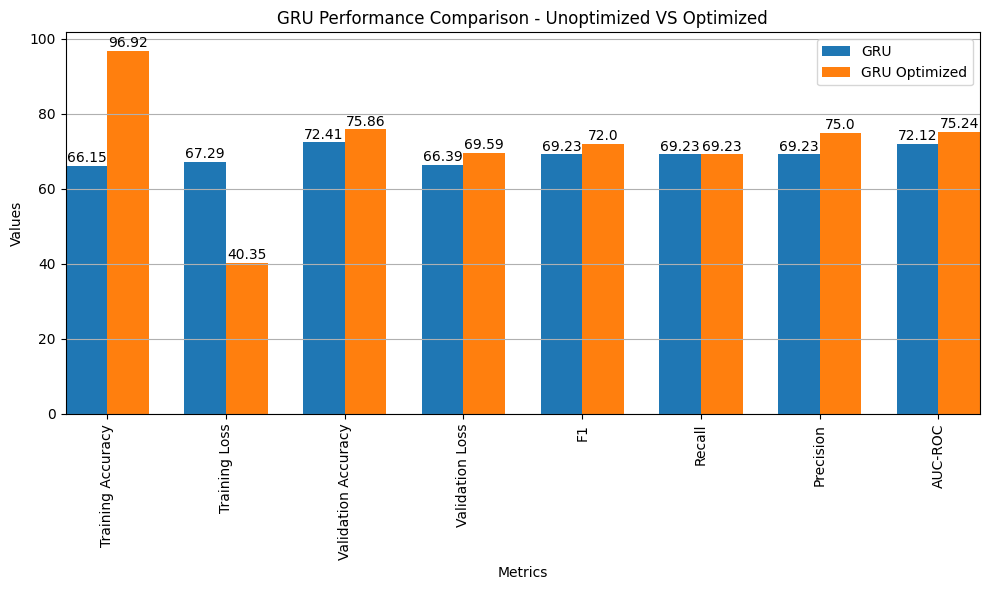

In [160]:
gru_perf_parameters = ['Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss', 'F1', 'Recall', 'Precision', 'AUC-ROC']

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
bar_width = 0.35  # Adjust bar width for better visualization

index = range(len(gru_perf_parameters))  # Create x-axis positions

gru_perf_array = adjust_array(gru_perf.copy(), 4)
gru_opt_perf_array = adjust_array(gru_opt_perf.copy(), 4)

bar1 = plt.bar(index, gru_perf_array, bar_width, label='GRU')
bar2 = plt.bar([p + bar_width for p in index], gru_opt_perf_array, bar_width, label='GRU Optimized')

# Add annotations (text) above each bar
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + .2, f'{round(yval, 2)}', ha='center', va='bottom')  # Adjust offset as needed

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 , yval + .2, f'{round(yval, 2)}', ha='center', va='bottom')  # Adjust offset as needed

# Set x-axis labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('GRU Performance Comparison - Unoptimized VS Optimized')

# Add x-axis tick labels with group labels
plt.xticks([p + 0.5 * bar_width for p in index], gru_perf_parameters, rotation = 90)

# Add legend
plt.legend()

# Show the chart
plt.grid(axis='y')  # Add gridlines for better readability
plt.tight_layout()
plt.margins(x=0)
plt.show()

#### Compare KNN VS Optimized KNN Performance

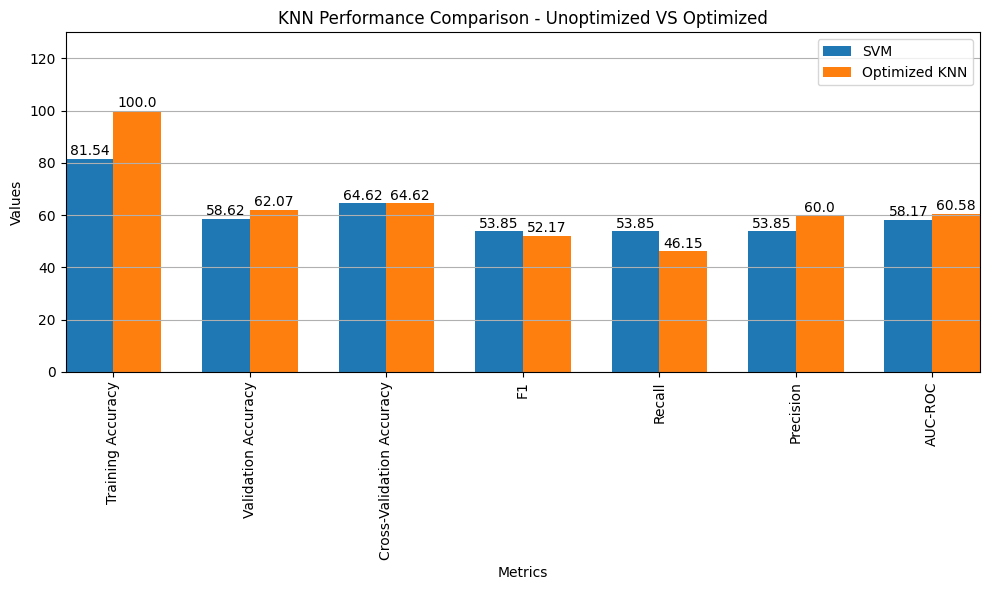

In [161]:
# Group labels
knn_perf_parameters = ['Training Accuracy', 'Validation Accuracy', 'Cross-Validation Accuracy', 'F1', 'Recall', 'Precision', 'AUC-ROC']

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
bar_width = 0.35  # Adjust bar width for better visualization

index = range(len(knn_perf_parameters))  # Create x-axis positions

knn_perf_array = adjust_array(knn_perf.copy(), 3)
knn_opt_perf_array = adjust_array(knn_opt_perf.copy(), 3)

bar1 = plt.bar(index, knn_perf_array, bar_width, label='SVM')
bar2 = plt.bar([p + bar_width for p in index], knn_opt_perf_array, bar_width, label='Optimized KNN')

# Add annotations (text) above each bar
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + .2, f'{round(yval, 2)}', ha='center', va='bottom')  # Adjust offset as needed

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 , yval + .2, f'{round(yval, 2)}', ha='center', va='bottom')  # Adjust offset as needed

# Set x-axis labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('KNN Performance Comparison - Unoptimized VS Optimized')

# Add x-axis tick labels with group labels
plt.xticks([p + 0.5 * bar_width for p in index], knn_perf_parameters, rotation = 90)

# Set the maximum y-axis value with a small buffer
plt.ylim(0, 130)  # Adjust the buffer as needed (e.g., 10%)

# Add legend
plt.legend()

# Show the chart
plt.grid(axis='y')  # Add gridlines for better readability
plt.tight_layout()
plt.margins(x=0)
plt.show()

#### Compare Linear Regression VS Optimized Linear Regression Performance

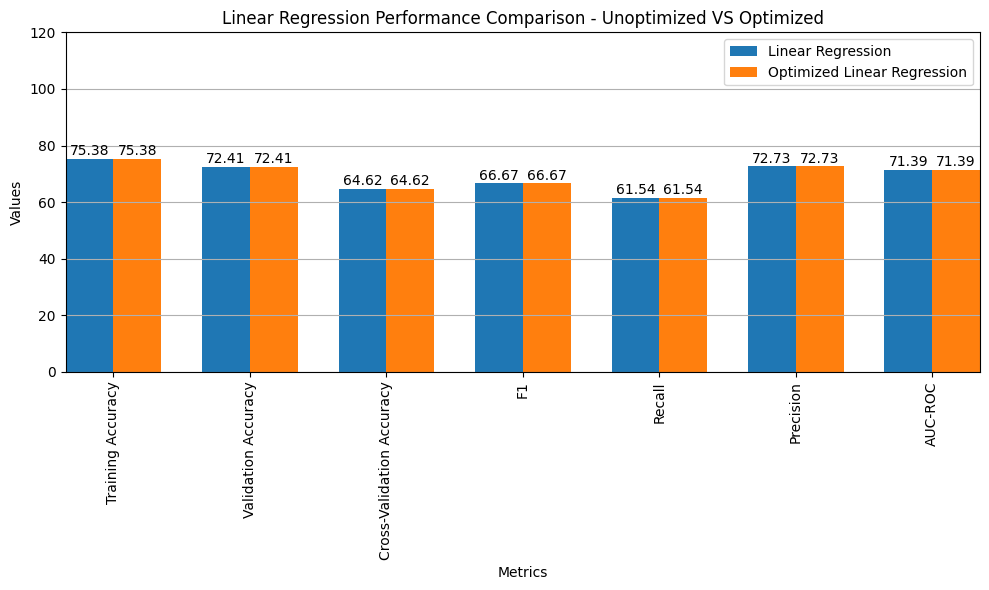

In [162]:
linr_labels = ['Training Accuracy', 'Validation Accuracy', 'Cross-Validation Accuracy', 'F1', 'Recall', 'Precision', 'AUC-ROC']

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
bar_width = 0.35  # Adjust bar width for better visualization

index = range(len(linr_labels))  # Create x-axis positions

linr_perf_array = adjust_array(linr_perf.copy(), 3)
linr_opt_perf_array = adjust_array(linr_opt_perf.copy(), 3)

bar1 = plt.bar(index, linr_perf_array, bar_width, label='Linear Regression')
bar2 = plt.bar([p + bar_width for p in index], linr_opt_perf_array, bar_width, label='Optimized Linear Regression')

# Add annotations (text) above each bar
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + .2, f'{round(yval, 2)}', ha='center', va='bottom')  # Adjust offset as needed

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 , yval + .2, f'{round(yval, 2)}', ha='center', va='bottom')  # Adjust offset as needed


# Set x-axis labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Linear Regression Performance Comparison - Unoptimized VS Optimized')

# Add x-axis tick labels with group labels
plt.xticks([p + 0.5 * bar_width for p in index], linr_labels, rotation = 90)

# Set the maximum y-axis value with a small buffer
plt.ylim(0, 120) 

# Add legend
plt.legend()

# Show the chart
plt.grid(axis='y')  # Add gridlines for better readability
plt.tight_layout()
plt.margins(x=0)
plt.show()

#### Compare All Optimized Models

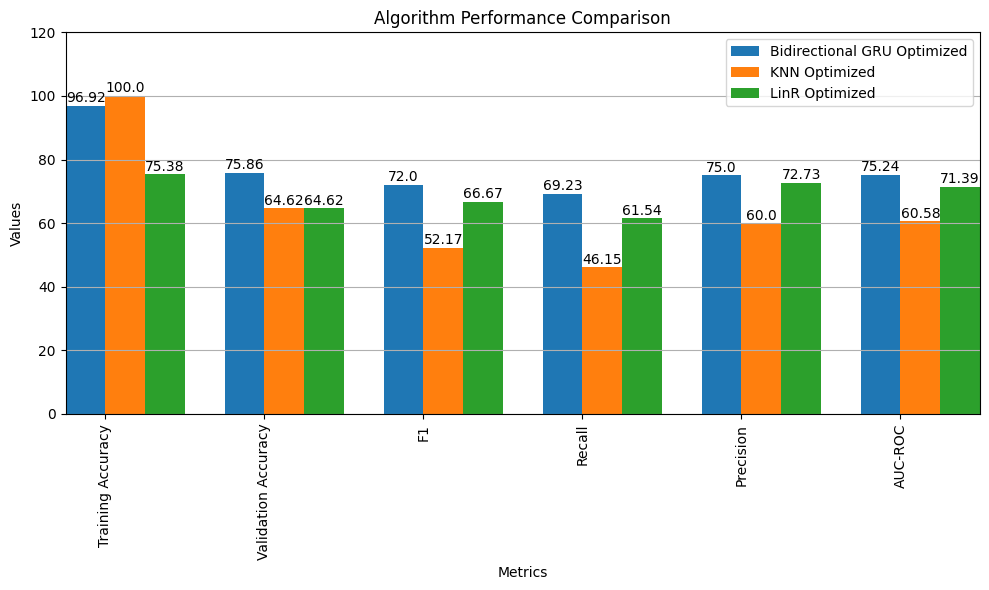

In [164]:
import matplotlib.pyplot as plt

# Group labels
group_labels = ['Training Accuracy', 'Validation Accuracy', 'F1', 'Recall', 'Precision', 'AUC-ROC']

# Create a bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
bar_width = 0.25  # Adjust bar width for better visualization

index = range(len(group_labels))  # Create x-axis positions

prep_gru_opt_perf = np.take(gru_opt_perf_array, [0, 2, 4, 5, 6, 7])
prep_knn_opt_perf = np.take(knn_opt_perf_array, [0, 2, 3, 4, 5, 6])
prep_linr_opt_perf = np.take(linr_opt_perf_array, [0, 2, 3, 4, 5, 6])

bar1 = plt.bar(index, prep_gru_opt_perf, bar_width, label='Bidirectional GRU Optimized')
bar2 = plt.bar([p + bar_width for p in index], prep_knn_opt_perf, bar_width, label='KNN Optimized')
bar3 = plt.bar([p + 2 * bar_width for p in index], prep_linr_opt_perf, bar_width, label='LinR Optimized')

# Add annotations (text) above each bar
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + .2, f'{round(yval, 2)}', ha='center', va='bottom')  # Adjust offset as needed

for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 , yval + .2, f'{round(yval, 2)}', ha='center', va='bottom')  # Adjust offset as needed
    
for bar in bar3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 , yval + .2, f'{round(yval, 2)}', ha='center', va='bottom')  # Adjust offset as needed

# Set x-axis labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Algorithm Performance Comparison')

# Add x-axis tick labels with group labels
plt.xticks([p + 0.5 * bar_width for p in index], group_labels, rotation = 90)

# Set the maximum y-axis value with a small buffer
plt.ylim(0, 120) 

# Add legend
plt.legend()

# Show the chart
plt.grid(axis='y')  # Add gridlines for better readability
plt.tight_layout()
plt.margins(x=0)
plt.show()